In [3]:
## Python dependencies 
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
import pandas as pd
import sys

In [6]:
pythonModule = '/home/jcordero/CMS/JYCMCMS/SMP_ZG/python'
sys.path.append(pythonModule)

# My Dependencies
from Samples.Data      import Data
from Plotter.Helper    import Helper

import Samples
import Plotter

Welcome to JupyROOT 6.18/04


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/root_numpy/__init__.py:34: RuntimeWarning: ROOT 6.18/04 is currently active but you installed root_numpy against ROOT 6.05/02. Please consider reinstalling root_numpy for this ROOT version.
  RuntimeWarning)
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.15.0 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [3]:
from scipy.optimize  import curve_fit
from scipy.special   import erf, betainc, gamma
from scipy           import asarray as ar,exp
from numpy.random    import uniform
from scipy           import stats
from scipy.integrate import simps
import array

from root_pandas import read_root 

# External Dependencies
from ROOT import TFile, TTree

In [4]:
import os, datetime

In [5]:
def dirStructure(figpath):
    date = datetime.datetime.now()
    fileName = str(date.year) + str(date.month) + str(date.day) + "/"
    
    try:
        os.mkdir(figpath+fileName)    
    except:
        print("Directory "+fileName+ " already exist")

    
    dirSubStructure(figpath + fileName + "Stacked/")
    dirSubStructure(figpath + fileName + "Unstacked/")
    
    dirSubStructure(figpath + fileName + "nJets/")
    for i in range(5):
        dirSubStructure(figpath + fileName + "nJets/Stacked_nJets"+str(i)+"/")
        dirSubStructure(figpath + fileName + "nJets/Unstacked_nJets"+str(i)+"/")
    
    return figpath+fileName  

def dirSubStructure(path):
    try:
        os.mkdir(path)
    except:
        print("Subdirectory for " + path + " already exists or failed.")
    
    try:
        os.mkdir(path+"log")
        os.mkdir(path+"log/Mult")
        os.mkdir(path+"linear")
        os.mkdir(path+"linear/Mult")
    except:
        print("Subdirectory for " + path + " already exists or failed.")

In [6]:
def BinFormat(Bins,ranges = None,Type='ranges', Print=False):
    bins = []
    if type(Bins) is int:
        try:
            step = int((ranges[1]-ranges[0])/Bins)
            if step*Bins+ranges[0] != ranges[1] and Print:
                print('Last bin will be omited')
        except:
            if Print:
                print('Please provide a range')
        
        if Type=='ranges':
            for i in range(Bins):
                bins.append([i*step+ranges[0],(i+1)*step+ranges[0]])
        elif Type == 'edges':
            for i in range(Bins+1):
                bins.append(i*step+ranges[0])
                
    else:
        if Type == 'ranges':
            if type(Bins[0]) is np.ndarray or type(Bins[0]) is list:
                bins = Bins
            else:
                for i in np.arange(len(Bins)-1):
                    bins.append([Bins[i],Bins[i+1]])
        elif Type == 'edges':
            if type(Bins[0]) is int or type(Bins[0]) is float or type(Bins[0]) is np.int64:
                bins = Bins
            else:
                for b in Bins:
                    bins.append(b[0])
                bins.append(Bins[-1][1])
            bins = array.array("f",bins)

    return bins

# Analysis

In [7]:
selection = 'mumug'
#selection = 'elelg'
#selection = 'ee'

#era = "2016"
era = "2017"

if selection == "mumug" or selection == "elelg":
    if era == "2016":
        run = ['B','C','D','E','F','G','H']
        #DataGen = 'rereco'
        DataGen = 'legacy'
        if DataGen == 'legacy':
            #SampleSet = 'MatchZGpaper'
            #SampleSet = 'Rerun'
            SampleSet = 'Correction'
        else:
            SampleSet = 'MatchZGpaper_newAna'
    elif era == "2017":
        run = ['B','C','D','E','F']
        DataGen = 'rereco'
        #SampleSet = 'V1'
        #SampleSet = 'V2_puWeight'
        #SampleSet = 'V2_puWeight_phID'
        #SampleSet = 'V4_phID_isConv'
        SampleSet = 'V4_phID_isConv_MINUIT'
        
    LoadVars = [
            'runNumber','evtNumber',
            'nPV','nPU','Rho', 'met',
            'genWeight','eventWeight','puWeight','triggerWeight','photonIDWeight',"photonIsConvWeight",
            'leptonOnePt','leptonOneEta','leptonOnePhi','leptonOneIso','leptonOneCharge',
            'leptonTwoPt','leptonTwoEta','leptonTwoPhi','leptonTwoIso','leptonTwoCharge',
            'photonOnePt','photonOneEta','photonOnePhi',
            'photonOneR9','photonOneMVA','photonOneERes','photonOneSieie',
            'photonOneHoverE','photonOneIneu','photonOneIph','photonOneIch',
            'photonOneSieip','photonOneSipip','photonOneSrr','photonOneE2x2','photonOneE5x5',
            'photonOneScEtaWidth','photonOneScPhiWidth',
            'photonOneScRawE','photonOnePreShowerE','photonOneScBrem',
            'genPhotonPt','genPhotonEta','genPhotonPhi',
            'vetoDY','genIsoPass',
            'dileptonPt','dileptonEta','dileptonPhi','dileptonM',
            'llgPt','llgEta','llgPhi','llgM',
            'dileptonDEta','dileptonDPhi','dileptonDR',
            'l1PhotonDEta','l1PhotonDPhi','l1PhotonDR',
            'l2PhotonDEta','l2PhotonDPhi','l2PhotonDR',
            'dileptonPhotonDEta','dileptonPhotonDPhi','dileptonPhotonDR',
            'nMuons','nElectrons','nPhotons','nJets',#'nTaus','nBJets',
            'passElectronVeto',
            ]
elif selection == "ee":
    if era == "2016":
        run = ['B','C','D','E','F','G','H']
        #DataGen = 'rereco'
        DataGen = 'legacy'
        if DataGen == 'legacy':
            #SampleSet = 'MatchZGpaper'
            #SampleSet = 'Rerun'
            SampleSet = 'Correction'
        else:
            SampleSet = 'MatchZGpaper_newAna'
    elif era == "2017":
        run = ['B','C','D','E','F']
        DataGen = 'rereco'
        SampleSet = 'EfficiencyCorrection/files_zee/V4_phID_isConv'    
    
    LoadVars = [
            'runNumber','evtNumber',
            'nPV','nPU','Rho', 
            #'eventWeight','puWeight',
            'genWeight','triggerWeight','photonIDWeight',
            #'leptonOnePt','leptonOneEta','leptonOnePhi','leptonOneCharge',
            #'leptonTwoPt','leptonTwoEta','leptonTwoPhi','leptonTwoCharge',
            #'photonOnePt','photonOneEta','photonOnePhi',
            'photonOneEta',
            #'photonOneR9','photonOneMVA','photonOneERes','photonOneSieie',
            #'photonOneHoverE','photonOneIneu','photonOneIph','photonOneIch',
            #'photonOneSieip','photonOneSipip','photonOneSrr','photonOneE2x2','photonOneE5x5',
            #'photonOneScEtaWidth','photonOneScPhiWidth',
            #'photonOneScRawE','photonOnePreShowerE','photonOneScBrem',
            #'genPhotonPt',
            #'vetoDY','genIsoPass',
            #'dileptonPt','dileptonEta','dileptonPhi','dileptonM',
            #'nMuons','nElectrons','nTaus','nPhotons','nJets','nBJets',
            #'ProbeIDPass','ProbeISOPass','ProbeWorstPass','ProbeSigPass','ProbeIsConv',
            ]
path    = "/home/jcordero/CMS/data_"+era+"/"+DataGen+"/SMP_ZG/Files/"+selection+"/"+SampleSet+"/"
figpath = "/home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/"+era+"/"+DataGen+"/"+selection+"/"

figpath = dirStructure(figpath)

#Help    = Plotter.Helper.Helper()
Help    = Helper()



Directory 202037/ already exist
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/Stacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/Stacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/Unstacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/Unstacked/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/nJets/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/nJets/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/nJets/Stacked_nJets0/ already exists or failed.
Subdirectory for /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/202037/nJets/Stacked_nJets0/ already exists or failed.
Subdirectory f

In [8]:
# --------------------------------------
#  Data
# ---------------------------------------
if selection   == 'mumug':
    DoubleLepton = [Data(path+    "DoubleMuon/","DoubleMuon_"+era,trigger = r,era = era, data=True, var = LoadVars) for r in run]
elif selection == 'elelg':
    DoubleLepton = [Data(path+      "DoubleEG/",  "DoubleEG_"+era,trigger = r,era = era, data=True, var = LoadVars) for r in run]
elif selection == "ee":
    DoubleLepton = [Data(path+"SingleElectron/",  "Electron_"+era,trigger = r,era = era, data=True, var = LoadVars) for r in run]
    
#if selection   == 'mumug':
#    DoubleLepton = [Samples.Data.Data(path+"DoubleMuon/","DoubleMuon_"+era,trigger = r,data=True) for r in run]
#elif selection == 'elelg':
#    DoubleLepton = [Samples.Data.Data(path+"DoubleEG/","DoubleEG_"+era,trigger = r,data=True) for r in run]

----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_DoubleMuon_2017B_v.root
Opening    tree::   tree_DoubleMuon_2017B
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_DoubleMuon_2017C_v.root
Opening    tree::   tree_DoubleMuon_2017C
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_DoubleMuon_2017D_v.root
Opening    tree::   tree_DoubleMuon_2017D
-------------------------------------------------
----------------- DATA --------------------------
Opening    File::/home/jcordero/CMS/data_2017/rereco/SMP_ZG/Files/mumug/V4_phID_isConv_MINUIT/DoubleMuon/output_Doub

In [9]:
print('------------------------------------------')
for d in DoubleLepton:
    print(' | Initial | ',d.TotalEvent[1],'   |',d.name)
    
print('------------------------------------------')
for d in DoubleLepton:
    print(' | Lumi | ',d.TotalEvent[2],'   |',d.name)
    
print('------------------------------------------')
for d in DoubleLepton:
#for d in data:
    print(' | Trig | ',d.TotalEvent[3],'   |',d.name)

------------------------------------------
 | Initial |  11619716.0    | DoubleMuon_2017
 | Initial |  37176389.0    | DoubleMuon_2017
 | Initial |  16523265.0    | DoubleMuon_2017
 | Initial |  33534310.0    | DoubleMuon_2017
 | Initial |  45522899.0    | DoubleMuon_2017
------------------------------------------
 | Lumi |  10875237.0    | DoubleMuon_2017
 | Lumi |  34683470.0    | DoubleMuon_2017
 | Lumi |  16221328.0    | DoubleMuon_2017
 | Lumi |  32871513.0    | DoubleMuon_2017
 | Lumi |  44788803.0    | DoubleMuon_2017
------------------------------------------
 | Trig |  6446880.0    | DoubleMuon_2017
 | Trig |  23283486.0    | DoubleMuon_2017
 | Trig |  10464909.0    | DoubleMuon_2017
 | Trig |  22435341.0    | DoubleMuon_2017
 | Trig |  30149541.0    | DoubleMuon_2017


In [ ]:
#Leptons = DoubleLepton[0] + DoubleLepton[1] + DoubleLepton[2] + DoubleLepton[3] + DoubleLepton[4] + DoubleLepton[5] + DoubleLepton[6]
Leptons = DoubleLepton[0]
for i in np.arange(len(DoubleLepton[1:])):
    Leptons =   Leptons + DoubleLepton[1]
    del DoubleLepton[1]

-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------
-------------------- MC -----------------------
Opening    File::output__0.root
Opening    tree::   tree_
-----------------------------------------------


In [ ]:
if selection == "mumug" or selection == "elelg":
    trigger    = "_v"
    DYJets     = Data(path +      "DYJets/",     "DYJets", trigger, era = era, var = LoadVars)
    if DataGen == "legacy" or era == '2017':
        ZG     = Data(path +   "ZGToLLG/",   "ZGToLLG", trigger, era = era, var = LoadVars)
        WJets  = Data(path +     "WJets/",     "WJets", trigger, era = era, var = LoadVars)
        TT     = Data(path + "TTTo2L2Nu/", "TTTo2L2Nu", trigger, era = era, var = LoadVars)
    elif DataGen == "rereco":
        ZG     = Data(path +    "ZG_ZToLL/",   "ZG_ZToLL", trigger, era = era, var = LoadVars)
        TT     = Data(path +          "TT/",         "TT", trigger, era = era, var = LoadVars)
        W1Jets = Data(path + "W1JetsToLNu/","W1JetsToLNu", trigger, era = era, var = LoadVars)
        W2Jets = Data(path + "W2JetsToLNu/","W2JetsToLNu", trigger, era = era, var = LoadVars)
        W3Jets = Data(path + "W2JetsToLNu/","W3JetsToLNu", trigger, era = era, var = LoadVars)
        W4Jets = Data(path + "W3JetsToLNu/","W4JetsToLNu", trigger, era = era, var = LoadVars)

    WWTo2L2Nu  = Data(path +   "WWTo2L2Nu/",  "WWTo2L2Nu", trigger, era = era, var = LoadVars)

    ZZTo2L2Nu  = Data(path +   "ZZTo2L2Nu/",  "ZZTo2L2Nu", trigger, era = era, var = LoadVars)
    ZZTo2L2Q   = Data(path +    "ZZTo2L2Q/",   "ZZTo2L2Q", trigger, era = era, var = LoadVars)
    ZZTo4L     = Data(path +      "ZZTo4L/",     "ZZTo4L", trigger, era = era, var = LoadVars)

    WZTo2L2Q   = Data(path +    "WZTo2L2Q/",   "WZTo2L2Q", trigger, era = era, var = LoadVars)
    WZTo3LNu   = Data(path +    "WZTo3LNu/",   "WZTo3LNu", trigger, era = era, var = LoadVars)
elif selection == "ee":
    trigger    = "_v"
    DYJets     = Data(path +      "DYJets/",     "DYJets", trigger, era = era, var = LoadVars)
    if DataGen == "legacy" or era == '2017':
        ZG     = Data(path +   "ZGToLLG/",   "ZGToLLG", trigger, era = era, var = LoadVars)
    elif DataGen == "rereco":
        ZG     = Data(path +    "ZG_ZToLL/",   "ZG_ZToLL", trigger, era = era, var = LoadVars)


In [ ]:
if selection != "ee":  
    print(' +++ Merging MC Samples')
    if DataGen == "rereco" and era == "2016":
        WJets = W1Jets + W2Jets + W3Jets + W3Jets

    WW = WWTo2L2Nu
    ZZ = ZZTo2L2Nu + ZZTo2L2Q + ZZTo4L
    WZ = WZTo2L2Q + WZTo3LNu

    VV = WWTo2L2Nu + ZZTo2L2Nu + ZZTo2L2Q + ZZTo4L + WZTo2L2Q + WZTo3LNu
    
    #del ZZTo2L2Nu, ZZTo2L2Q, ZZTo4L, WWTo2L2Nu, WZTo2L2Q, WZTo3LNu
    print('--Done')

In [ ]:
import copy
if selection != "ee":
    dataSelect = 'ALL'
    #dataSelect = 'DY Only
    #dataSelect = 'noTT'
    #dataSelect = 'DYVeto'
    #dataSelect = 'DY ZG'
    #dataSelect = 'DY ZG Comp'
    #dataSelect = 'no ZG'
    #dataSelect = 'DY Compare'


    if   dataSelect == 'ALL':
        data        = [            WJets,             VV,           TT,   DYJets,        ZG, Leptons]
        listSamples = [          'WJets',          'V-V',         'TT', 'DYJets',      'ZG',  'Data']
        legend      = [          'WJets',       '   V-V',     '    TT', 'DYJets',  '    ZG',  'Data']
        colors      = [ 'cornflowerblue', 'lightskyblue', 'lightcoral',   'plum',    'pink',     'k']
        dataFlag    = [            False,          False,        False,    False,     False,    True]
        combFlag    = [            False,          False,        False,    False,     False,    True]
    elif dataSelect == "noTT":
        data        = [  WJets,         VV,   DYJets,        ZG,      Leptons]
        listSamples = [ 'WJets',      'VV', 'DYJets',      'ZG', 'DoubleMuon']
        legend      = [ 'WJets',      'VV', 'DYJets',      'ZG', 'DoubleMuon']
        colors      = [     'b',    'cyan', 'purple', 'magenta',          'k']
        dataFlag    = [   False,     False,    False,     False,         True]
        combFlag    = [   False,     False,    False,     False,         True]
    elif dataSelect == 'VV Separate':
        data        = [  DYJets,   WJets,       TT,       WW,      ZZ,       WZ,       ZG,    Leptons]
        listSamples = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        legend      = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',     'r',  'purple',    'grey',  'teal', 'orange', 'magenta',          'k']
        dataFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
        combFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
    elif dataSelect == 'DY Only':    
        data        = [  DYJets, Leptons]
        listSamples = ['DYJets', 'DoubleMuon']
        legend      = ['DYJets', 'DoubleMuon']
        colors      = [  'cyan', 'k']
        dataFlag    = [   False, True]
        combFlag    = [   False, True]
    elif dataSelect == 'DY Compare':    
        DYJets_SideBand = copy.deepcopy(DYJets)

        data        = [  DYJets,DYJets_SideBand, Leptons]
        listSamples = ['DYJets','DYJets', 'DoubleMuon']
        legend      = ['DYJets', 'DYJets','DoubleMuon']
        colors      = [  'cyan', 'magenta','k']
        dataFlag    = [   False, False, True]    
        combFlag    = [   False, False, True]   

        data[0].name = 'DYJets_Sig'
        data[1].name = 'DYJets_SideBand'
    elif dataSelect == 'DYVeto':
        data        = [  DYJets,   WJets,       TT,       WW,      ZZ,       WZ,       ZG_veto,    Leptons]
        listSamples = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        legend      = ['DYJets', 'WJets',      'TT',    'WW',    'ZZ',     'WZ',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',     'r',  'purple',    'grey',  'teal', 'orange', 'magenta',          'k']
        dataFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
        combFlag    = [   False,   False,     False,   False,   False,    False,     False,         True]
    elif dataSelect == 'DY ZG':
        data        = [  DYJets,      ZG,    Leptons]
        listSamples = ['DYJets',      'ZG', 'DoubleMuon']
        legend      = ['DYJets',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',      'magenta',          'k']
        dataFlag    = [   False,     False,         True]
        combFlag    = [   False,     False,         True]
    elif dataSelect == 'DY ZG Comp':    
        data        = [  ZG_veto,      ZG,    Leptons]
        listSamples = ['DYJets',      'ZG', 'DoubleMuon']
        legend      = ['DYJets',      'ZG', 'DoubleMuon']
        colors      = [  'cyan',      'magenta',          'k']
        dataFlag    = [   False,     False,         True]
        combFlag    = [   False,     False,         True]
    elif dataSelect == 'no ZG':
        data        = [           WJets,             VV,           TT,   DYJets, Leptons]
        listSamples = [         'WJets',          'V-V',         'TT', 'DYJets',  'Data']
        legend      = [         'WJets',          'V-V',         'TT', 'DYJets',  'Data']
        colors      = ['cornflowerblue', 'lightskyblue', 'lightcoral',   'plum',     'k']
        dataFlag    = [           False,          False,        False,    False,    True]
        combFlag    = [           False,          False,        False,    False,    True]

    ind = []
    for i in range(len(data)):
        if len(data[i].df.columns) <= 1:
            continue
        else: 
            ind.append(i)

    data        = [data[i]        for i in ind]
    listSamples = [listSamples[i] for i in ind]
    legend      = [legend[i]      for i in ind]
    colors      = [colors[i]      for i in ind]
    dataFlag    = [dataFlag[i]    for i in ind]
    combFlag    = [combFlag[i]    for i in ind]

    for i in range(len(data)):
        print(i,data[i].name,colors[i])    
else:
    data        = [DYJets,   Leptons]
    listSamples = ['DYJets',  'Data']
    legend      = ['DYJets',  'Data']
    colors      = [  'plum',     'k']
    dataFlag    = [   False,    True]
    combFlag    = [   False,    True]

# ReWeight

In [ ]:
def GetMCPU(era = '2016',Flag = True):
    ########### MC Scenario ##################
    
    if era == '2016':
        # mix_2016_25ns_Moriond17MC_PoissonOOTPU_cfi.py
        PU = np.array([
                        0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 
                        11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 
                        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 
                        31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
                        41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 
                        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 
                        61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
                        71, 72, 73, 74]
                        )
        PUmc = np.array([
                        1.78653e-05 ,2.56602e-05 ,5.27857e-05 ,8.88954e-05 ,
                        0.000109362 ,0.000140973 ,0.000240998  ,0.00071209  ,
                        0.00130121  ,0.00245255  ,0.00502589   ,0.00919534  ,
                        0.0146697   ,0.0204126   ,0.0267586    ,0.0337697   ,
                        0.0401478   ,0.0450159   ,0.0490577    ,0.0524855   ,
                        0.0548159   ,0.0559937   ,0.0554468    ,0.0537687   ,
                        0.0512055   ,0.0476713   ,0.0435312    ,0.0393107   ,
                        0.0349812   ,0.0307413   ,0.0272425    ,0.0237115   ,
                        0.0208329   ,0.0182459   ,0.0160712    ,0.0142498   ,
                        0.012804    ,0.011571    ,0.010547     ,0.00959489  ,
                        0.00891718  ,0.00829292  ,0.0076195    ,0.0069806   ,
                        0.0062025   ,0.00546581  ,0.00484127   ,0.00407168  ,
                        0.00337681  ,0.00269893  ,0.00212473   ,0.00160208  ,
                        0.00117884  ,0.000859662 ,0.000569085  ,0.000365431 ,
                        0.000243565 ,0.00015688  ,9.88128e-05  ,6.53783e-05 ,
                        3.73924e-05 ,2.61382e-05 ,2.0307e-05   ,1.73032e-05 ,
                        1.435e-05   ,1.36486e-05 ,1.35555e-05  ,1.37491e-05 ,
                        1.34255e-05 ,1.33987e-05 ,1.34061e-05  ,1.34211e-05 ,
                        1.34177e-05 ,1.32959e-05 ,1.33287e-05]
                        )
    elif era == '2017':
        # Extracted from noTrig DYJets MC
        if Flag:
            PU = np.array([ 
                             0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
                            13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
                            26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
                            39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
                            52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
                            65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
                            78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
                            91., 92., 93., 94., 95., 96., 97., 98., 99.
                            ])
            PUmc = np.array([
                            2.50071521e-02, 9.32138697e-04, 1.34349382e-03, 1.55653761e-03,
                            1.45496351e-03, 1.43526107e-03, 1.27835150e-03, 1.15729683e-03,
                            2.21869955e-03, 1.72671527e-03, 2.28850123e-03, 3.35718143e-03,
                            4.92791900e-03, 6.68134795e-03, 9.10044445e-03, 1.17060042e-02,
                            1.45309977e-02, 1.75059783e-02, 1.99916815e-02, 2.23530463e-02,
                            2.41402001e-02, 2.53499037e-02, 2.62041645e-02, 2.67175374e-02,
                            2.74284230e-02, 2.83532398e-02, 2.89839400e-02, 2.93689364e-02,
                            2.91766601e-02, 2.90470411e-02, 2.88956340e-02, 2.90606641e-02,
                            2.90281817e-02, 2.85503530e-02, 2.82879200e-02, 2.75466820e-02,
                            2.62923374e-02, 2.50091934e-02, 2.40847315e-02, 2.32438276e-02,
                            2.14996286e-02, 1.96380581e-02, 1.77144071e-02, 1.59592475e-02,
                            1.44335061e-02, 1.32091144e-02, 1.20550570e-02, 1.16780036e-02,
                            1.13855288e-02, 1.11553119e-02, 1.13355627e-02, 1.13423077e-02,
                            1.12138868e-02, 1.12709972e-02, 1.11441738e-02, 1.12494754e-02,
                            1.10476141e-02, 1.08218347e-02, 1.03416985e-02, 9.49174212e-03,
                            8.46104682e-03, 7.27566069e-03, 5.91352943e-03, 4.90768406e-03,
                            3.81464205e-03, 3.17125069e-03, 2.79472984e-03, 2.00325951e-03,
                            1.47187034e-03, 1.02776656e-03, 7.73232257e-04, 6.06693338e-04,
                            3.89700182e-04, 3.41109691e-04, 3.04988540e-04, 2.55155551e-04,
                            1.94095718e-04, 1.72041404e-04, 1.62678304e-04, 3.32811588e-04,
                            3.62454007e-04, 2.83644223e-04, 1.80738880e-04, 2.56708672e-04,
                            1.23362162e-04, 1.57264569e-04, 8.94597549e-05, 2.03769442e-04,
                            1.75902018e-04, 1.12046568e-04, 5.72879681e-05, 4.00705152e-05,
                            5.28061053e-06, 2.49386817e-05, 2.00130702e-05, 1.53980828e-04,
                            6.65623177e-06, 1.37562123e-05, 4.82798677e-05
                            ])
        # mix_2017_25ns_UltraLegacy_PoissonOOTPU_cfi.py
        else:
            PU = np.array([
                             0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
                            10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                            20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                            30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                            40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                            50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                            60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                            70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                            80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                            90, 91, 92, 93, 94, 95, 96, 97, 98
                            ])
            PUmc = np.array([
                            1.1840841518e-05, 3.46661037703e-05, 8.98772521472e-05, 7.47400487733e-05, 0.000123005176624,
                            0.000156501700614, 0.000154660478659, 0.000177496185603, 0.000324149805611, 0.000737524009713,
                            0.00140432980253, 0.00244424508696, 0.00380027898037, 0.00541093042612, 0.00768803501793,
                            0.010828224552, 0.0146608623707, 0.01887739113, 0.0228418813823, 0.0264817796874,
                            0.0294637401336, 0.0317960986171, 0.0336645950831, 0.0352638818387, 0.036869429333,
                            0.0382797316998, 0.039386705577, 0.0398389681346, 0.039646211131, 0.0388392805703,
                            0.0374195678161, 0.0355377892706, 0.0333383902828, 0.0308286549265, 0.0282914440969,
                            0.0257860718304, 0.02341635055, 0.0213126338243, 0.0195035612803, 0.0181079838989,
                            0.0171991315458, 0.0166377598339, 0.0166445341361, 0.0171943735369, 0.0181980997278,
                            0.0191339792146, 0.0198518804356, 0.0199714909193, 0.0194616474094, 0.0178626975229,
                            0.0153296785464, 0.0126789254325, 0.0100766041988, 0.00773867100481, 0.00592386091874,
                            0.00434706240169, 0.00310217013427, 0.00213213401899, 0.0013996000761, 0.000879148859271,
                            0.000540866009427, 0.000326115560156, 0.000193965828516, 0.000114607606623, 6.74262828734e-05,
                            3.97805301078e-05, 2.19948704638e-05, 9.72007976207e-06, 4.26179259146e-06, 2.80015581327e-06,
                            1.14675436465e-06, 2.52452411995e-07, 9.08394910044e-08, 1.14291987912e-08, 0.0,
                            0.0, 0.0, 0.0, 0.0, 0.0,
                            0.0, 0.0, 0.0, 0.0, 0.0,
                            0.0, 0.0, 0.0, 0.0, 0.0,
                            0.0, 0.0, 0.0, 0.0, 0.0,
                            0.0, 0.0, 0.0, 0.0
                            ])
    elif era == '2018':
        # mix_2018_25ns_UltraLegacy_PoissonOOTPU_cfi.py
        PU = np.array([
                        0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                        10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                        20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                        30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                        40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                        50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                        60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                        70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                        80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                        90, 91, 92, 93, 94, 95, 96, 97, 98
                        ])
        PUmc = np.array([
                        8.89374611122e-07, 1.1777062868e-05, 3.99725585118e-05, 0.000129888015252, 0.000265224848687,
                        0.000313088635109, 0.000353781668514, 0.000508787237162, 0.000873670065767, 0.00147166880932,
                        0.00228230649018, 0.00330375581273, 0.00466047608406, 0.00624959203029, 0.00810375867901,
                        0.010306521821, 0.0129512453978, 0.0160303925502, 0.0192913204592, 0.0223108613632,
                        0.0249798930986, 0.0273973789867, 0.0294402350483, 0.031029854302, 0.0324583524255,
                        0.0338264469857, 0.0351267479019, 0.0360320204259, 0.0367489568401, 0.0374133183052,
                        0.0380352633799, 0.0386200967002, 0.039124376968, 0.0394201612616, 0.0394673457109,
                        0.0391705388069, 0.0384758587461, 0.0372984548399, 0.0356497876549, 0.0334655175178,
                        0.030823567063, 0.0278340752408, 0.0246009685048, 0.0212676009273, 0.0180250593982,
                        0.0149129830776, 0.0120582333486, 0.00953400069415, 0.00738546929512, 0.00563442079939,
                        0.00422052915668, 0.00312446316347, 0.00228717533955, 0.00164064894334, 0.00118425084792,
                        0.000847785826565, 0.000603466454784, 0.000419347268964, 0.000291768785963, 0.000199761337863,
                        0.000136624574661, 9.46855200945e-05, 6.80243180179e-05, 4.94806013765e-05, 3.53122628249e-05,
                        2.556765786e-05, 1.75845711623e-05, 1.23828210848e-05, 9.31669724108e-06, 6.0713272037e-06,
                        3.95387384933e-06, 2.02760874107e-06, 1.22535149516e-06, 9.79612472109e-07, 7.61730246474e-07,
                        4.2748847738e-07, 2.41170461205e-07, 1.38701083552e-07, 3.37678010922e-08, 0.0,
                        0.0, 0.0, 0.0, 0.0, 0.0,
                        0.0, 0.0, 0.0, 0.0, 0.0,
                        0.0, 0.0, 0.0, 0.0, 0.0,
                        0.0, 0.0, 0.0, 0.0
                        ])

    return PU,PUmc

In [ ]:
def GetDataPU(era = '2016',xsec='69p2'):
    pileupFile = 'pileup_sf_'+era+'_'+xsec+'mb.root'
    file = TFile('/home/jcordero/CMS/data_'+era+'/'+DataGen+'/SMP_ZG/Files/'+pileupFile)
    puTree = file.Get('pileup')
    PUdata = []
    for pu in puTree:
        PUdata.append(pu)
    return PUdata

In [ ]:
def GetPUweight(era = '2016', xsec='69p2'):
    
    ### Get Distributions ##
    PU,PUmc = GetMCPU(era)
    PUdata  = GetDataPU(era,xsec)
    
    ### Normalize ###
    PUmc   = np.array(PUmc)/sum(PUmc)        
    PUdata = np.array(PUdata)/sum(PUdata)
    
    return PU,PUdata[:len(PUmc)]/PUmc,PUdata,PUmc,

In [ ]:
def SF_ratio(
             era = '2016',
             xsec1='65',
             xsec2='69p2',
            ):
    pu,r1,r1d,r1mc = GetPUweight(era = era, xsec = xsec1)
    pu,r2,r2d,r2mc = GetPUweight(era = era, xsec = xsec2)
    
    rScale = r1/r2
    rScale[np.isnan(rScale)] = np.ones(sum(np.isnan(rScale)))

    puWeight = []
    for d in data[:-1]:
        puW = np.ones(len(d.df.nPU))
        print('--------------',d.name)
        print(len(d.df.nPU))
        for i in range(len(pu)-2):
            mask = np.logical_and(np.array(d.df.nPU) > pu[i], np.array(d.df.nPU) <= pu[i+1])        
            puW[mask] = np.ones(np.sum(mask))*rScale[i]
        puWeight.append(puW)
    return puWeight

# Lower Level Plotting Functions

In [18]:
def GetStatUncertainty(bins, counts, scale):
    x = []
    x.append(bins[0])
    for i in np.arange(1,len(bins)-1):
        x.append(bins[i])
        x.append(bins[i])
    x.append(bins[-1])

    statUn = np.sqrt(counts)
    statsUp, statsDown = [],[]
    count = []
    for i in np.arange(len(counts)):
        count.append(counts[i])
        count.append(counts[i])
        
        statsUp.append(statUn[i]*scale[i])
        statsUp.append(statUn[i]*scale[i])
        
        statsDown.append(statUn[i]*scale[i])
        statsDown.append(statUn[i]*scale[i])
        
    count     =     np.array(count)
    statsUp   =   np.array(statsUp)
    statsDown = np.array(statsDown)
    return x,count,statsUp, statsDown

In [19]:
def UnStackHist(hist):
    UnHist = []
    UnHist.append(hist[0])
    for i in np.arange(1,len(hist)):
        UnHist.append(hist[i] - hist[i-1])
    return UnHist

In [20]:
def GET_StatUncertainty(data,hist,var,bins):
    if len(var)>2:
        part,var,ph = var[0],var[2],'_'+var[1]
    else:
        part,var,ph= var[0],var[1],''
    var = part+var+ph
    
    #print(hist)
    
    VAL = hist[-1]
    hist = UnStackHist(hist)
    bins = np.array(bins)
    
    xc = (bins[:-1]+bins[1:])/1
    for i in np.arange(len(hist)-1):
        scale = []
        for j in np.arange(len(bins)-1):
            Ind = np.logical_and(data[i].GetWithCuts(var) > bins[j], data[i].GetWithCuts(var) <= bins[j+1])
            #weightPerBin.append(np.sum(d.GetWithCuts('weights')[Ind]))
            if np.sum(Ind) == 0:
                scale.append(1)
            else:
                weightOverYield = np.sum(data[i].GetWithCuts('weights')[Ind])/np.sum(Ind)
                scale.append(weightOverYield)
                     
        if i == 0:
            x,value, Up, Down = GetStatUncertainty(xc,hist[i],scale)
            statsUp   = Up
            statsDown = Down
        else:
            x,value, Up, Down = GetStatUncertainty(xc,hist[i],scale)
            statsUp   += Up
            statsDown += Down              
    x,value, Up, Down = GetStatUncertainty(bins,VAL,scale)
    
    return x,value,statsUp, statsDown

In [21]:
def GET_RangeBins(Ks,
                  Blind    = True,
                  Plotting = True, 
                 ):
    ##########################
    if len(Ks)>2:
        part,var,ph = Ks[0],Ks[2],'_'+Ks[1]
    else:
        part,var,ph= Ks[0],Ks[1],''
    
    ###########################
    if   var == 'nJets':
        ranges = [0,7]
        bins   = 7
    elif var == 'Pt':
        if not Blind:
            if part == 'photonOne' and Plotting:
                ranges = Help.plotOpsAll[0]['range'][var][part+ph]
                bins   = Help.plotOpsAll[0]['bins'][var][part+ph][:-1]
            else:
                ranges = Help.plotOpsAll[0]['range'][var][part+ph]
                bins   = Help.plotOpsAll[0]['bins'][var][part+ph]
        elif part == 'photonOne':
            ranges = [15,80]
            bins   = [15,20,25,30,35,45,55]           
        else:
            ranges = Help.plotOpsAll[0]['range'][var][part+ph]
            bins   = Help.plotOpsAll[0]['bins'][var][part+ph]
    elif var == 'M':
        if not Blind:
            if part == 'llg' and Plotting:
                ranges = Help.plotOpsAll[0]['range'][var][part+ph]
                bins   = Help.plotOpsAll[0]['bins'][var][part+ph][:-1]
            elif part == 'dilepton':
                ranges = [50,150]
                bins   = np.arange(50,150,step=2)
            else:
                ranges = Help.plotOpsAll[0]['range'][var][part+ph]
                bins   = Help.plotOpsAll[0]['bins'][var][part+ph]
        elif part == 'llg' :
            ranges = [50,135]
            bins   = [50,  85,  95,  110,  135,  170,  210,  270] 
        elif part == 'dilepton':
            ranges = [50,150]
            bins   = np.arange(50,150,step=2)
        else:
            ranges = Help.plotOpsAll[0]['range'][var][part+ph]
            bins   = Help.plotOpsAll[0]['bins'][var][part+ph]
    else:
        ranges = Help.plotOpsAll[0]['range'][var][part+ph]
        bins   = Help.plotOpsAll[0]['bins'][var][part+ph]
    ##########################
    

    if var == "Pt":
        if part == "photonOne":
            #bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 110, 120]
            bins = np.arange(15,130,step=2)
    elif var == "M":
        if part == "llg":
            #bins = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
            bins = np.arange(50,200,step=3)
        if part == "dilepton":
            #bins = [50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
            bins = np.arange(50,300,step=5)
    elif var == "Ich":
        if part == "photonOne":
            bins = np.arange(0.001,12,step=0.5)
    elif var == "Ineu":
        if part == "photonOne":
            bins = np.arange(0.001,12,step=0.5)
    elif var == "Iph":
        if part == "photonOne":
            bins = np.arange(0.001,12,step=0.5)
    elif var == "Sieie":
        if part == "photonOne":
            bins = np.arange(0,0.045,step=0.001)
        
            
    return ranges,bins

In [22]:
def GET_WeiVAR(data,Ks,weightCorrection = True):
    if len(Ks)>2:
        part,var,ph = Ks[0],Ks[2],'_'+Ks[1]
    else:
        part,var,ph= Ks[0],Ks[1],''
     
    
    if weightCorrection:
        # MODIFICATIONS
        
        #wei = [np.array(reWeight[i][data[i].cuts])/(np.array(data[i].df.photonIDWeight)[data[i].cuts]) for i in range(len(data[:-1]))]
        #wei.append(data[-1].GetWithCuts('weight')//(np.array(data[-1].df.photonIDWeight)[data[-1].cuts]))
        
        #wei = [np.array(reWeight[i][data[i].cuts])*(np.array(data[i].df.photonIDWeight)[data[i].cuts]) for i in range(len(data[:-1]))]
        #wei.append(data[-1].GetWithCuts('weight'))
        
        #wei = [np.array(reWeight[i][data[i].cuts]) for i in range(len(data[:-1]))]
        #wei.append(data[-1].GetWithCuts('weight'))
        
        ######################
        ### Nothing Added
        wei = [np.array(reWeight[i][data[i].cuts]) for i in range(len(data[:-1]))]
        wei.append(data[-1].GetWithCuts('weight'))
        
        ######################
        ### Eliminate IDWeight and isConv
        #wei = [np.array(reWeight[i][data[i].cuts])/(np.array(data[i].df.photonIDWeight)[data[i].cuts]) for i in range(len(data[:-1]))]
        #wei.append(data[-1].GetWithCuts('weight')//(np.array(data[-1].df.photonIDWeight)[data[-1].cuts]))
        
        ######################
        ### Eliminate IDWeight and isConv
        #wei = [np.array(reWeight[i][data[i].cuts])/(np.array(data[i].df.photonIDWeight)[data[i].cuts]*np.array(data[i].df.photonIsConvWeight)[data[i].cuts]) for i in range(len(data[:-1]))]
        #wei.append(data[-1].GetWithCuts('weight')//((np.array(data[-1].df.photonIDWeight)*np.array(data[-1].df.photonIsConvWeight))[data[-1].cuts]))
        
        ######################
        ### ONLY isConv Added 
        #wei = [np.array(reWeight[i][data[i].cuts])*np.array(data[i].df.photonIsConvWeight)[data[i].cuts] for i in range(len(data[:-1]))]
        #wei.append(data[-1].GetWithCuts('weight'))
    else:
        # ORIGINAL
        wei = [d.GetWithCuts('weight') for d in data]
    
    #for i in range(len(data)):
    #    if data[i].name == "DYJets":
    #        wei[i] = 1.2*wei[i]
    VAR = [d.GetWithCuts(part+var+ph) for d in data]        

    return wei,VAR

In [23]:
def PlotDataMC(
                ax,
                lims,
                Data,Sig,Bkg,
                ranges,bins,mag=1,
                signalInclude=True,
                log = False,
                ):
    Bkg = Bkg[:len(Data[0])]
    try:
        Sig = Sig[:len(Data[0])]
    except:
        Sig = Sig
    
    if not signalInclude:
        h = Bkg+Sig/mag
        rDataMC = Data[1]/(Bkg+Sig/mag) - 1 
    else:
        h = np.array(Bkg)
        rDataMC = Data[1]/Bkg - 1 

    bins = BinFormat(Bins=bins,ranges=ranges,Type='ranges')
    
    ax.errorbar(
                Data[0], rDataMC[:len(Data[0])],
                xerr      = np.diff(bins)/2,
                yerr      = Data[1]/h*np.sqrt(1/Data[1]+1/h),
                color     = 'k',
                marker    = 'o',
                linestyle = '',
                linewidth = 1.5
               )    
    plt.grid(linestyle='--')
    
    ax.set_ylabel(r'$\frac{Data}{MC}-1$')
    ax.set_xlim(lims[0])
    ax.set_ylim(lims[1])
    if log:
        ax.set_yscale('log')

In [24]:
def PlotData(
            ax,
            Data,
            ranges,
            bins,
            log = False,
            ):

    y3,x3 =np.histogram(
                        Data,
                        range    = ranges,
                        bins     = bins,
                       )
    x3b = (x3[1:len(x3)] + x3[0:-1])/2
    ax.errorbar(x3b,
                y3,
                xerr      = np.diff(x3)/2,yerr = np.sqrt(y3),
                color     ='k',
                marker    ='o',
                linestyle ='',
                label     = legend[-1]
               )
    ax.legend(prop={'size': 10})
    
    xlim = ax.get_xlim()
    ax.set_ylabel('# Counts')
    #ax.set_xlabel(var)
    #plt.legend()
    if log:
        ax.set_yscale('log')
        
    return x3,np.array(y3),x3b,xlim

In [25]:
def Plot(data,
         var,
         part             =  '',
         signalInclude    = False,
         stacked          = True,
         density          = False,
         log              = False,
         weightCorrection = True,
         Plotting         = True,
         Blind            = True,
         StatInclude      = False,
        ):

    
    
    k = part+'_'+var
    Ks = k.split('_')
    
    ##########################
    
    ranges,bins = GET_RangeBins(Ks,Blind=False,Plotting=Plotting)
    wei   ,VAR  = GET_WeiVAR   (data,Ks, weightCorrection=weightCorrection )
    label = [legend[i] + ' Yield '+ str(int(np.sum(data[i].GetWithCuts('weights')))) for i in np.arange(len(data))]
    
    ##########################
    
    if stacked:
        histtype = 'stepfilled'
    else:
        histtype = 'step'
        
    ##########################
    
    if not signalInclude:
        N = 2
    else:
        N = 1
        
    ###########################################################

    fig = plt.figure(figsize=(10,10))
    plt.subplot2grid((4,1),(0,0),rowspan = 3, colspan = 1)

    
    h_bg = plt.hist(
                    VAR[:-N],
                    range     = ranges,
                    bins      = bins,
                    histtype  = histtype,
                    stacked   = stacked,
                    weights   = wei[:-N],
                    #label     = legend[:-N],
                    label     = label[:-N],
                    color     = colors[:-N],
                    density   = density,
                    linewidth = linewidth,
                    )

    plt.grid(linestyle='--')
    plt.legend()

    ##########################
    
    if stacked:
        ##########################
        if not signalInclude:
            h_sig = plt.hist(
                                VAR[-N],
                                range     = ranges,
                                bins      = bins,
                                histtype  = histtype,
                                stacked   = stacked,
                                #label     = legend[-N]+" x"+str(mag),
                                label     = label[-N]+" x"+str(mag),
                                color     = colors[-N],
                                weights   = np.array(wei[-N])*mag,
                                density   = density,
                                linewidth = 1.5,
                                #alpha = 0.5,
                                )
        else:
            h_sig = h_bg[-N]
            
        if type(bins) is float or type(bins) is int:
            step = (ranges[1]-ranges[0])/bins
            bins = np.array([ranges[0]+i*step for i in np.arange(bins+1)])   
        #x,value,statUp,statDown = GET_StatUncertainty(data, hist = h_bg[0], var=Ks, bins = bins)
        
        if StatInclude:
            try:
                x,value,statUp,statDown = GET_StatUncertainty(data, hist = h_bg[0], var=Ks, bins = h_bg[1])
            except:
                x,value,statUp,statDown = GET_StatUncertainty(data, hist = [h_bg[0]], var=Ks, bins = h_bg[1])
        
            ax = plt.gca()
            ax.fill_between(x,value-statDown,value+statUp,facecolor='lightgrey',color = 'grey',hatch='/////',alpha=0.6,label='MC stat')
            
        ##########################
        if not density:
            #---------------------
            #---- Ploting the Data    
            #---------------------
            ax = plt.gca()
            # Blind the data Plot
            ranges,bins = GET_RangeBins(Ks,Blind=Blind,Plotting=Plotting)
            
            x3,y3,x3b,xlim = PlotData(ax,VAR[-1],ranges,bins,log)
            ax.set_xlabel(var)
            
            #------------------------
            #---- Ploting the Data/MC    
            #-------------------------
            plt.subplot2grid((4,1),(3,0),rowspan = 1, colspan = 1)    
            ax = plt.gca()
            
            # Data/MC  y-RANGE
            ylim = [-0.5,0.5]
            try:
                PlotDataMC(ax,
                       lims    = [xlim, ylim],
                       Data    = [x3b, y3],
                       Bkg     = h_bg[0][-1],
                       Sig     = h_sig[0],
                       ranges  = ranges,
                       bins    = bins,
                      )
            except:
                PlotDataMC(ax,
                       lims    = [xlim, ylim],
                       Data    = [x3b, y3],
                       Bkg     = h_bg[0],
                       Sig     = h_sig[0],
                       ranges  = ranges,
                       bins    = bins,
                      )
            
    
    plt.tight_layout()
    plt.show()
    fig.savefig(figpath+stackFol+'/'+var+'_'+part+stackLab+".png")
    
    try:
        return x3,y3,h_bg[0][-1],h_sig[0]
    except:
        return False

In [26]:
def Plot_Mult(
              data,
              var,
              part             = ['lepton1','lepton2','photon1','dilep','dilepgm'],
              signalInclude    = False,
              figDim           = [2,3],
              customRange      = False,
              stacked          = True,
              log              = False,
              weightCorrection = True,
              Blind            = True,
              Plotting         = True,
              StatInclude      = False,
             ):

    
    nx,ny = figDim[0],figDim[1]
    
    ##########################
    if not signalInclude:
        N = 2
    else:
        N = 1
    ##########################
    if stacked:
        histtype = 'stepfilled'
    else:
        histtype = 'step'
    ##########################
    
    htemp = []
    row,col =0 , 0
    
    
    fig = plt.figure(figsize = (6*ny, 6*nx))
    
    for j,k in zip(range(len(part)),part):    
        K = k+'_'+var
        Ks = K.split('_')
        
        ##########################
        
        ranges,bins = GET_RangeBins(Ks, Blind=False,Plotting=Plotting)
        wei, VAR    = GET_WeiVAR(data, Ks, weightCorrection=weightCorrection )
        label = [legend[i] + ' Yield '+ str(int(np.sum(data[i].GetWithCuts('weights')))) for i in np.arange(len(data))]

        ##########################
        
        nx,ny = figDim[0],figDim[1]
    
        if j != 0:
            if j%ny == 0:
                row += 1
                col = 0  
    
        ax = plt.subplot2grid((nx*4,ny),(row*4,col),rowspan = 3, colspan = 1)    
        title_lab = k        


    
        
        h_bg = ax.hist(
                        VAR[:-N],                            
                        histtype  = histtype,
                        range     = ranges,
                        bins      = bins,
                        stacked   = stacked,
                        color     = colors[:-N],
                        weights   = wei[:-N],
                        #label     = legend,
                        label     = label,
                        density   = density,
                        linewidth = linewidth,
                        )
        htemp.append(h_bg)
        ax.set_title(title_lab)
        ax.set_xlabel(var)
        ax.grid(linestyle='--')
        ax.legend(prop={'size':10})

        #----------------------------------------------------------------
        #----------------------------------------------------------------
        if stacked:
            if not signalInclude:
                h_sig = ax.hist(
                                VAR[-N],
                                bins      = bins,
                                range     = ranges,
                                histtype  = Help.plotOpsAll[-N]['histtype'],
                                stacked   = Help.plotOpsAll[-N]['stacked'],
                                color     = colors[-N],
                                weights   = wei[-N],
                                #label     = legend[-N] + "x"+str(mag),
                                label     = label[-N] + "x"+str(mag),
                                linewidth = 2
                                )
                ax.legend(prop={'size': 10})
            else:
                h_sig = h_bg[0][-1]
            
            if type(bins) is float or type(bins) is int:
                step = (ranges[1]-ranges[0])/bins
                bins = np.array([ranges[0]+i*step for i in np.arange(bins+1)])   
            
            ax = plt.gca()
            if StatInclude:
                #x,value,statUp,statDown = GET_StatUncertainty(data, hist = h_bg[0], var=Ks, bins = bins)
                x,value,statUp,statDown = GET_StatUncertainty(data, hist = h_bg[0], var=Ks, bins = h_bg[1])
                ax.fill_between(x,value-statDown,value+statUp,facecolor='lightgrey',color = 'grey',hatch='/////',alpha=0.6,label='MC stat')
            
            
            #---------------------
            #---- Ploting the Data    
            #---------------------
            # Blind the data Plot
            ranges,bins = GET_RangeBins(Ks,Blind=Blind,Plotting=Plotting)
            
            x3,y3,x3b,xlim = PlotData(ax,VAR[-1],ranges,bins,log)
            ax.set_xlabel(var)
            
            #------------------------
            #---- Ploting the Data/MC    
            #-------------------------
            ax1 = plt.subplot2grid((nx*4,ny),(row*4+3,col),rowspan = 1, colspan = 1)    
            
            # Data/MC  y-RANGE
            ylim = [-0.5,0.5]
            try:
                PlotDataMC(ax1,
                       lims    = [xlim, ylim],
                       Data    = [x3b, y3],
                       Bkg     = h_bg[0][-1],
                       Sig     = h_sig[0],
                       ranges  = ranges,
                       bins    = bins,
                      )
            except:
                PlotDataMC(ax1,
                       lims    = [xlim, ylim],
                       Data    = [x3b, y3],
                       Bkg     = h_bg[0],
                       Sig     = h_sig[0],
                       ranges  = ranges,
                       bins    = bins,
                      )
            
        col+=1
        if log:
            ax.set_yscale('log')
        #########################################################
        
    
    fig.tight_layout()
    plt.show()
    fig.savefig(figpath+stackFol+'/Mult/'+var+stackLab+".png")

In [27]:
def Plot_Mult_DataMC(
                    data,
                    var,
                    part          = ['lepton1','lepton2','photon1','dilep','dilepgm'],
                    signalInclude = False,
                    figDim        = [2,3],
                    customRange   = False,
                    stacked       = True,
                    log           = False,
                    ):
        
    
    nx,ny = figDim[0],figDim[1]
    ########
    if not signalInclude:
        N = 2
    else:
        N = 1
    #########   
    
    if nx > 3:
        fig = plt.figure(figsize = (18, 30))
    else:
        fig = plt.figure(figsize = (18, 15))
    
    
    for j,k in zip(range(len(part)),part):    
        Ks = k.split('_')
        
        if customRange:
            if var == 'Pt':
                if k == 'lepton2':
                    ranges = [0,80]
                    bins = Help.plotOpsAll[0]['bins'][var][k]
                elif k == 'photonOne' or k == 'photonOne_EE' or k == 'photonOne_EB':
                    ranges = [0,80]
                    bins = 40
                else:
                    ranges = Help.plotOpsAll[0]['range'][var][k]
                    bins = Help.plotOpsAll[0]['bins'][var][k]
            else:
                
                #if Ks[1] in ['EE','EB']:
                if len(Ks) >1:
                    bins = Help.plotOpsAll[0]['bins'][var][Ks[0]]
                    ranges = Help.plotOpsAll[0]['range'][var][Ks[0]]
                else:
                    bins = Help.plotOpsAll[0]['bins'][var][k]
                    ranges = Help.plotOpsAll[0]['range'][var][k]                    

        else:
            #print(var,k)
            bins   = Help.plotOpsAll[0]['bins'][var][k]
            ranges = Help.plotOpsAll[0]['range'][var][k]
        
        if len(Ks) > 1:
            if Ks[1] == 'EE' :
                wei = np.array([d.GetWithCuts('weight')[np.abs(d.GetWithCuts('photonOneEta')) >  1.48] for d in data])
                VAR = [d.GetWithCuts(Ks[0]+var)[np.abs(d.GetWithCuts('photonOneEta')) >  1.48] for d in data]
            elif Ks[1] == 'EB':
                wei = np.array([d.GetWithCuts('weight')[np.abs(d.GetWithCuts('photonOneEta')) <=  1.48] for d in data])
                VAR = [d.GetWithCuts(Ks[0]+var)[np.abs(d.GetWithCuts('photonOneEta')) <=  1.48] for d in data]
        else:
            wei = [d.GetWithCuts('weight') for d in data]
            VAR = [d.GetWithCuts(Ks[0]+var) for d in data]

        
        nx,ny = figDim[0],figDim[1]
        plt.subplot(nx,ny,j+1)

                
        #print(np.mean(VAR[-1]))
        htemp = [] 
        for v,w in zip(VAR[:-N],wei[:-N]):
            #print(len(v),len(w))
            h_bg = np.histogram(
                                #VAR[:-N],                            
                                v,
                                range     = ranges,
                                bins      = bins,
                                #stacked = stacked,
                                #weights   = wei[:-N],
                                weights = w,
                                density   = density,
                                )
            htemp.append(h_bg)
        #----------------------------------------------------------------
        #----------------------------------------------------------------
        h_sig = np.histogram(
                            VAR[-N],
                            bins      = bins,
                            range     = ranges,
                            #stacked   = Help.plotOpsAll[-N]['stacked'],
                            weights   = wei[-N],
                            )
        #----------------------------------------------------------------
        #----------------------------------------------------------------

        y3,x3 =np.histogram(
                            VAR[-1],
                            bins  = bins,
                            range = ranges,
                           )
        x3b = (x3[1:len(x3)] + x3[0:-1])/2
        ####
        h_bkg = np.array(htemp[0][0])
        for tmp in htemp[1:]:
            h_bkg += np.array(tmp[0])
            
        h = h_bkg #+ h_sig[0]/mag 
        rDataMC = y3/h - 1 
        err = y3/h*np.sqrt(1/y3+1/h)
        #h = h_bg[0][-1]+h_sig[0]/mag 
        #rDataMC = y3/(h_bg[0][-1]+h_sig[0]/mag) - 1 
        
        #print(rDataMC)


        #ax1 = plt.gca()
        plt.errorbar(
                    x3b, rDataMC,
                    yerr = err,
                    color = 'k',
                    marker = 'o',
                    linestyle = '',
                    linewidth = 1.5
                   )    
        plt.grid(linestyle='--')
        plt.ylabel(r'$\frac{Data}{MC}-1$')
        plt.title(k)
        plt.xlabel(var)
        ax = plt.gca()
        if max(rDataMC)+np.mean(err) < 0.3 and min(rDataMC)-np.mean(err) > -0.3:
            ax.set_ylim([min(rDataMC)-0.05,max(rDataMC)+0.05])
        elif max(rDataMC)+np.mean(err) > 0.3 or min(rDataMC)-np.mean(err) < -0.3:
            ax.set_ylim([-0.3,0.5])
        else:
            ax.set_ylim([-0.3,0.3])
            
        if log:
            ax.set_yscale('log')
        #########################################################
        
    
    fig.tight_layout()
    fig.savefig(figpath+stackFol+'/'+var+'_DataMC'+".png")

# High Level Functions

In [28]:
def Single_Ploting(
                   data,
                   stacked,
                   log,
                   weightCorrection = True,
                   Blind            = True, 
                   Plotting         = True,
                   StatInclude      = False,
                  ):
    #################################################################
    #var = ['nPV','nJets','nBJets','nMuons','nPhotons','met']
    #var = ['nJets','nBJets','nMuons','nPhotons','met']
    var = ['nJets','nMuons','nPhotons','met']
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot(
            data,
            v,
            part             = '',
            signalInclude    = True,
            stacked          = stacked,
            density          = density,
            log              = log,
            weightCorrection = weightCorrection,
            Blind            = Blind,
            Plotting         = Plotting,
            StatInclude      = StatInclude,
            )
        
    #################################################################
    var = ['Pt','Phi','Eta']
    part = ['leptonOne','leptonOne_EE','leptonOne_EB',
            'leptonTwo','leptonTwo_EE','leptonTwo_EB',
            'photonOne','photonOne_EE','photonOne_EB',
            'dilepton','dilepton_EE','dilepton_EB',
            'llg','llg_EE','llg_EB',
           ]
    for p in part:
        for v in var:
            print('----------------'+p+v+'----------------')
            Plot(
                 data,
                 v,
                 part             = p,
                 signalInclude    = True,
                 stacked          = stacked,
                 density          = density,
                 log              = log,
                 weightCorrection = weightCorrection,
                 Blind            = Blind,
                 Plotting         = Plotting,
                 StatInclude      = StatInclude,
                )   
            
    #################################################################
    var = ['DPhi','DEta','DR']
    part = ['l1Photon','l1Photon_EE','l1Photon_EB',
            'l2Photon','l2Photon_EE','l2Photon_EB',
            'dilepton','dilepton_EE','dilepton_EB',
            'dileptonPhoton','dileptonPhoton_EE','dileptonPhoton_EB',
            ]    
    for p in part:
        for v in var:
            print('----------------'+p+v+'----------------')
            Plot(
                 data,
                 v,
                 part             = p,
                 signalInclude    = True,
                 stacked          = stacked,
                 density          = density,
                 log              = log,
                 weightCorrection = weightCorrection,
                 Blind            = Blind,
                 Plotting         = Plotting,
                 StatInclude      = StatInclude,
                )            
    #################################################################            
    var = ['HoverE','R9','MVA']#,'eres']
    part = ['photonOne','photonOne_EE','photonOne_EB']    
    for p in part:
        for v in var:
            print('----------------'+p+v+'----------------')
            Plot(
                 data,
                 v,
                 part             = p,
                 signalInclude    = True,
                 stacked          = stacked,
                 density          = density,
                 log              = log,
                 weightCorrection = weightCorrection,
                 Blind            = Blind,
                 Plotting         = Plotting,
                 StatInclude      = StatInclude,
                )              
    #################################################################            
    var = ['Ich','Ineu','Iph']
    part = ['photonOne','photonOne_EE','photonOne_EB']                
    for p in part:
        for v in var:
            print('----------------'+p+v+'----------------')
            Plot(
                 data,
                 v,
                 part             = p,
                 signalInclude    = True,
                 stacked          = stacked,
                 density          = density,
                 log              = log,
                 weightCorrection = weightCorrection,
                 Blind            = Blind,
                 Plotting         = Plotting,
                 StatInclude      = StatInclude,
                )        
            
    #################################################################            
    var = ['Srr','Sipip','Sieip','Sieie']
    part = ['photonOne','photonOne_EE','photonOne_EB']                
    for p in part:
        for v in var:
            print('----------------'+p+v+'----------------')
            Plot(
                 data,
                 v,
                 part             = p,
                 signalInclude    = True,
                 stacked          = stacked,
                 density          = density,
                 log              = log,
                 weightCorrection = weightCorrection,
                 Blind            = Blind,
                 Plotting         = Plotting,
                 StatInclude      = StatInclude,
                )        
    #################################################################            
    var = ['E2x2','E5x5','ScEtaWidth','ScPhiWidth','ScRawE','ScBrem','PreShowerE']
    part = ['photonOne','photonOne_EE','photonOne_EB']                
    for p in part:
        for v in var:
            print('----------------'+p+v+'----------------')
            Plot(
                 data,
                 v,
                 part             = p,
                 signalInclude    = True,
                 stacked          = stacked,
                 density          = density,
                 log              = log,
                 weightCorrection = weightCorrection,
                 Blind            = Blind,
                 Plotting         = Plotting,
                 StatInclude      = StatInclude,
                )                    

In [29]:
def Multi_Ploting(
                  data,
                  stacked,
                  log,
                  customRange      = False,
                  weightCorrection = True,
                  Blind            = True,
                  Plotting         = True,
                  StatInclude      = False,
                 ):
    #################################################################
    var = ['Pt','Phi','Eta']
    part = ['leptonOne','leptonTwo','photonOne_EE','dilepton','llg','photonOne_EB']

    for v in var:

        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [2,3],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )
    #################################################################
    var = ['DEta','DPhi','DR']
    part = ['l1Photon','l1Photon_EE','l1Photon_EB','l2Photon','l2Photon_EE','l2Photon_EB','dileptonPhoton','dileptonPhoton_EE','dileptonPhoton_EB','dilepton']    
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [4,3],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )    
    #################################################################
    var = ['HoverE','R9','MVA']#,'eres']
    part = ['photonOne','photonOne_EE','photonOne_EB']    
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [3,1],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )
    #################################################################
    var = ['Ich','Ineu','Iph']
    part = ['photonOne','photonOne_EE','photonOne_EB']    
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,            
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [3,1],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )
    #################################################################
    var = ['M']    
    part = ['dilepton','dilepton_EE','dilepton_EB','llg','llg_EE','llg_EB']
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,            
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [2,3],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )
    #################################################################        
    var = ['Srr','Sipip','Sieip','Sieie']
    part = ['photonOne','photonOne_EE','photonOne_EB'] 
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,            
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [1,3],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )
    #################################################################
    var = ['E2x2','E5x5','PreShowerE']
    part = ['photonOne','photonOne_EE','photonOne_EB']  
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [1,3],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )
    #################################################################
    var = ['ScEtaWidth','ScPhiWidth','ScRawE','ScBrem']
    part = ['photonOne','photonOne_EE','photonOne_EB']  
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot_Mult(
                  data,            
                  var              = v,
                  part             = part,
                  signalInclude    = True,
                  figDim           = [1,3],
                  customRange      = customRange,
                  stacked          = stacked,
                  log              = log,
                  weightCorrection = weightCorrection,
                  Plotting         = Plotting,
                  StatInclude      = StatInclude,
                 )

# Cut Flow

In [30]:
def CutFlow(log=True):
    ticks  = ['Events', 'Lumi','Trig','Good PV','MuonMult','GmMult','MuonSel', 'L1EMFT cut','GmSel','Same']
    Colors = [   'cyan',       'r',  'grey',  'teal', 'orange', 'magenta',          'k']

    #N = 11
    N = len(ticks)-1
    nx,ny,n = 1,3,1
    fig = plt.figure(figsize=(15,8))
    bottoms = None
    for j in range(len(listSamples[:-1])):
        #if j != 0 : break
        Event = np.array(data[j].TotalEvent)*data[j].ScaleFactor(data[j].era)
        #Event = np.sum(data[j].weights)
        Event[len(ticks)+1] = np.sum(data[j].GetWithCuts("weights"))
        


        if j == 0: bottoms = np.array(Event)*0
        #-----------------------------------------------    
        n,t0 = 1,1
        plt.subplot(nx,ny,n)
        if log and j == len(listSamples[:-1]) - 1:
            ax = plt.gca()
            ax.set_yscale('log')

        #print("-- "+data[j].name + ":: " + str(data[j].TotalEvent_SF[t0:N]))
        #print("-- "+data[j].name + ":: " + str(bottoms[t0:N]))
        #print()
        plt.bar(
                range(1,N+1-t0), 
                Event[t0:N],
                color = Colors[j],
                bottom = bottoms[t0:N],
                label = listSamples[j],
               )
        plt.legend()
        plt.title(listSamples[j])
        plt.grid(linestyle='--')
        plt.xticks(range(1,N+1-t0), ticks[t0-1:N+1],rotation='vertical')
        #-----------------------------------------------
        n,t0 = 2,5
        plt.subplot(nx,ny,n)
        if log and j == len(listSamples[:-1]) - 1:
            ax = plt.gca()
            ax.set_yscale('log')

        plt.bar(
                range(1,N+1-t0), 
                Event[t0:N],
                color = Colors[j],
                bottom = bottoms[t0:N],
                label = listSamples[j],
               )
        plt.legend()
        plt.title(listSamples[j])
        plt.grid(linestyle='--')
        plt.xticks(range(1,N+1-t0), ticks[t0-1:N+1],rotation='vertical')
        #-----------------------------------------------

        n,t0 = 3,7
        plt.subplot(nx,ny,n)
        if log and j == len(listSamples[:-1]) -1 :
            ax = plt.gca()
            ax.set_yscale('log')

        plt.bar(
                range(1,N+1-t0), 
                Event[t0:N],
                color = Colors[j],
                bottom = bottoms[t0:N],
                label = listSamples[j],
               )
        plt.legend()
        plt.title(listSamples[j])
        plt.grid(linestyle='--')
        plt.xticks(range(1,N+1-t0), ticks[t0-1:N+1],rotation='vertical')


        bottoms += Event


    #####################################################################    
    #Event = data[-1].TotalEvent_SF    
    Event = np.array(data[-1].TotalEvent)*data[-1].ScaleFactor(data[-1].era)
    #Event = np.sum(data[-1].weights)
    Event[len(ticks)+1] = np.sum(data[-1].GetWithCuts("weights"))

    n,t0 = 1,1
    plt.subplot(nx,ny,n)
    if log:
        ax = plt.gca()
        ax.set_yscale('log')
    plt.bar(
            range(1,N+1-t0), 
            Event[t0:N],
            color = Colors[-1],
            bottom = bottoms[t0:N]*0,
            fill = False,
            linewidth = 1.4,
            label = listSamples[-1],
           )
    plt.legend()
    plt.title(listSamples[j])
    plt.grid(linestyle='--')
    plt.xticks(range(1,N+1-t0), ticks[t0-1:N+1],rotation='vertical')        



    n,t0 = 2,5
    plt.subplot(nx,ny,n)
    if log:
        ax = plt.gca()
        ax.set_yscale('log')
    plt.bar(
            range(1,N+1-t0), 
            Event[t0:N],
            color = Colors[-1],
            bottom = bottoms[t0:N]*0,
            fill = False,
            linewidth = 1.4,
            label = listSamples[-1],
           )
    plt.legend()
    plt.title(listSamples[j])
    plt.grid(linestyle='--')
    plt.xticks(range(1,N+1-t0), ticks[t0-1:N+1],rotation='vertical')    

    n,t0 = 3,7
    plt.subplot(nx,ny,n)
    if log:
        ax = plt.gca()
        ax.set_yscale('log')
    plt.bar(
            range(1,N+1-t0), 
            Event[t0:N],
            color = Colors[-1],
            bottom = bottoms[t0:N]*0,
            fill = False,
            linewidth = 1.7,
            label = listSamples[-1],
           )
    plt.legend()
    plt.title(listSamples[j])
    plt.grid(linestyle='--')
    plt.xticks(range(1,N+1-t0), ticks[t0-1:N+1],rotation='vertical')

    plt.tight_layout()
    if log:
        fig.savefig(figpath+'cutflow_log_ALL.png')
    else:
        fig.savefig(figpath+'cutflow_ALL.png')
    plt.show()

# CSV Yields

In [31]:
def CSV_yields(figpath, Print=False):
    #dataY = [Leptons, DYJets, ZG, TT, W1Jets , W2Jets , W3Jets, W4Jets , WWTo2L2Nu , ZZTo2L2Nu , ZZTo2L2Q , ZZTo4L,  WZTo2L2Q, WZTo3LNu , WWTo2L2Nu , ZZTo2L2Nu , ZZTo2L2Q , ZZTo4L , WZTo2L2Q , WZTo3LNu]
    dataY = [Leptons, DYJets, ZG, TT, WJets , WWTo2L2Nu , ZZTo2L2Nu , ZZTo2L2Q , ZZTo4L,  WZTo2L2Q, WZTo3LNu , WWTo2L2Nu , ZZTo2L2Nu , ZZTo2L2Q , ZZTo4L , WZTo2L2Q , WZTo3LNu]
    legendY = [d.name for d in data]
    
    xsec = {}
    xsec[dataY[0].name] = 1
    for d in dataY[1:]:
        xsec[d.name] = d.Topo._GetXsec(d.name)
        
    ticks  = ['xsec','Events', 'LumiMask','Trig','Good PV','LeptonMult','GmMult','LeptonSel', 'L1EMTF cut','GmSel','Final','JamesCuts','weighted']
    df = pd.DataFrame()
    df["Cut"] = ticks
    for d in dataY:
        Event = np.array(d.TotalEvent)
        Event[0] = xsec[d.name]
        Event[len(ticks)-2] = len(d.GetWithCuts('weights'))
        Event[len(ticks)-1] = int(np.sum(d.GetWithCuts('weights')))
        
        df[d.name] = Event[:len(ticks)]
        
        if Print:
            print(d.name)
            for e,t in zip(Event[:],ticks):
                print("      ",t,": ",e)
            print(len(d.GetWithCuts('weights')),int(np.sum(d.GetWithCuts('weights'))))
    
    print("Cut Flow file generated in " + figpath + ".\nFor more detailed info turn on the Print flag")
        
    df.to_csv(figpath+"CutFlow_"+selection+".csv")

# Cuts

In [44]:
def STD_Cuts(
            data,
            phType = 'ISR',
            Charge ='oposite',
            Print  = False,
            MVA    = False,
            vetoDY = True,
            ):
    
    [d.ResetCuts() for d in data]
    #---------------------------- CUTS ------------------------------------ CUTS -----------------------

    for d in data:
        #d.AddCuts(np.array(d.df.photonOnePt)>10)
        if Print:
            print('-----------------',d.name,'--------------')
            print('----Total----')
            print(np.sum(d.cuts))
            
        #-------------------------------------------
        if vetoDY and  d.name == 'DYJets':
            d.AddCuts(np.array(d.df.vetoDY)==False)
            
        #-------------------------------------------
        d.AddCuts(np.array(d.df.l1PhotonDR) > 0.7)
        d.AddCuts(np.array(d.df.l2PhotonDR) > 0.7)
        if Print:
            print('----DR cuts ----')
            print(np.sum(d.cuts))
            
        #-------------------------------------------
        if phType == 'ISR':
            # 2 Body to get ISR
            d.AddCuts(np.array(d.df.llgM)+np.array(d.df.dileptonM) > 185)
        elif phType == 'FSR' :
            # 3 Body to get FSR
            d.AddCuts(np.array(d.df.llgM)+np.array(d.df.dileptonM) < 185)
        if Print:
            print('----Mass cuts ----')  
            print(np.sum(d.cuts))
            
        #-------------------------------------------
        if MVA:
            #d.AddCuts(np.array(d.df.photonOneMVA <= 0.2))
            d.AddCuts(np.array(d.df.photonOneMVA > 0.2))
        if Print:
            print('----MVA cuts ----')  
            print(np.sum(d.cuts))
            
        #-------------------------------------------
        if Charge == 'oposite':
            d.AddCuts(np.array(d.df.leptonOneCharge) != np.array(d.df.leptonTwoCharge))
        elif Charge == 'same':
            d.AddCuts(np.array(d.df.leptonOneCharge) == np.array(d.df.leptonTwoCharge))
        if Print:
            print('----Charge cuts ----')
            print(sum(d.cuts))
            
def PhaseSpace(
                data,
                phType = 'ISR',
                Charge = 'oposite',
                Region = '',
                Print  = False,
                MVA    = False,
                vetoDY = True,
              ):   
    
    STD_Cuts( data, phType = phType, Charge = Charge, Print = Print , MVA = MVA, vetoDY = vetoDY)
    
    for d in data:            
        if Print:
            print('-------'+d.name+'-------')
            print('----- Standard Region')
            print(sum(d.cuts))
    
        if Region == 'Sig':            
            if Print:
                print('-------'+d.name+'-------')
                print('----- Total')
                print(sum(d.cuts))
            SigRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2.0,
                                      np.array(d.df.photonOneIch_EE) < 1.5 
                                     )
            d.AddCuts(SigRegion)
            #d.AddCuts()
            
            if Print:
                print('----- Signal Region')
                print(sum(d.cuts))
        elif Region == "Inv Sig":
            if Print:
                print('-------'+d.name+'-------')
                print('----- Total')
                print(sum(d.cuts))
            SigRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 2.0,
                                      np.array(d.df.photonOneIch_EE) >= 1.5 
                                     )
            d.AddCuts(SigRegion)
            #d.AddCuts()
            
            if Print:
                print('----- Signal Region')
                print(sum(d.cuts))
        elif Region == 'Sideband':
            if Print:
                print('-------'+d.name+'-------')
                print('----- Total')
                print(sum(d.cuts))
            SideBandRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 2.0,
                                      np.array(d.df.photonOneIch_EE) >= 1.5 
                                     )
            d.AddCuts(SideBandRegion)
            #d.AddCuts()
            
            if Print:
                print('----- Signal Region')
                print(sum(d.cuts))            
        elif Region == 'Compare':
            print(d.name)
            if d.name == 'DYJets_Sig':
                SigRegion = np.logical_or(
                                          np.array(d.df.photonOneIch_EB) < 2.0,
                                          np.array(d.df.photonOneIch_EE) < 1.5 
                                         )
                d.AddCuts(SigRegion)
                
            elif d.name == 'DYJets_SideBand':
                SideBandRegion = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 2.0,
                                      np.array(d.df.photonOneIch_EE) >= 1.5 
                                     )
                d.AddCuts(SideBandRegion)
                
        ##########################################
        ## Background Estimation ABCD Method
        elif Region == 'A' :
            A1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2,
                                      np.array(d.df.photonOneIch_EE) < 1.5
                                     )
            A2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) < 0.01015,
                                      np.array(d.df.photonOneSieie_EE) < 0.0272
                                      )
            
            d.AddCuts( np.logical_and(A1_Region, A2_Region) )
        elif Region == 'B' :
            B1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2,
                                      np.array(d.df.photonOneIch_EE) < 1.5
                                     )
            B2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) >= 0.011,
                                      np.array(d.df.photonOneSieie_EE) >= 0.03
                                      )
            
            d.AddCuts( np.logical_and(B1_Region, B2_Region) )
        elif Region == 'C' :
            C11_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 3.5,
                                      np.array(d.df.photonOneIch_EE) >= 3.5
                                     )
            C12_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 12,
                                      np.array(d.df.photonOneIch_EE) < 12
                                     )
            C1_Region = np.logical_and( C11_Region, C12_Region)
            
            C2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) < 0.01015,
                                      np.array(d.df.photonOneSieie_EE) < 0.0272
                                      )
            
            d.AddCuts( np.logical_and(C1_Region, C2_Region) )
        elif Region == 'D' :
            D11_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 3.5,
                                      np.array(d.df.photonOneIch_EE) >= 3.5
                                     )
            D12_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 12,
                                      np.array(d.df.photonOneIch_EE) < 12
                                     )
            D1_Region = np.logical_and( D11_Region, D12_Region)
            
            D2_Region = np.logical_or(np.array(d.df.photonOneSieie_EB) >= 0.011,
                                      np.array(d.df.photonOneSieie_EE) >= 0.03
                                      )
            
            d.AddCuts( np.logical_and(D1_Region, D2_Region) )
        elif Region == 'AB' :
            AB_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 2,
                                      np.array(d.df.photonOneIch_EE) < 1.5
                                     )
            
            d.AddCuts( AB_Region )
        elif Region == 'CD' :
            CD1_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) >= 3.5,
                                      np.array(d.df.photonOneIch_EE) >= 3.5
                                     )
            CD2_Region = np.logical_or(
                                      np.array(d.df.photonOneIch_EB) < 12,
                                      np.array(d.df.photonOneIch_EE) < 12
                                     )
            CD_Region = np.logical_and( CD1_Region, CD2_Region)
            
            d.AddCuts( CD_Region )
                            

In [33]:
def PV_norm():
    x,dat,back,sig = Plot(
                            var = 'nPV',
                            part='',
                            signalInclude = True,
                            stacked = True,
                            log = False,
                            )
    for d in data:
        nPV = np.array(d.df.nPV)
        ONES = np.ones(len(nPV))
        for i in range(len(x)-1):
            mask = np.logical_and(nPV >= x[i], nPV < x[i+1])
            ONES[mask] = dat[i]/back[i]
        setattr(d,'weight',getattr(d,'weight')*ONES)


    x,dat,back,sig = Plot(
                            var = 'nPV',
                            part='',
                            signalInclude = True,
                            stacked = True,
                            log = False,
                            )                              

# CSV files

In [34]:
def CSV_Files(figpath,Print=False):
    part = ['leptonOne','leptonTwo','dilepton','llg']
    var = ['Pt','Eta','Phi']#,'E']
    VAR = [p+v for p in part for v in var]
    VAR += ['dileptonM','llgM']


    var = ['Pt','Eta','Phi']#,'E']
    VAR += ["photonOne"+v for v in var]
    VAR += ["photonOneR9","photonOneMVA","passElectronVeto","photonOneSieie","photonOneHoverE","photonOneIneu","photonOneIch","photonOneIph"]


    part = ['dilepton','l1Photon','l2Photon','dileptonPhoton']
    var = ['DEta','DPhi','DR']
    VAR += [p+v for p in part for v in var]

    var2 = ['runNumber','evtNumber','lumiSection','genWeight','eventWeight']+VAR


    for d in data:
        print("---"+d.name)
        df = pd.DataFrame( {v:d.GetWithCuts(v) for v in var2}  )
        df.to_csv(figpath+d.name+".csv")
    if Print:
        print(" Generated individual DataFrames in" + figpath + " for the variables")
        for v in var2:
            print("---- "+v)

# START PLOTING

In [45]:
################################
#stacked = False
stacked = True

Blind  = False
#Blind  = True

#Plotting = False
Plotting = True

LOG = 'both'
#log = False
log = True

weightCorrection = True 
#weightCorrection = False


if era == "2016":
    xsec1, xsec2 = '65','69p2'    
elif era == "2017":
    xsec1, xsec2 = '70','69p2'
    #xsec1, xsec2 = '72p4','69p2'
    #xsec1, xsec2 = '65','69p2'


#phType = 'ISR'
#phType = 'FSR'
phType = ''

#Region = 'Sig'
#Region = 'Inv Sig'
#Region = 'Sideband'
#Region = 'Compare'
Region = 'A'
#Region = ''

Charge = 'oposite'
#Charge = 'same'

#customRange = True
customRange = False

MVA = False
#MVA = True

if dataSelect == "ALL":
    vetoDY = True
elif dataSelect == "no ZG":
    vetoDY = False
else:
    #vetoDY = False
    vetoDY = True

Print = False
#Print = True

#StatInclude = False
StatInclude = True

###############################
if stacked:
    Fol  = 'Stacked'
    stackLab  = ''
    histtype  = 'stepfilled'
    density   = False
    linewidth = 1
else:
    Fol  = 'Unstacked'
    stackLab  = ''
    histtype  = 'step'
    density   = True
    #density = False
    linewidth = 1.7
###############################    
if log:
    stackFol = Fol+'/log'
else:
    stackFol = Fol+'/linear'
###############################

######## CUTS ##############
PhaseSpace(
            data,
            phType = phType,
            Charge = Charge,
            Region = Region,
            Print  = Print,
            MVA    = MVA,
            vetoDY = vetoDY,
          )


##############################

#for d in data:
#    d.AddCuts(np.array(d.df.llgM) < 98)
#for d in data:
#    d.AddCuts(np.array(d.df.dileptonM) > 78)

#for d in data:
#    d.AddCuts(np.array(d.df.photonOnePt) > 30)



############
#for d in data:
#    d.AddCuts(np.array(d.df.leptonOnePt) > 45)
#for d in data:
#    d.AddCuts(np.array(d.df.dileptonM) > 80)    
#for d in data:
#    d.AddCuts(np.array(d.df.leptonTwoPt) > 50)

for d in data[:-1]:
    d.AddCuts(np.array(d.df.nPU) > 0)    
###############################


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: invalid value encountered in less
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in less
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: invalid value encountered in less
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in less


In [46]:
if weightCorrection:
    reWeight = []
    #puWeight = Samples.Helper.PUSF_ratio(xsec1=xsec1,xsec2=xsec2)
    puWeight = SF_ratio(era=era, xsec1=xsec1, xsec2=xsec2)
    for i in range(len(data[:-1])):
        reWeight.append(data[i].weight*puWeight[i])
else:
    reWeight = []
    puWeight = SF_ratio(era=era, xsec1=xsec1, xsec2=xsec2)
    puWeight = list(np.ones(len(puWeight)))
    for i in range(len(data[:-1])):
        reWeight.append(data[i].weight*puWeight[i]) 

/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


-------------- WJets
1
-------------- WWTo2L2Nu
472293
-------------- TTTo2L2Nu
2364
-------------- DYJets
369514
-------------- ZGToLLG
396138


In [47]:
for d in data:
    print(d.name,sum(d.weights),len(d.GetWithCuts('weights')))

WJets 74.85910409134118 0
WWTo2L2Nu -4.482411147997018e+25 119085
TTTo2L2Nu 8850.92146797514 336
DYJets -5.256572699563271e+28 28960
ZGToLLG 117778.53744875613 223042
DoubleMuon_2017 440220 110186


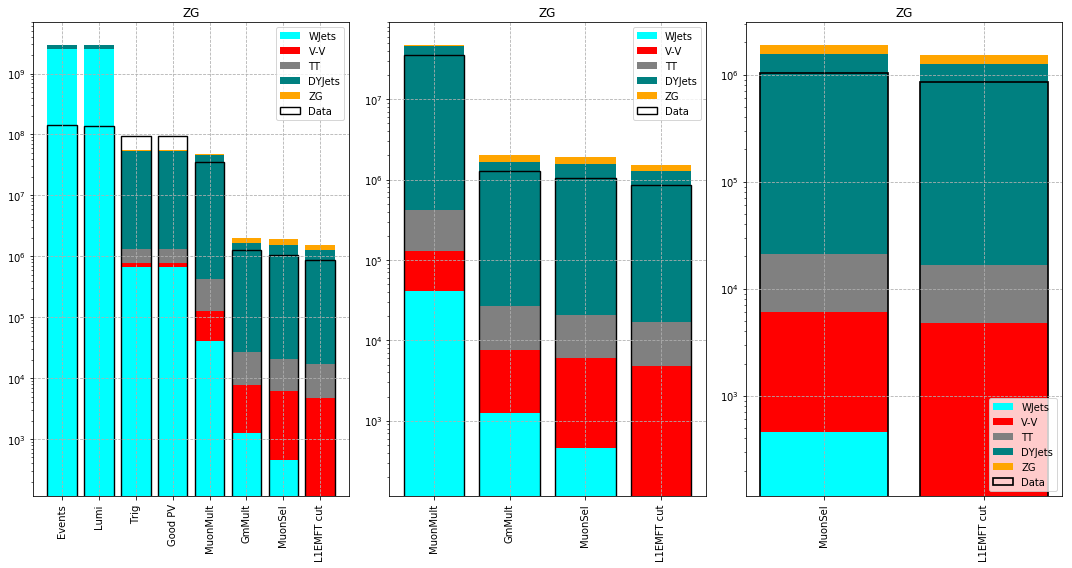

Cut Flow file generated in /home/jcordero/CMS/JYCMCMS/SMP_ZG/figs/2017/rereco/mumug/2020117/.
For more detailed info turn on the Print flag


In [48]:
CutFlow(log=True)
CSV_yields(figpath,Print=False)

In [49]:
ticks  = ['Events    ', 'Lumi      ','Trig      ','Good PV   ','MuonMult  ','GmMult    ','MuonSel   ', 'L1EMFT cut','GmSel     ','Same      ']
James = [6721, 13798, 6126 , 13728, 19592]

print('--------------')
print('            B       C          D         E        F')
for j in range(0,len(ticks)):
    print(ticks[j],[str(D.TotalEvent[j]) for D in DoubleLepton])
print('James     ',[str(j) for j in James])

--------------
            B       C          D         E        F
Events     ['0.0']
Lumi       ['11619716.0']
Trig       ['10875237.0']
Good PV    ['6446880.0']
MuonMult   ['6446879.0']
GmMult     ['3945222.0']
MuonSel    ['142144.0']
L1EMFT cut ['120122.0']
GmSel      ['98744.0']
Same       ['51185.0']
James      ['6721', '13798', '6126', '13728', '19592']


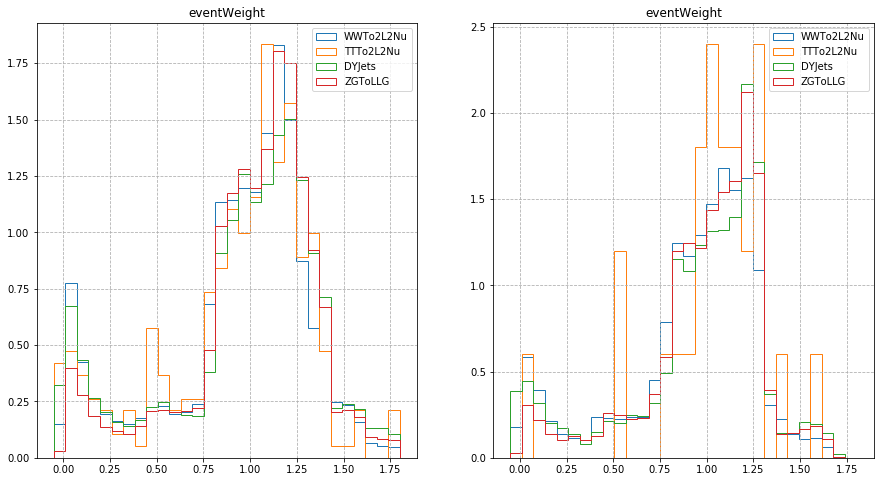

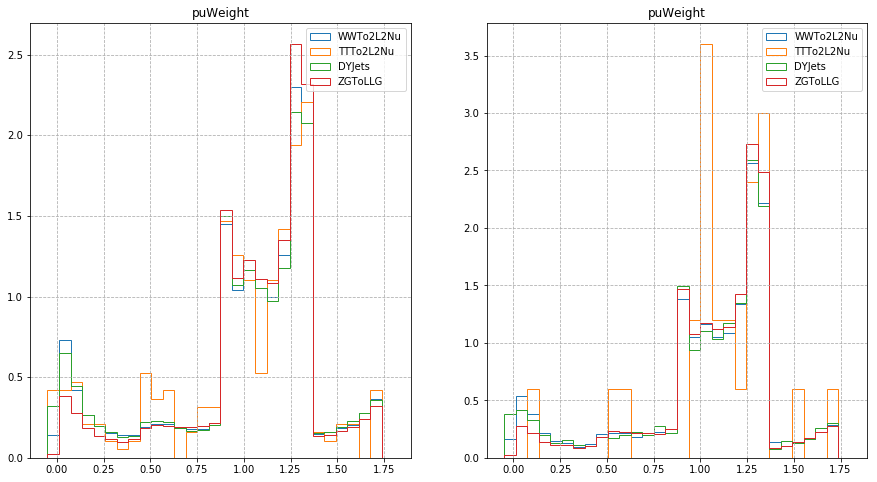

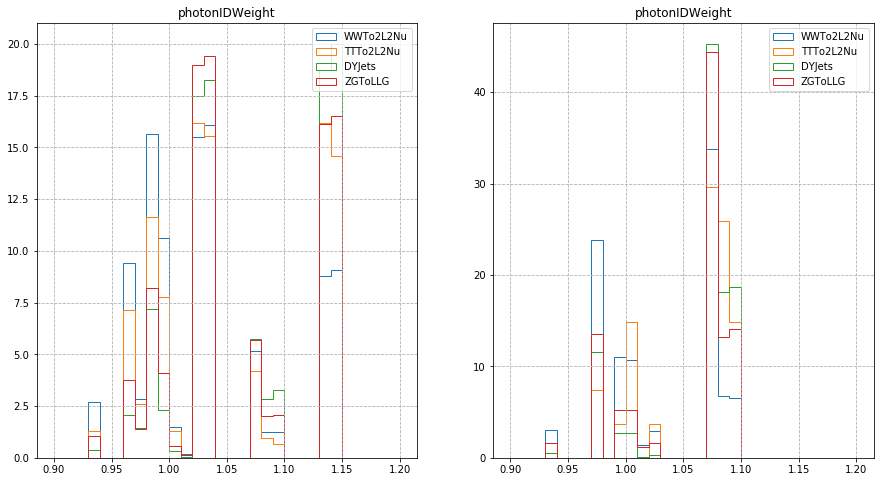

In [50]:
#WEIGHT = ['genWeight','eventWeight','puWeight','triggerWeight','photonIDWeight']
WEIGHT = ['eventWeight','puWeight','photonIDWeight']
for w in WEIGHT:
    if w == 'photonIDWeight':
        ranges = [0.9,1.2]
    else:
        ranges = [-0.05,1.5+0.3]
        
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)
    for d in data[1:-1]:
        plt.hist(
                d.GetWithCuts(w)[np.abs(d.GetWithCuts('photonOneEta')) < 2 ],
                histtype = 'step',
                range    = ranges,
                bins     = 30,
                label    = d.name,
                normed = True,
                )
    plt.title(w)
    plt.grid(linestyle='--')
    plt.legend()
        
    plt.subplot(1,2,2)
    for d in data[1:-1]:
        plt.hist(
                d.GetWithCuts(w)[np.abs(d.GetWithCuts('photonOneEta')) >= 2 ],
                histtype = 'step',
                range    = ranges,
                bins     = 30,
                label    = d.name,
                normed = True,
                )
    plt.title(w)
    plt.grid(linestyle='--')
    plt.legend()

In [51]:

for w in WEIGHT:
    Eta = {}
    Eta['less'],Eta['big'] = [],[]
    for d in data[1:-1]:
        Eta['less'].append(np.mean(d.GetWithCuts(w)[np.abs(d.GetWithCuts('photonOneEta')) < 2 ]))

    for d in data[1:-1]:
        Eta['big'].append(np.mean(d.GetWithCuts(w)[np.abs(d.GetWithCuts('photonOneEta')) >= 2 ]))
    big,less = np.mean(Eta['big']),np.mean(Eta['less'])
    print(w,big,less,(big-less)/less)

eventWeight 0.97855353 0.9604719 0.01882575
puWeight 1.0610557 1.0140469 0.046357572
photonIDWeight 1.0506012 1.0538895 -0.003120127


In [52]:
def TestMatching(d,part1,part2,Plot=False):
    DEta = np.abs(d.GetWithCuts(part1+"Eta") - d.GetWithCuts(part2+"Eta"))
    DPhi = d.GetWithCuts(part1+"Phi") - d.GetWithCuts(part2+"Phi")
    DPhi[DPhi>np.pi] = 2*np.pi - DPhi[DPhi>np.pi]
    DR = np.sqrt(DEta**2 + DPhi**2)
    
    if Plot:
        plt.hist(DR,
            range = [0,1],
            bins = 20,
            );
    
    return DR

In [53]:
d = DYJets
part1,part2 ="genPhoton","photonOne"
DR = TestMatching(d,part1,part2)
print(np.sum(DR < 0.4),round(np.sum(DR < 0.4)/len(DR),2)*100)

part1,part2 ="genPhoton","leptonOne"
DR = TestMatching(d,part1,part2)
print(np.sum(DR < 0.4),round(np.sum(DR < 0.4)/len(DR),2)*100)

part1,part2 ="genPhoton","leptonTwo"
DR = TestMatching(d,part1,part2)
print(np.sum(DR < 0.4),round(np.sum(DR < 0.4)/len(DR),2)*100)

12238 42.0
3913 14.000000000000002
4014 14.000000000000002


In [54]:
'''
var = ['Pt']
part = ['genPhoton']
for p in part:
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot(
            data,
            var              = v,
            part             = p,
            signalInclude    = True,
            stacked          = stacked,
            density          = density,
            log              = log,
            weightCorrection = weightCorrection,
            Blind            = Blind,
            Plotting         = Plotting,
            StatInclude      = StatInclude,
            )  
''' ;

# TEST

----------------nPV----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: Runti

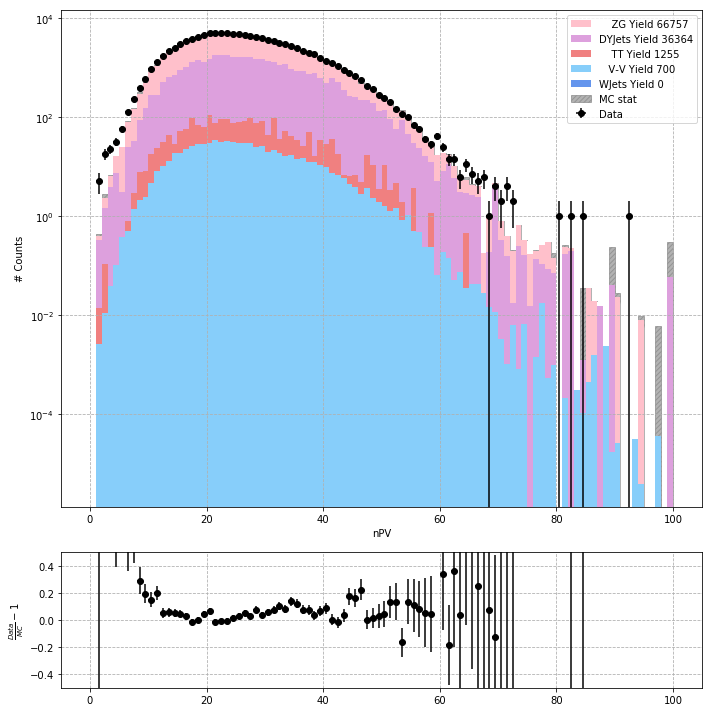

----------------nJets----------------


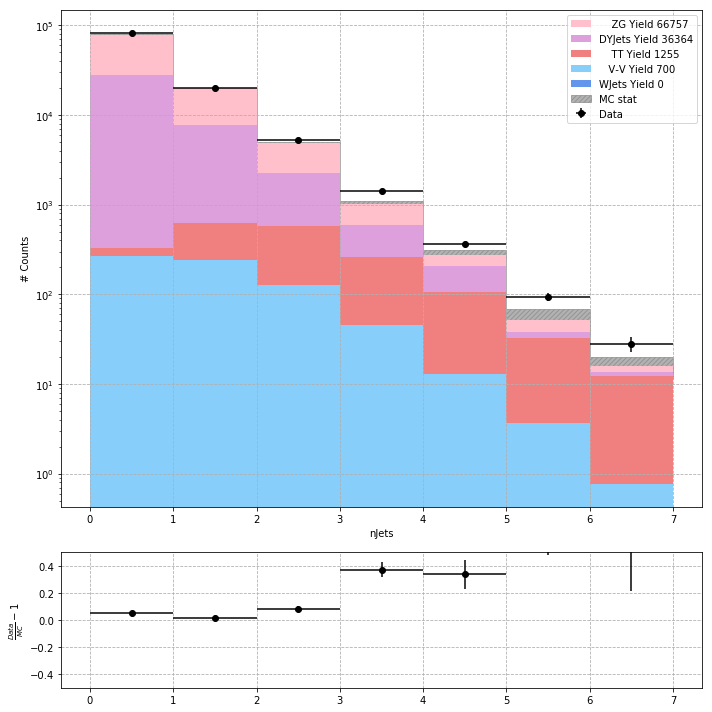

----------------nPhotons----------------


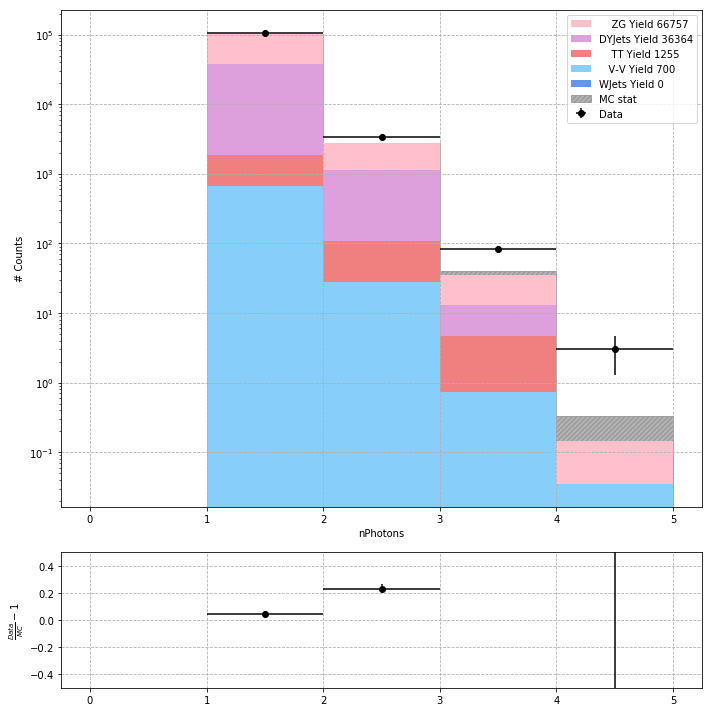

----------------met----------------


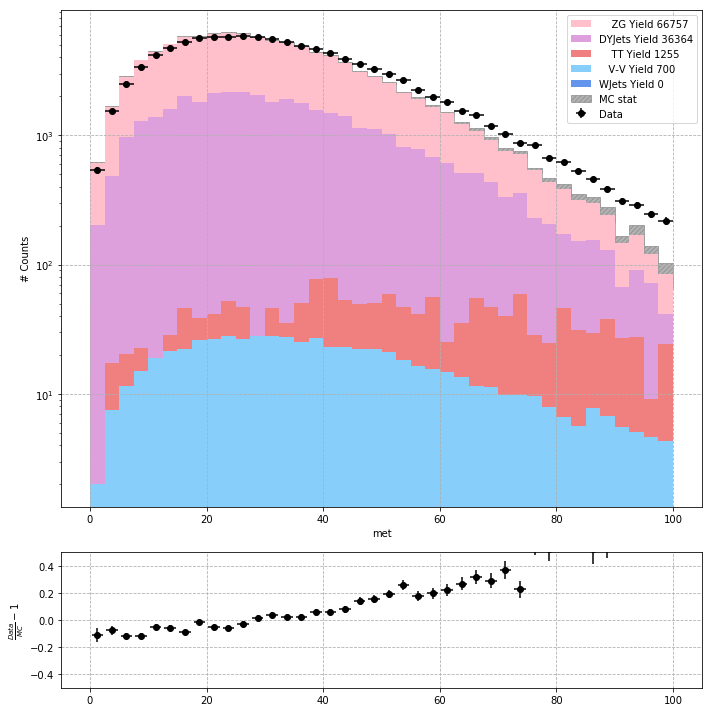

----------------Eta----------------


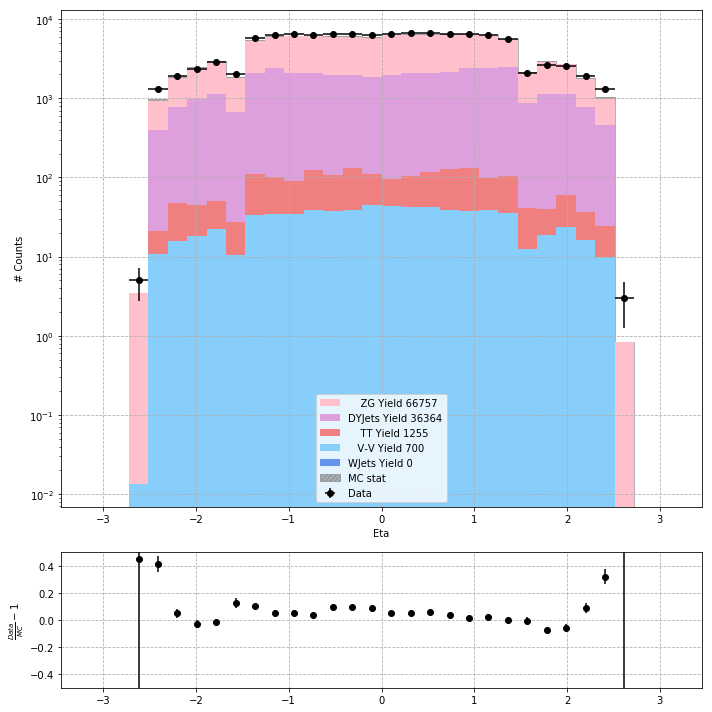

In [55]:
#log = False
log = True
###############################    
if log:
    stackFol = Fol+'/log'
else:
    stackFol = Fol+'/linear'
###############################
var = ['nPV','nJets','nPhotons','met']
for v in var:
    print('----------------'+str(v)+'----------------')
    Plot(
        data,
        var              = v,
        part             = '',
        signalInclude    = True,
        stacked          = stacked,
        density          = density,
        log              = log,
        weightCorrection = weightCorrection,
        Blind            = Blind,
        Plotting         = Plotting,
        StatInclude      = StatInclude,
        )

var = ['Eta']
part = ['photonOne']
for p in part:
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot(
            data,
            var              = v,
            part             = p,
            signalInclude    = True,
            stacked          = stacked,
            density          = density,
            log              = log,
            weightCorrection = weightCorrection,
            Blind            = Blind,
            Plotting         = Plotting,
            StatInclude      = StatInclude, 
            )


    



----------------M----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


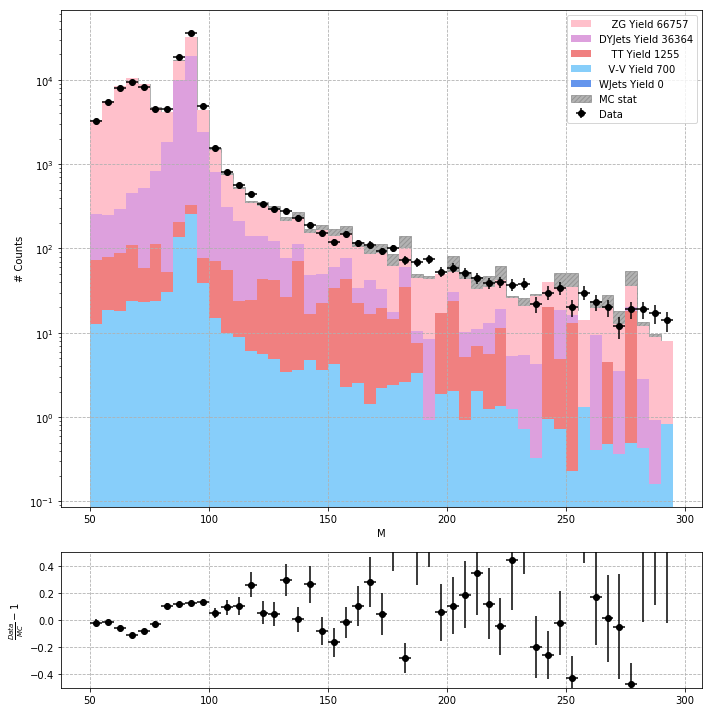

----------------M----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


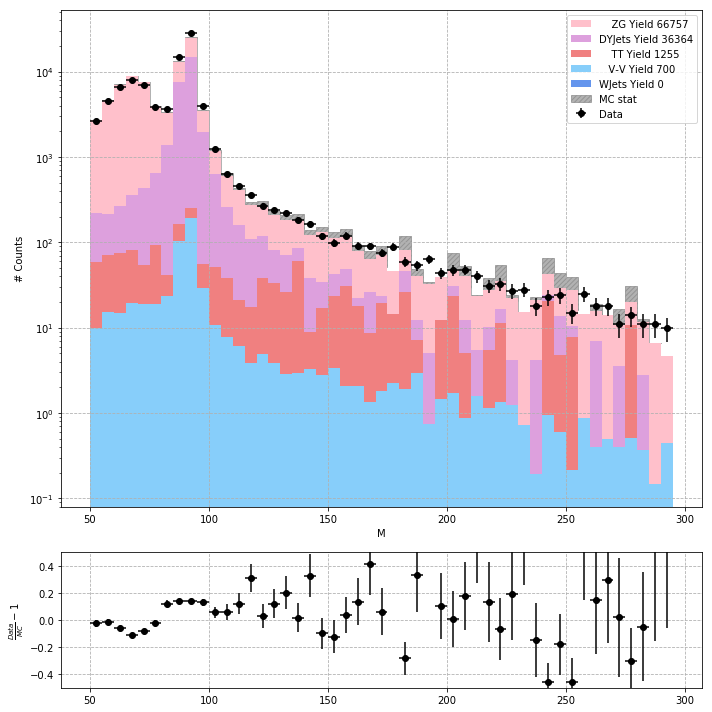

----------------M----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


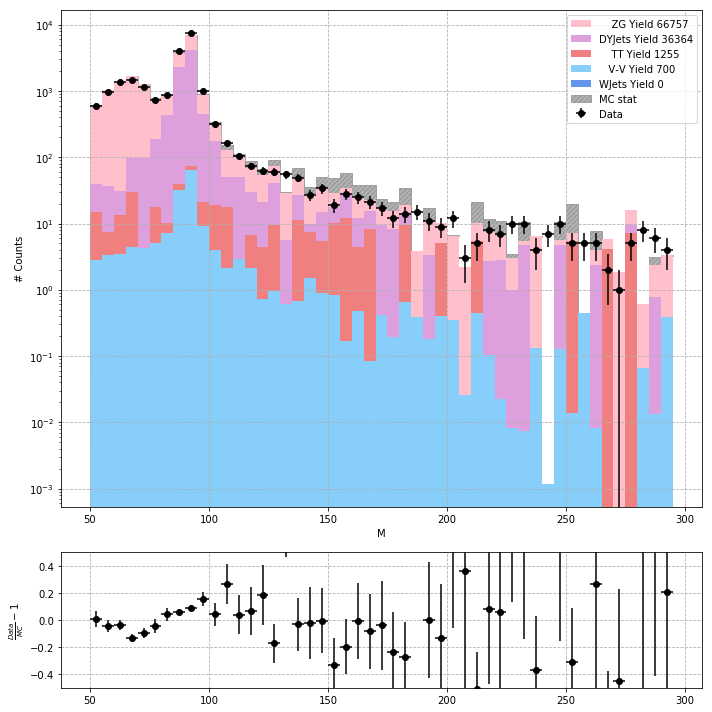

----------------M----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


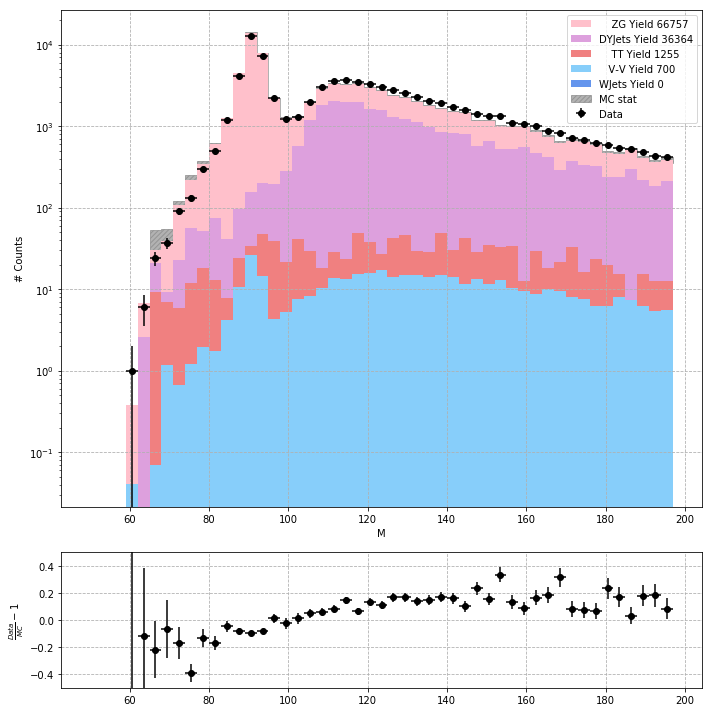

----------------M----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


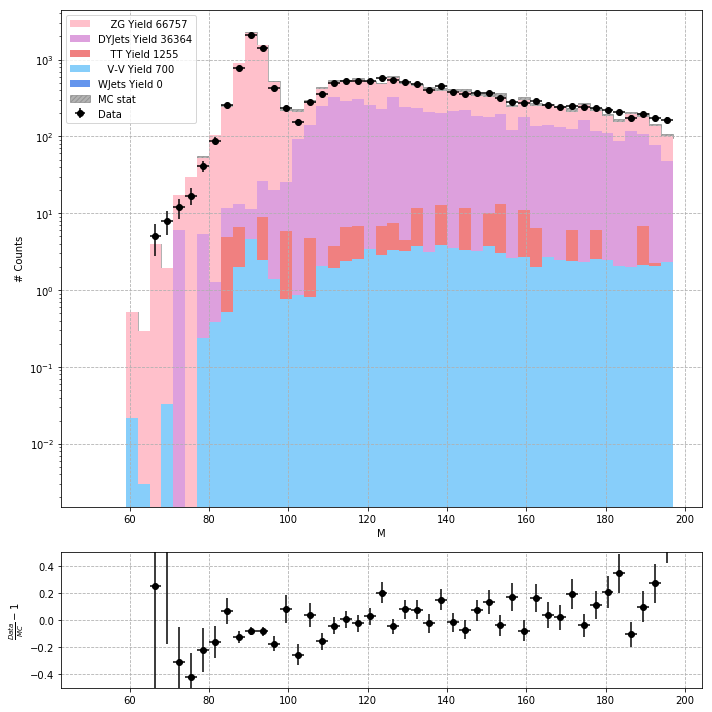

In [56]:
var = ['M']
part = ['dilepton','dilepton_EB','dilepton_EE','llg_EB','llg_EE']
for p in part:
    for v in var:
        print('----------------'+str(v)+'----------------')
        Plot(
            data,
            var              = v,
            part             = p,
            signalInclude    = True,
            stacked          = stacked,
            density          = density,
            log              = log,
            weightCorrection = weightCorrection,
            Blind            = Blind,
            Plotting         = Plotting,
            StatInclude      = StatInclude,
            )   

----------------Pt----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


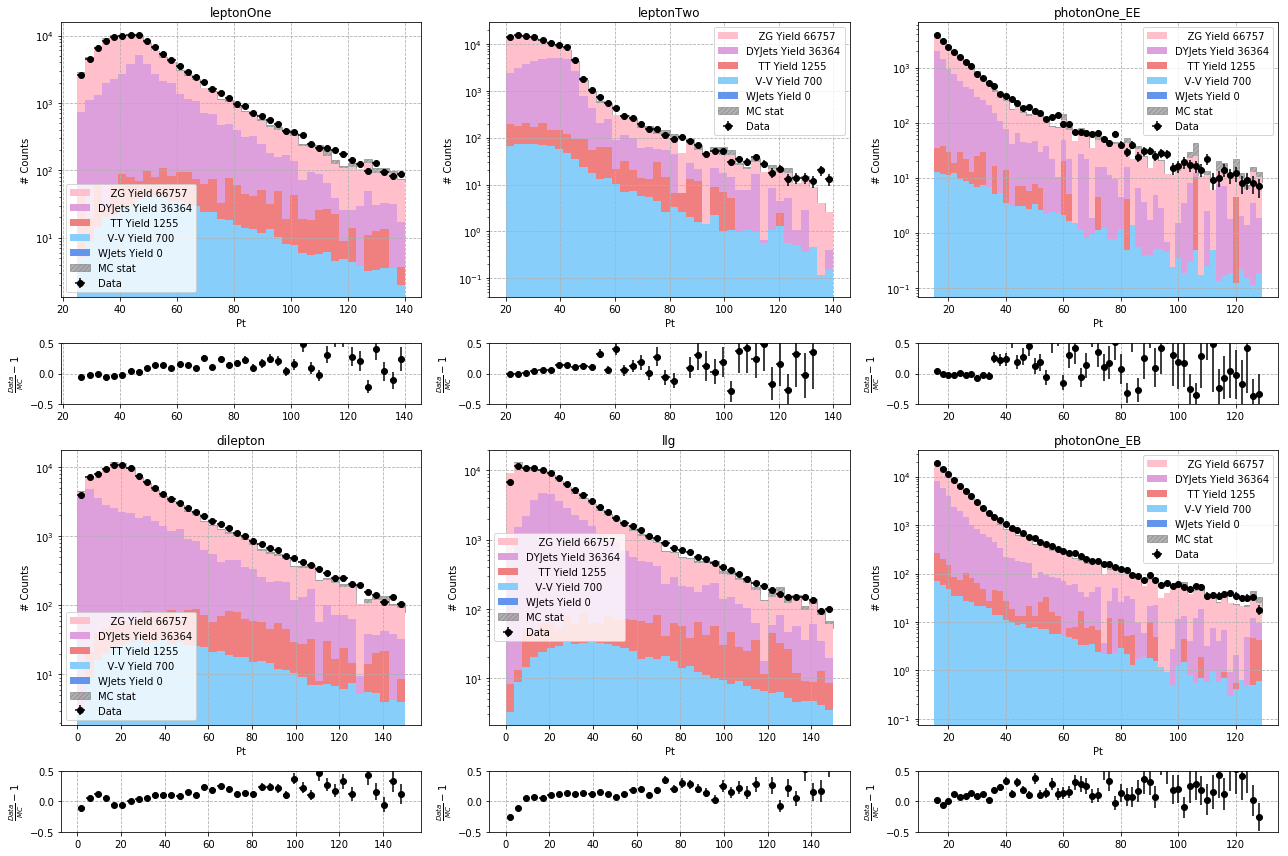

----------------M----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


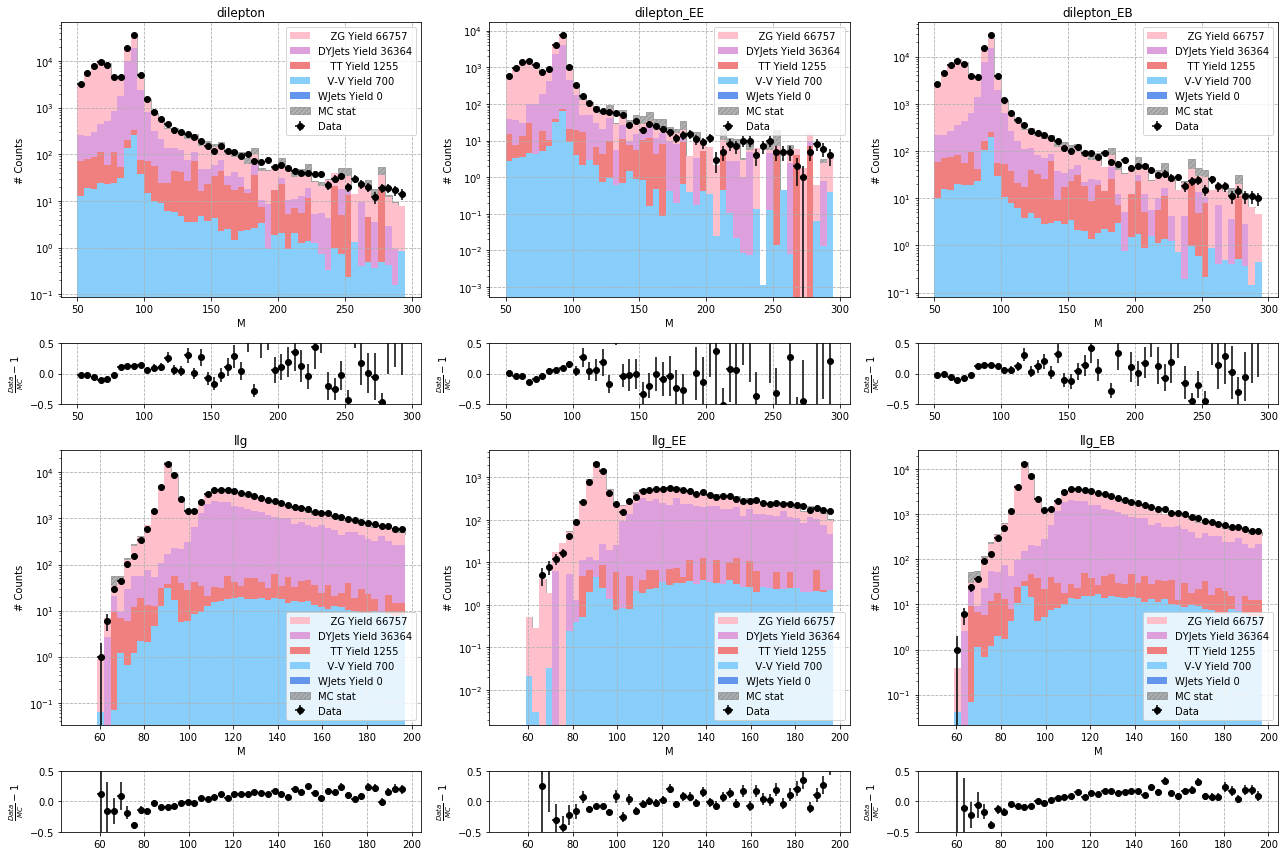

In [57]:
var = ['Pt']
part = ['leptonOne','leptonTwo','photonOne_EE','dilepton','llg','photonOne_EB']

for v in var:
    print('----------------'+str(v)+'----------------')
    Plot_Mult(
              data,
              var              = v,
              part             = part,
              signalInclude    = True,
              figDim           = [2,3],
              customRange      = customRange,
              stacked          = stacked,
              log              = log,
              weightCorrection = weightCorrection,
              Blind            = Blind,
              #Blind            = False,
              Plotting         = Plotting,
              StatInclude      = StatInclude,
             )

var = ['M']    
part = ['dilepton','dilepton_EE','dilepton_EB','llg','llg_EE','llg_EB']
for v in var:
    print('----------------'+str(v)+'----------------')
    Plot_Mult(
              data,        
              var              = v,
              part             = part,
              signalInclude    = True,
              figDim           = [2,3],
              customRange      = customRange,
              stacked          = stacked,
              log              = log,
              weightCorrection = weightCorrection,
              Blind            = Blind,              
              Plotting         = Plotting,
              StatInclude      = StatInclude,
             ) 

----------------Ich----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


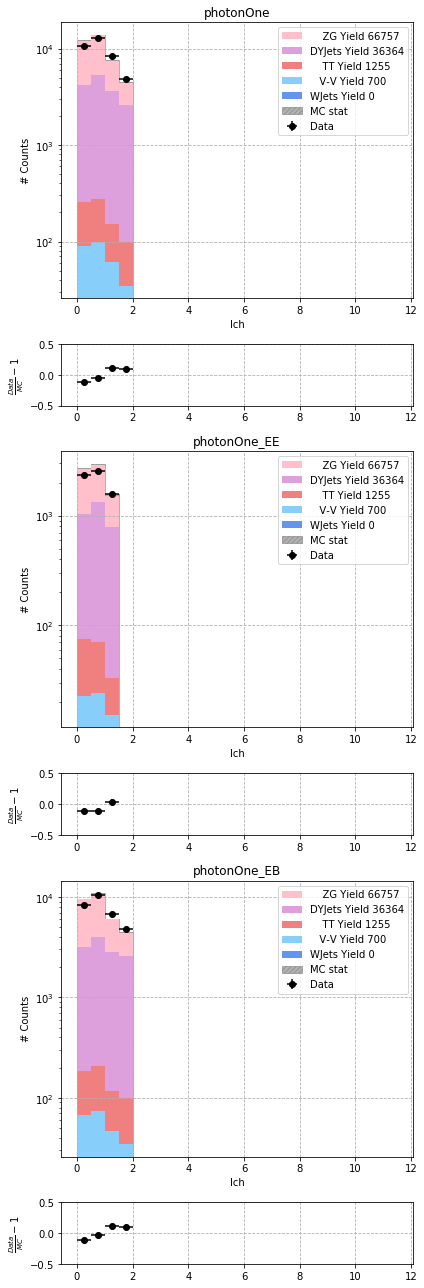

----------------Ineu----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


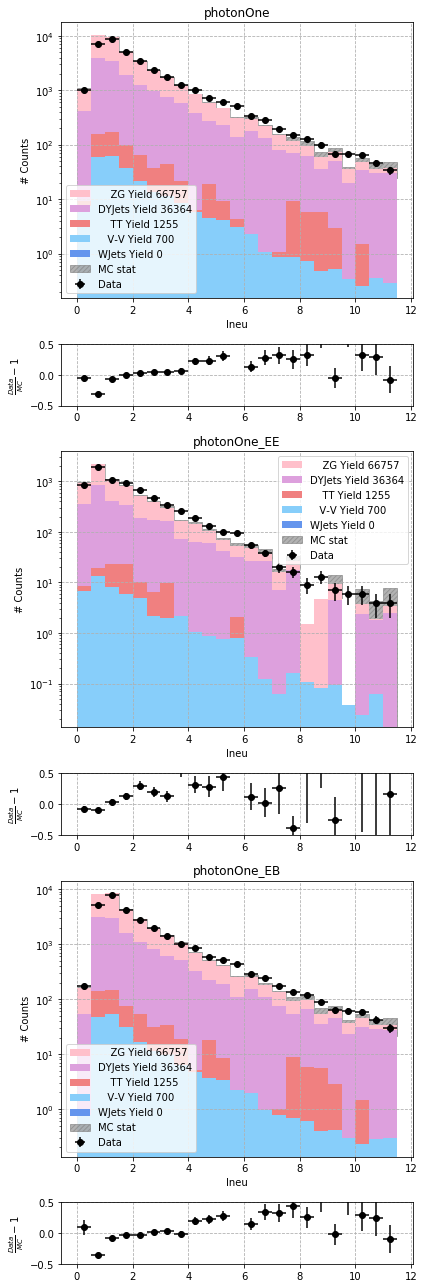

----------------Iph----------------


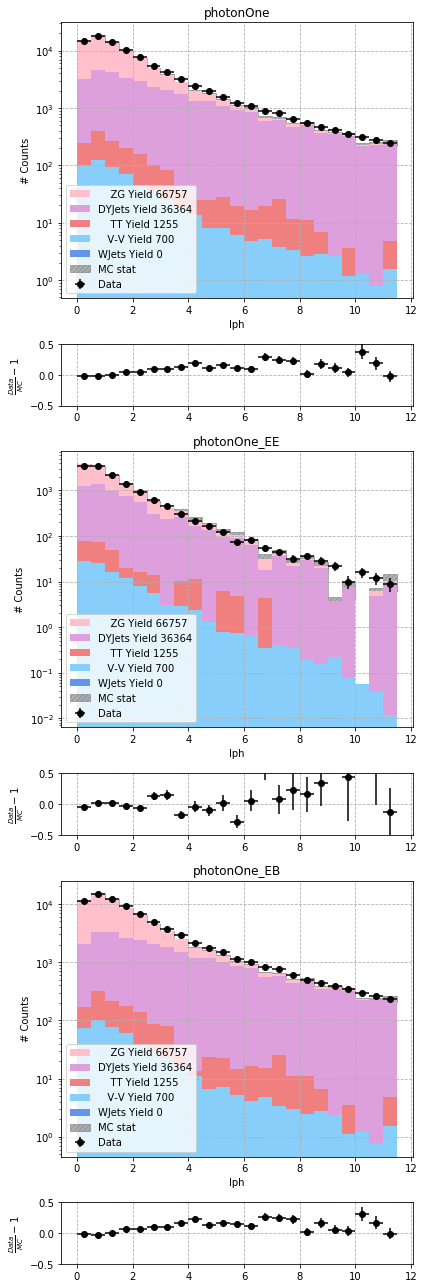

----------------Sieie----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


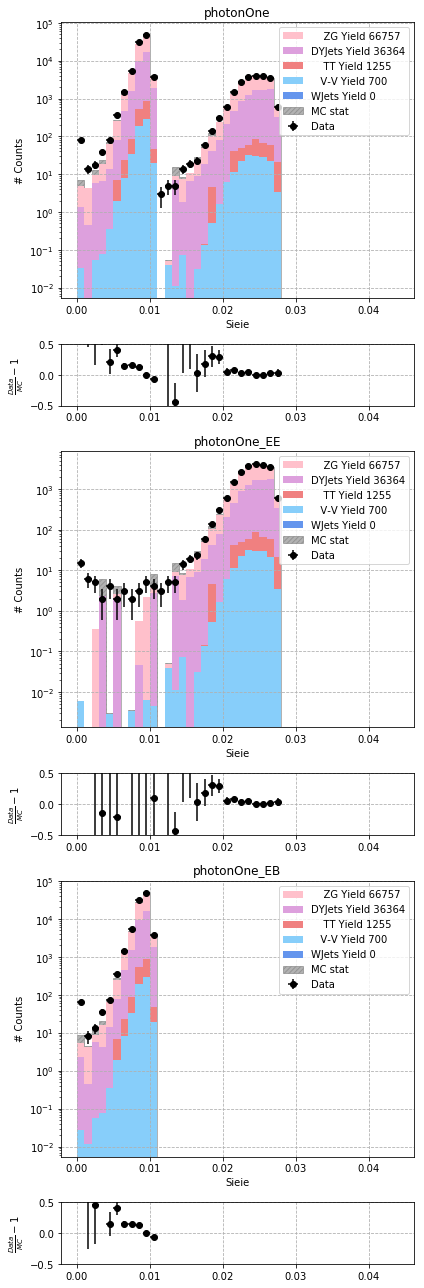

In [58]:
var = ['Ich','Ineu','Iph','Sieie']
part = ['photonOne','photonOne_EE','photonOne_EB']    
for v in var:
    print('----------------'+str(v)+'----------------')
    Plot_Mult(
              data,            
              var              = v,
              part             = part,
              signalInclude    = True,
              figDim           = [3,1],
              customRange      = customRange,
              stacked          = stacked,
              log              = log,
              weightCorrection = weightCorrection,
              Plotting         = Plotting,
              StatInclude      = StatInclude,
             )

In [63]:
vetoCount = np.sum(DYJets.df.vetoDY)
Total = DYJets.N()
print(Total)
#DYJets.sampLength
print(vetoCount)
print(vetoCount/Total*100)

123450272.0
102103
0.08270779670700118


# Single Graphs

----------------nJets----------------


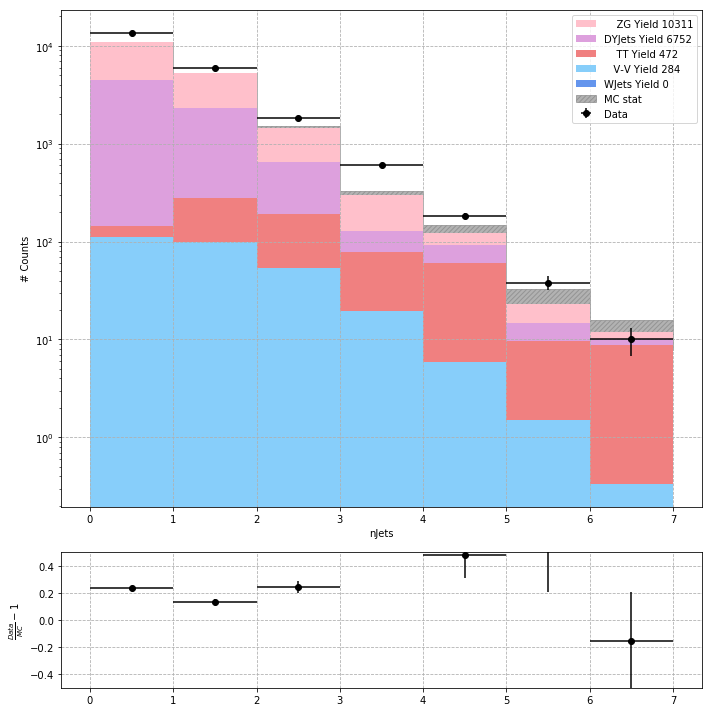

----------------nMuons----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


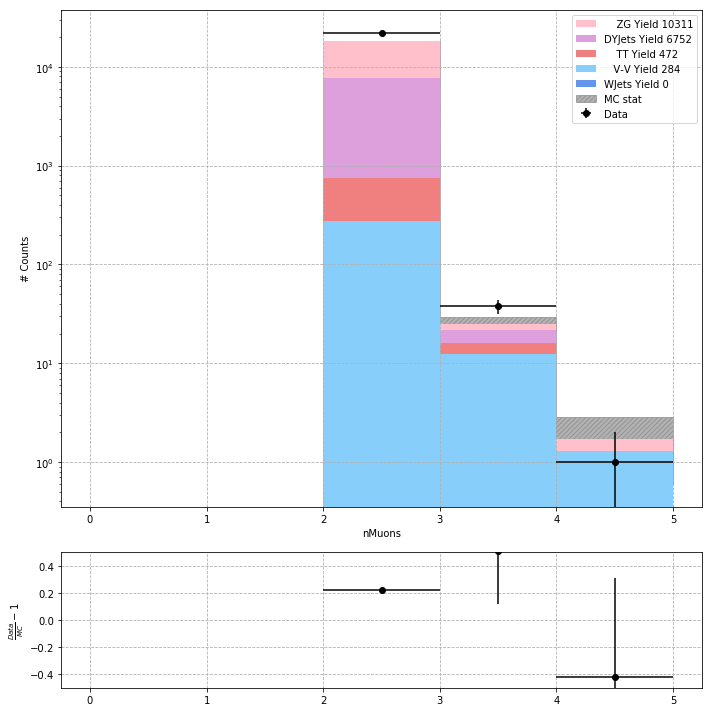

----------------nPhotons----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


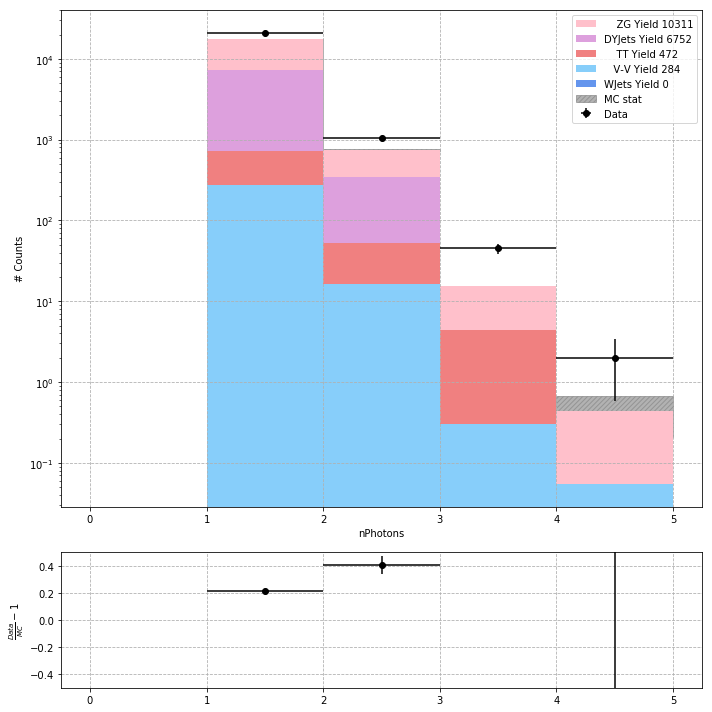

----------------met----------------


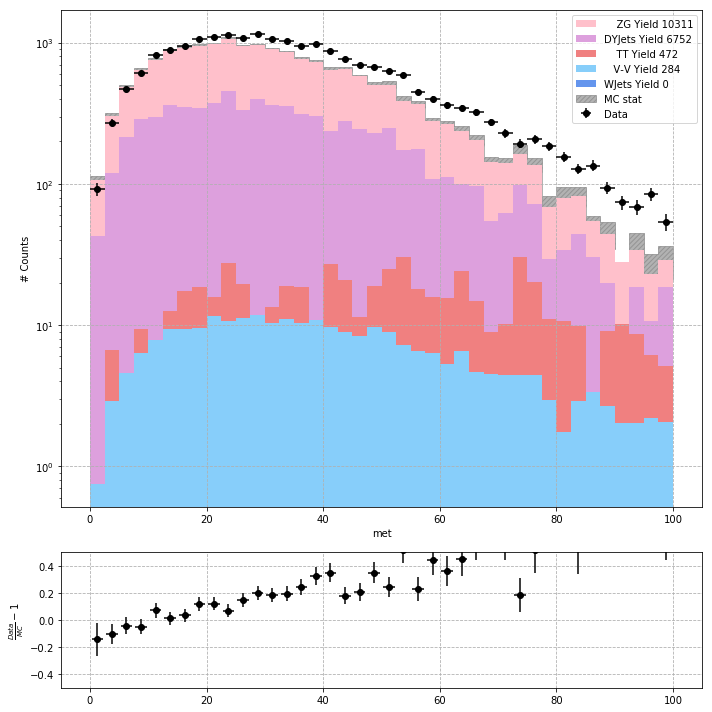

----------------leptonOnePt----------------


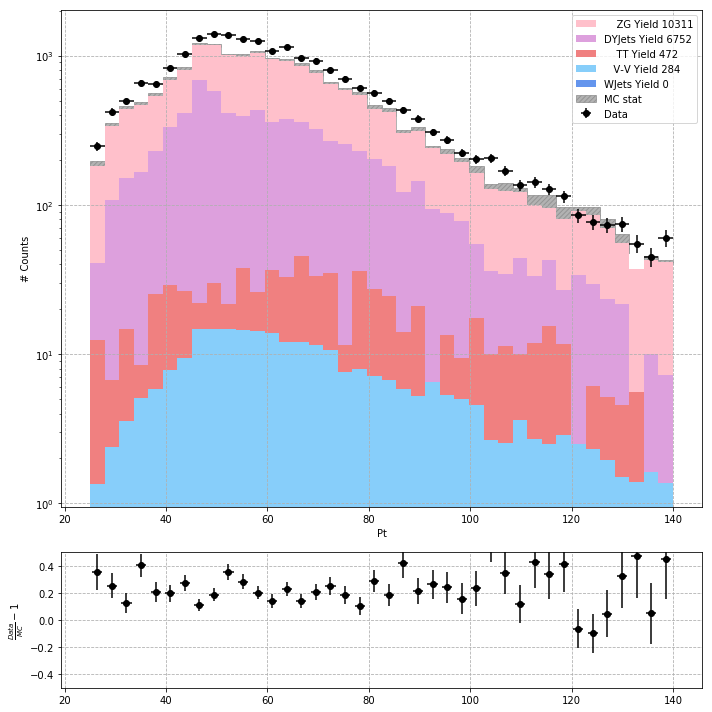

----------------leptonOnePhi----------------


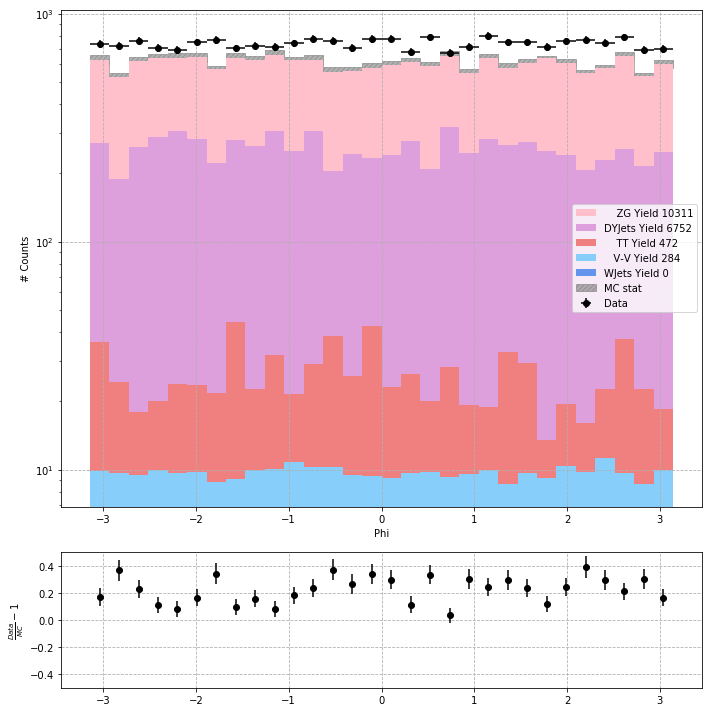

----------------leptonOneEta----------------


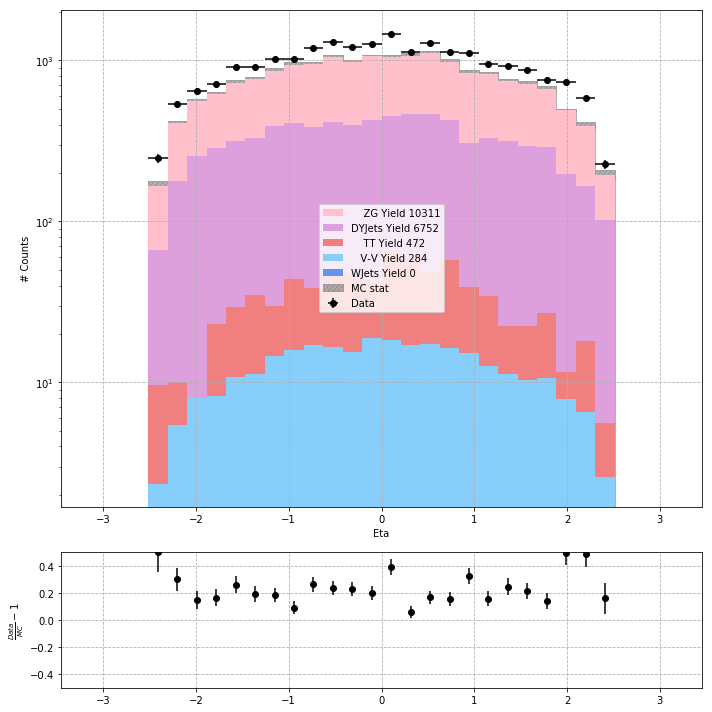

----------------leptonOne_EEPt----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


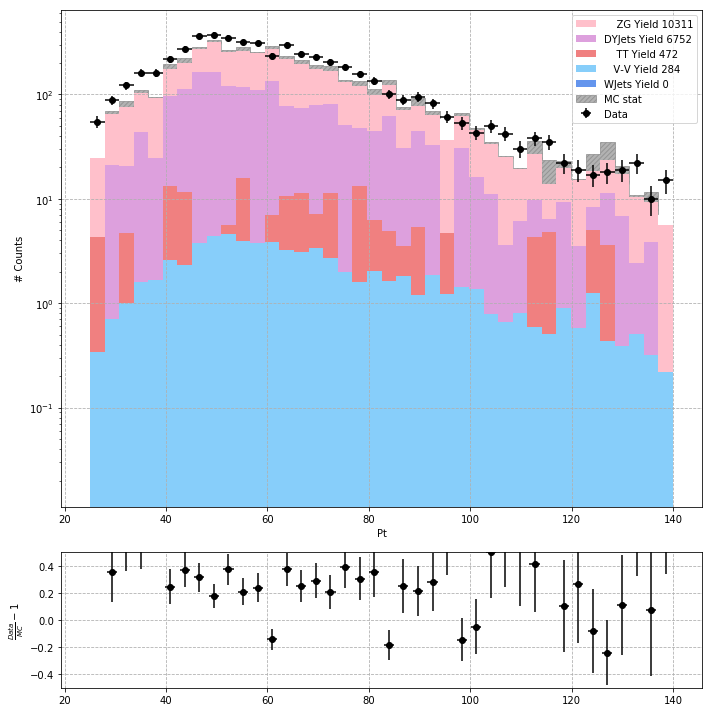

----------------leptonOne_EEPhi----------------


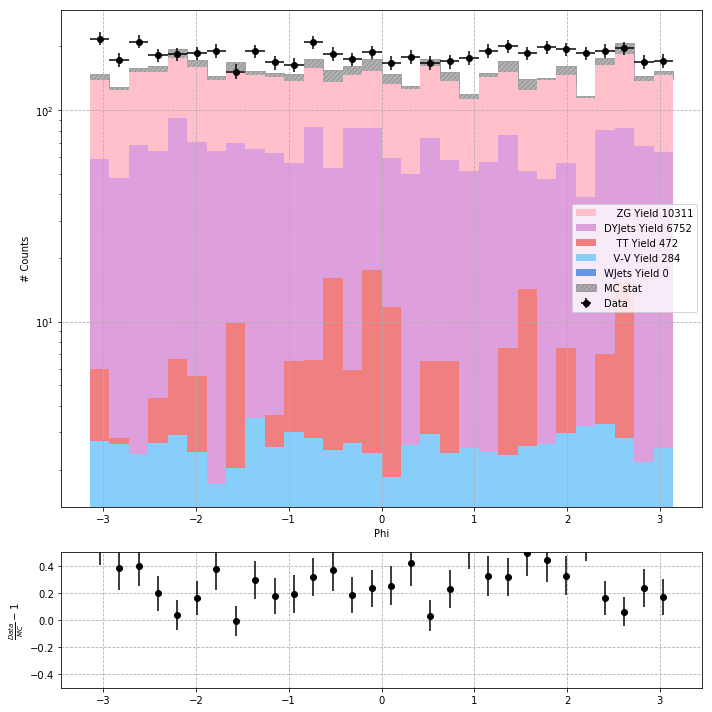

----------------leptonOne_EEEta----------------


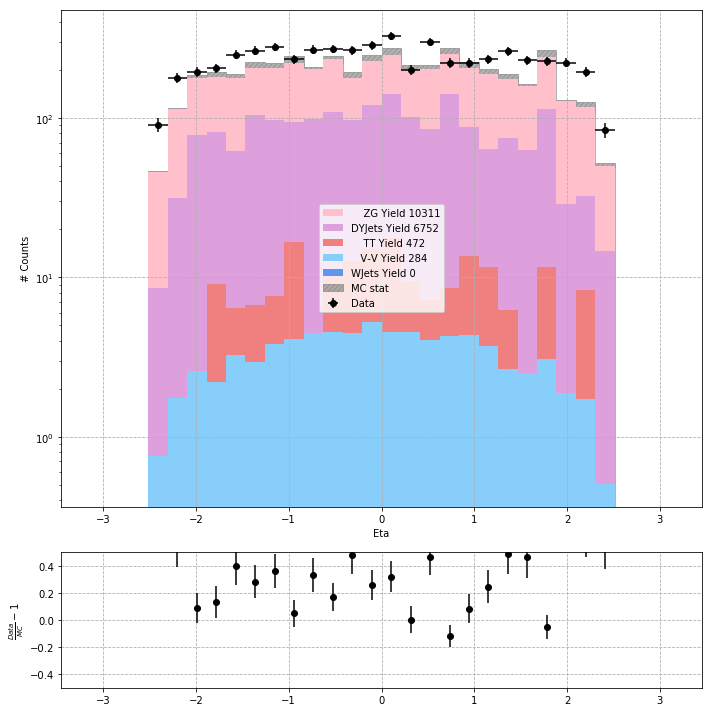

----------------leptonOne_EBPt----------------


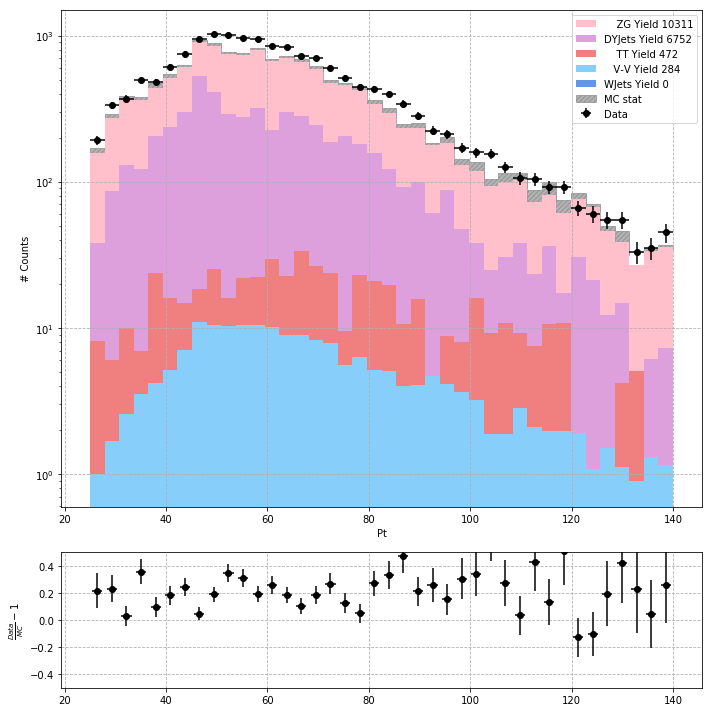

----------------leptonOne_EBPhi----------------


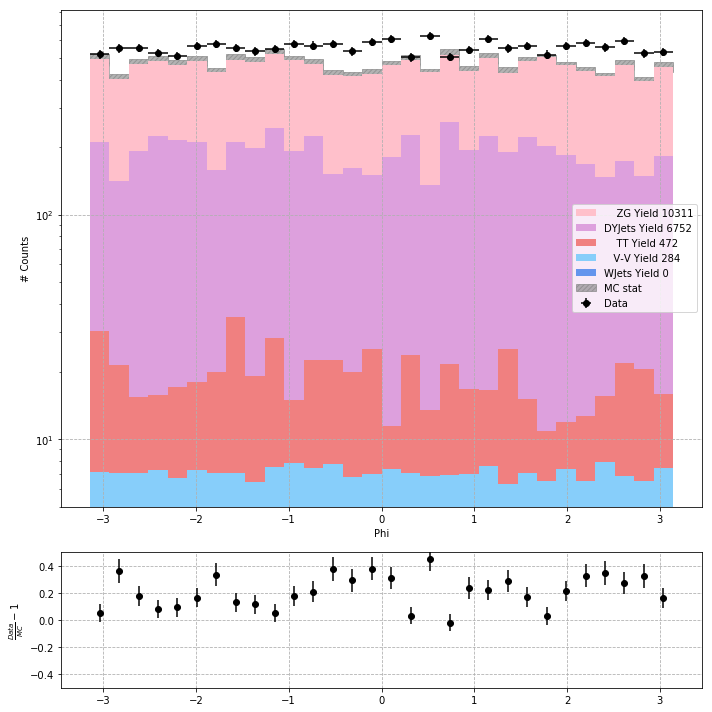

----------------leptonOne_EBEta----------------


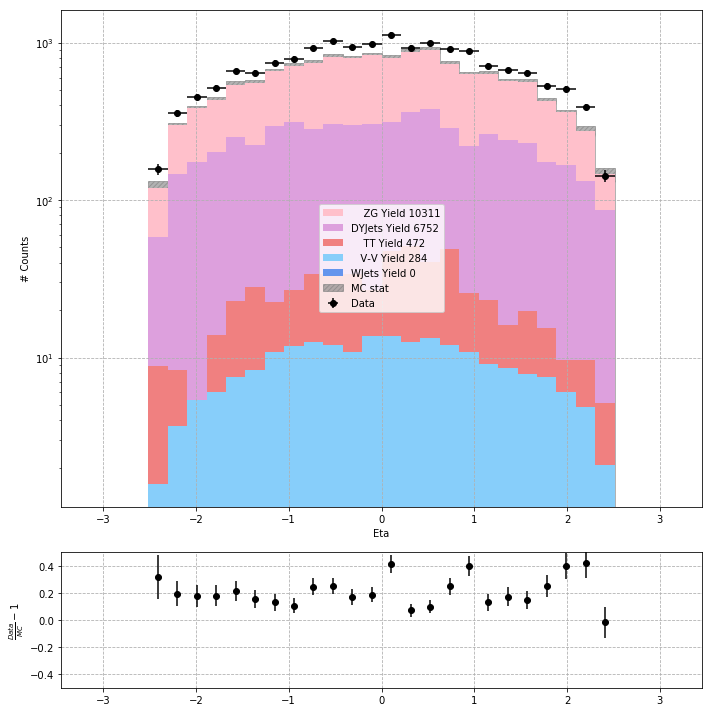

----------------leptonTwoPt----------------


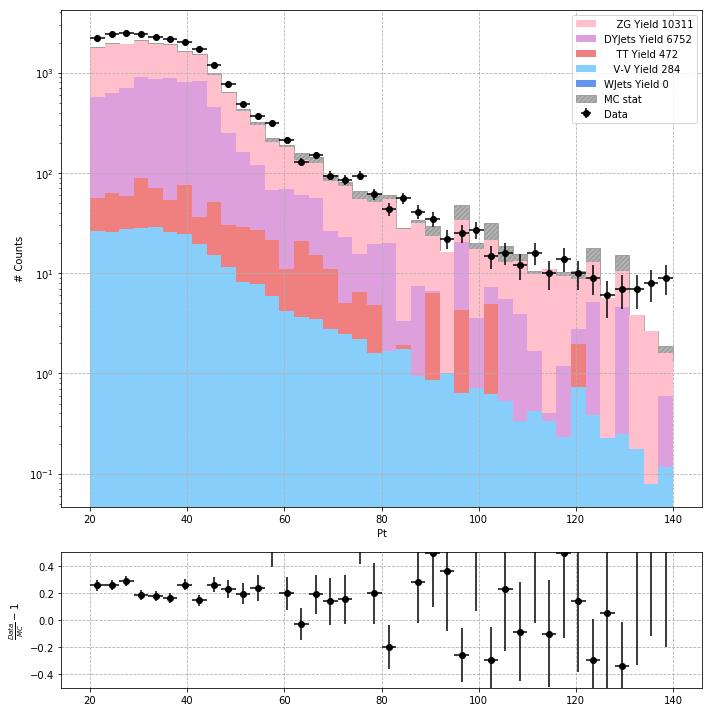

----------------leptonTwoPhi----------------


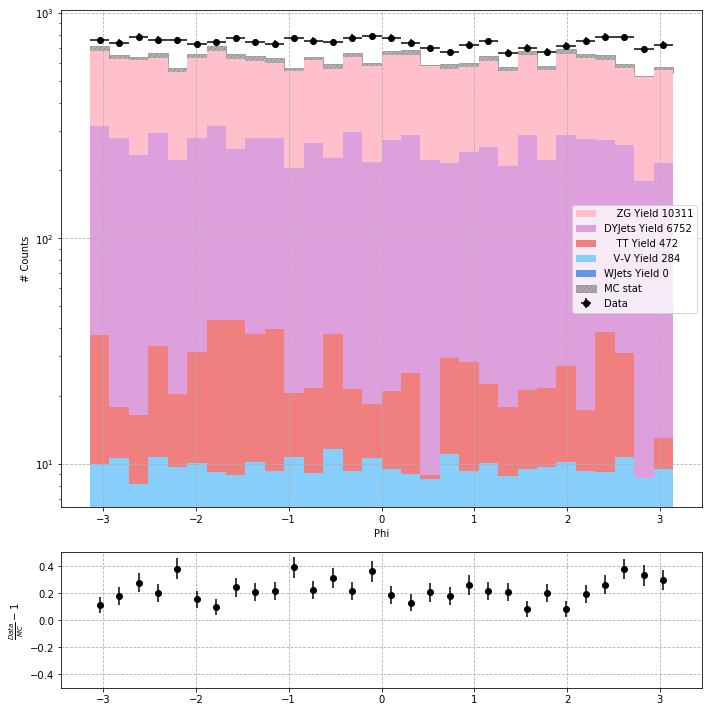

----------------leptonTwoEta----------------


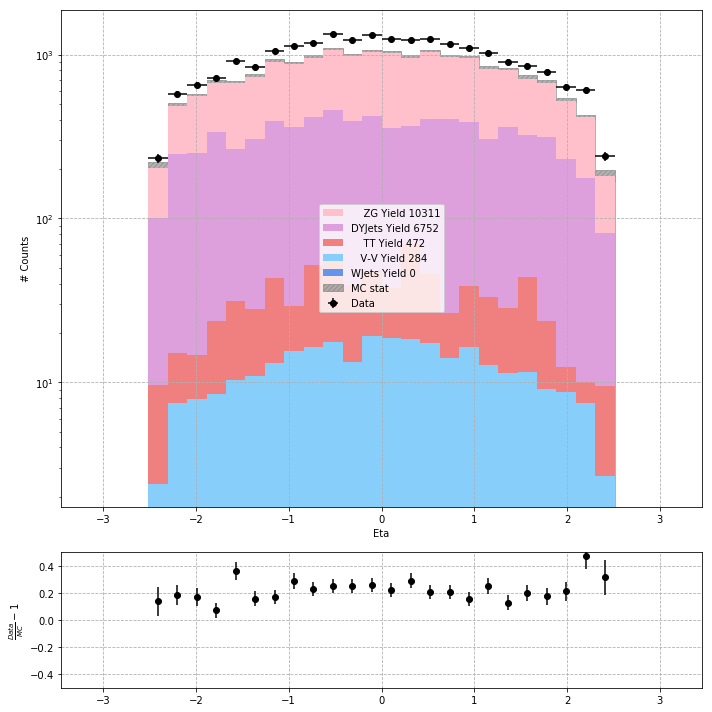

----------------leptonTwo_EEPt----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


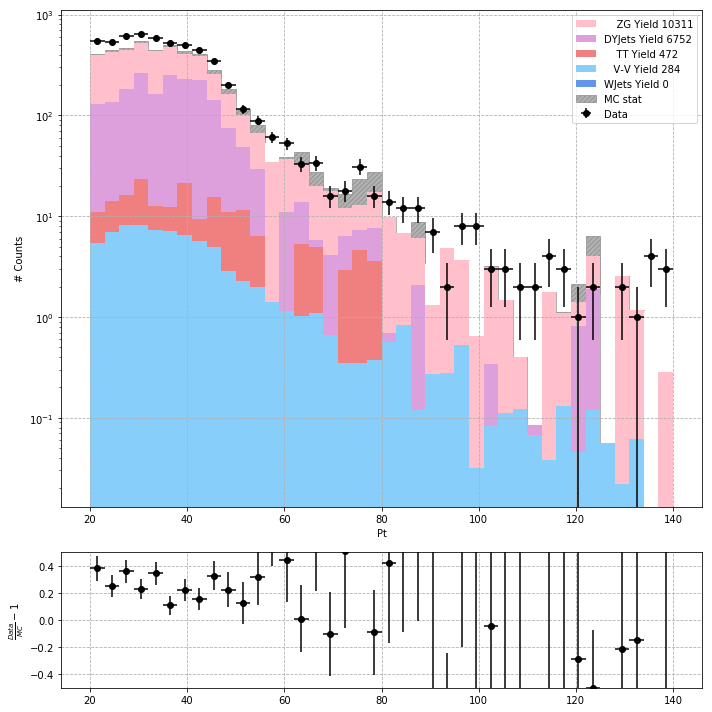

----------------leptonTwo_EEPhi----------------


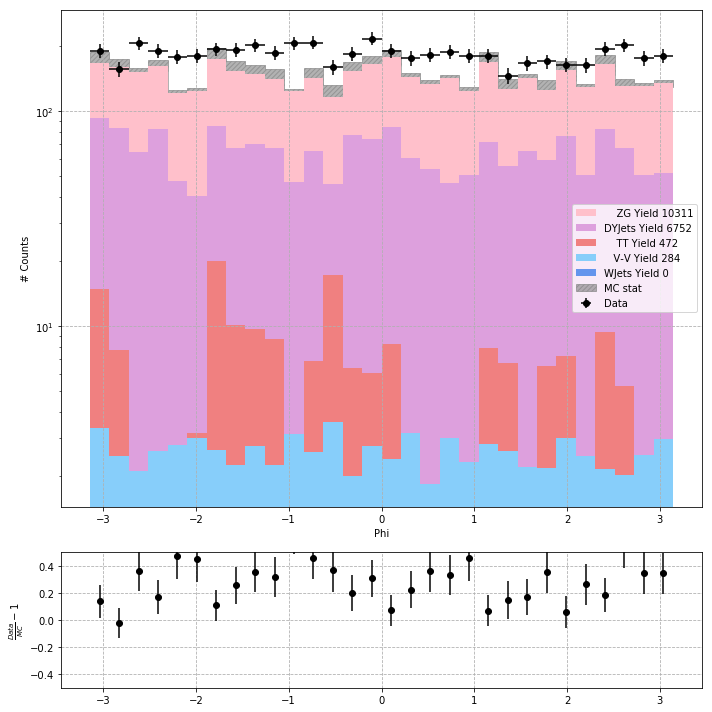

----------------leptonTwo_EEEta----------------


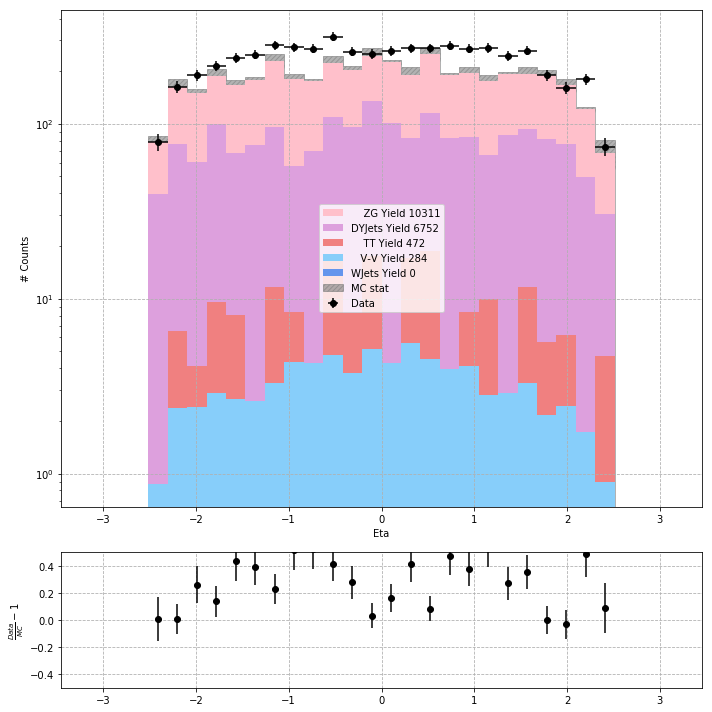

----------------leptonTwo_EBPt----------------


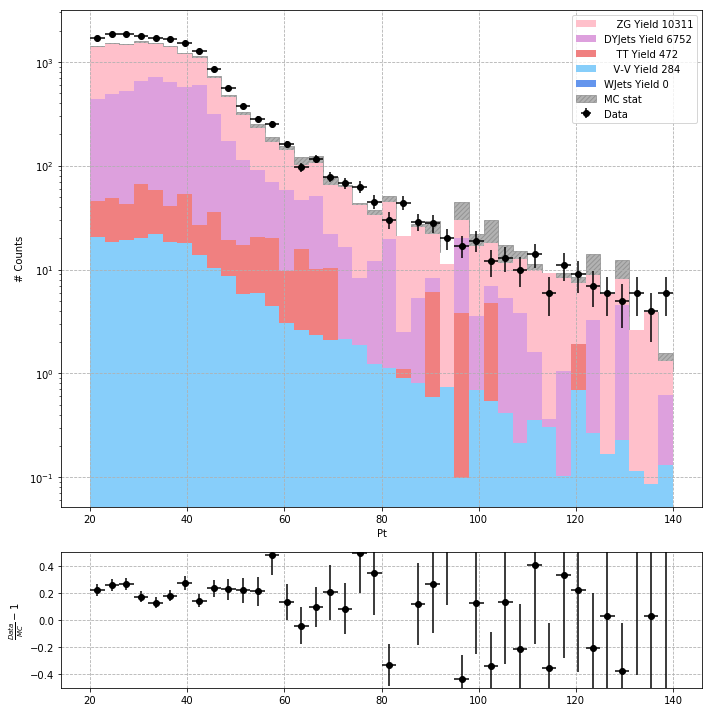

----------------leptonTwo_EBPhi----------------


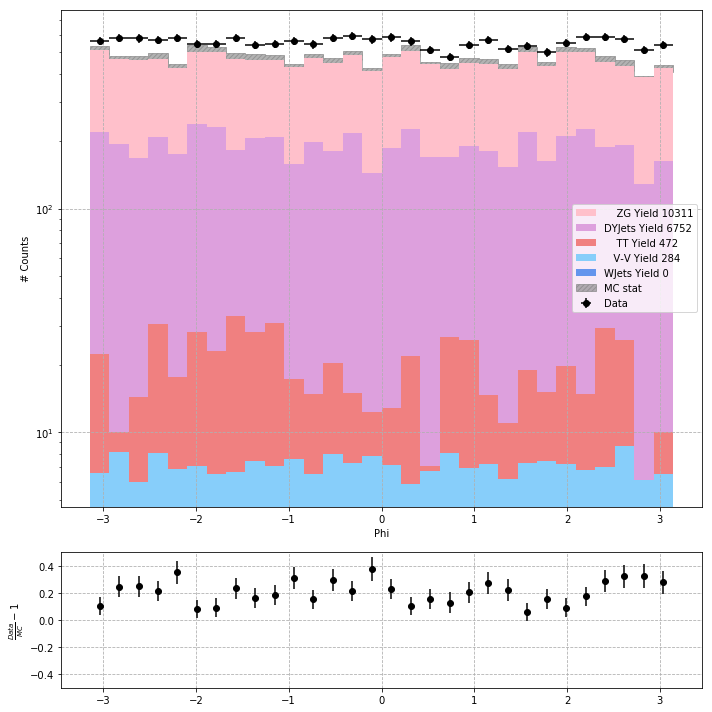

----------------leptonTwo_EBEta----------------


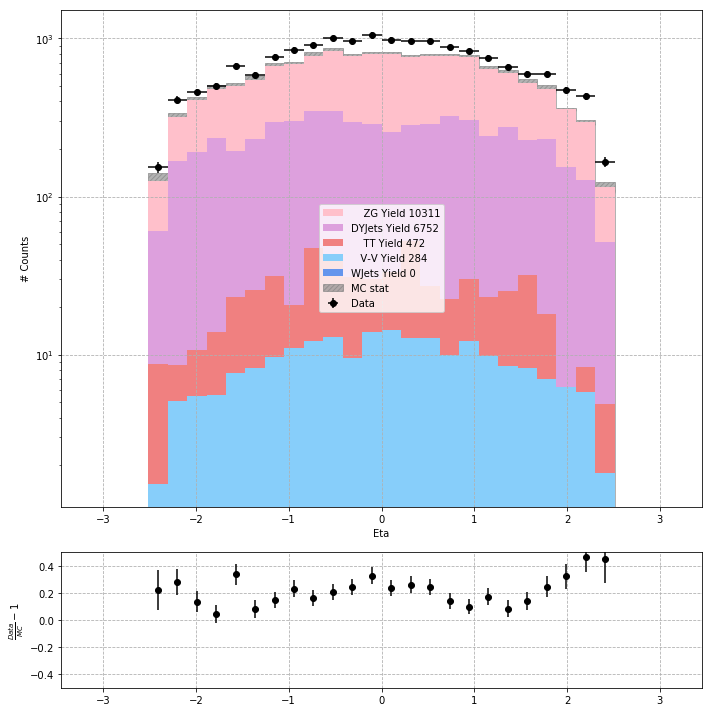

----------------photonOnePt----------------


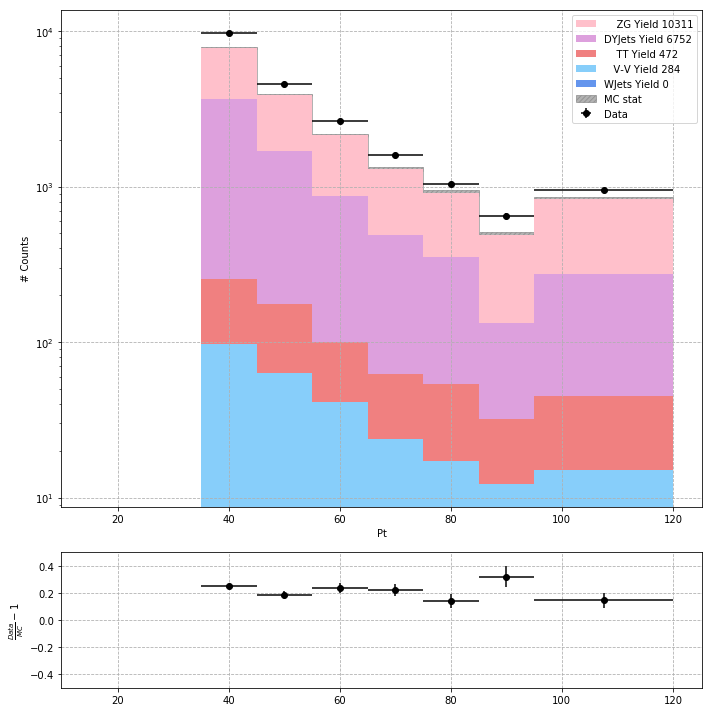

----------------photonOnePhi----------------


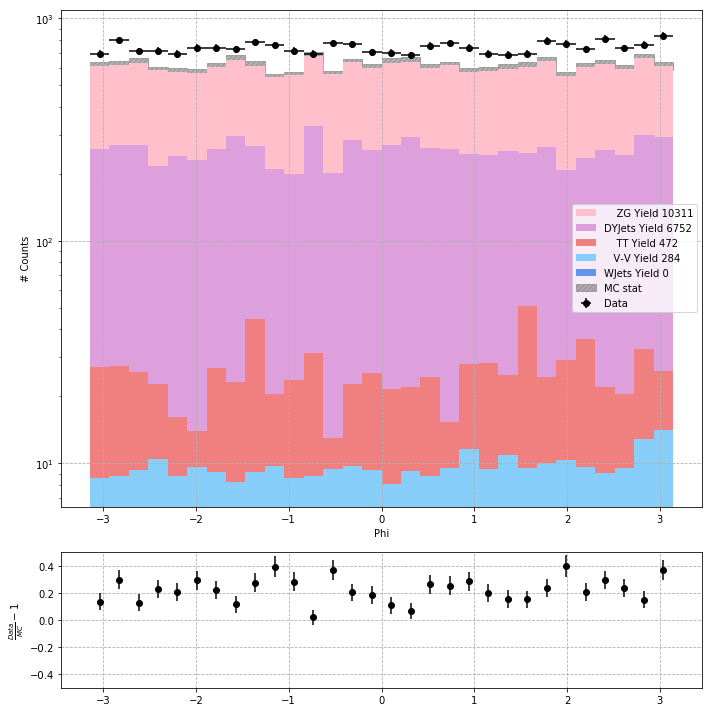

----------------photonOneEta----------------


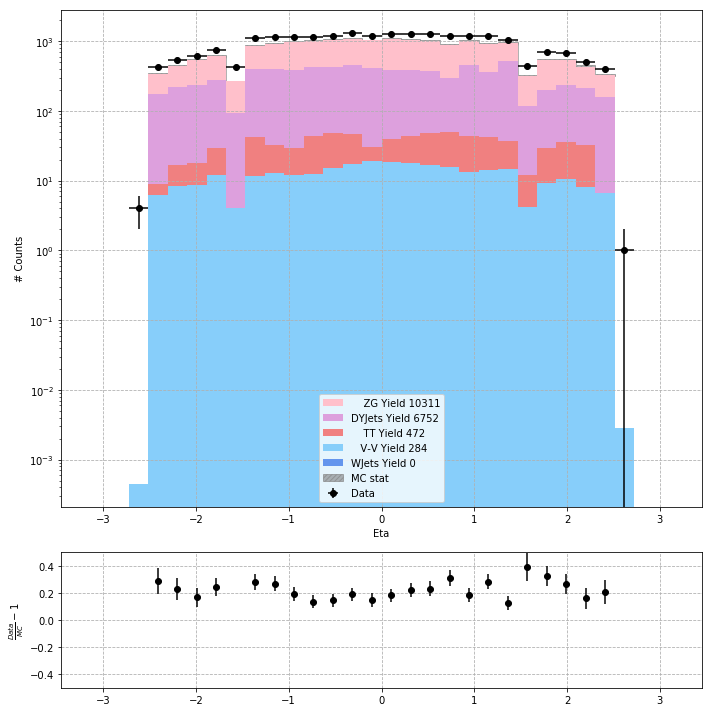

----------------photonOne_EEPt----------------


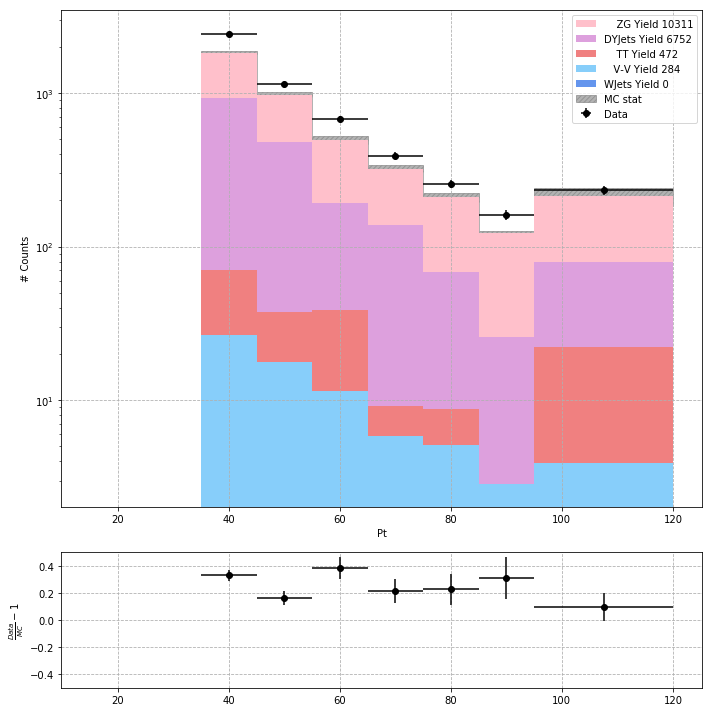

----------------photonOne_EEPhi----------------


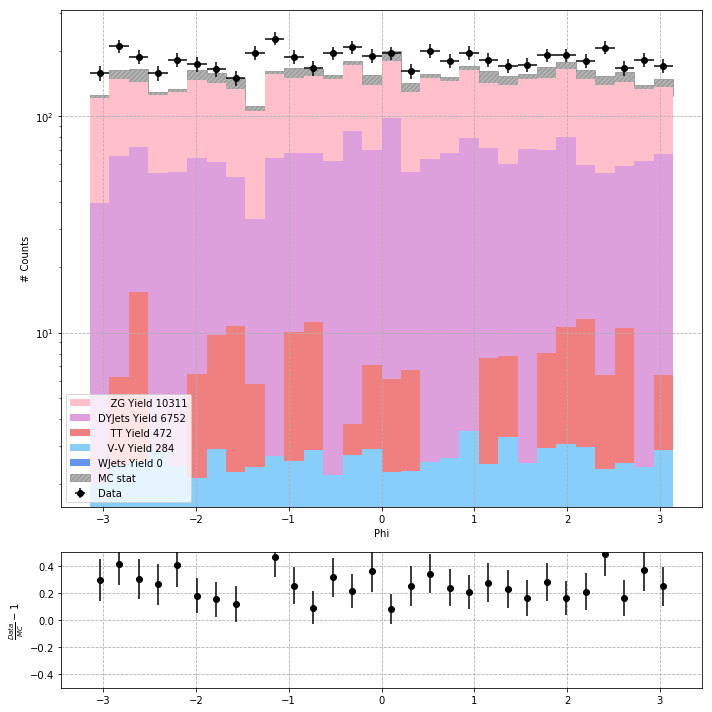

----------------photonOne_EEEta----------------


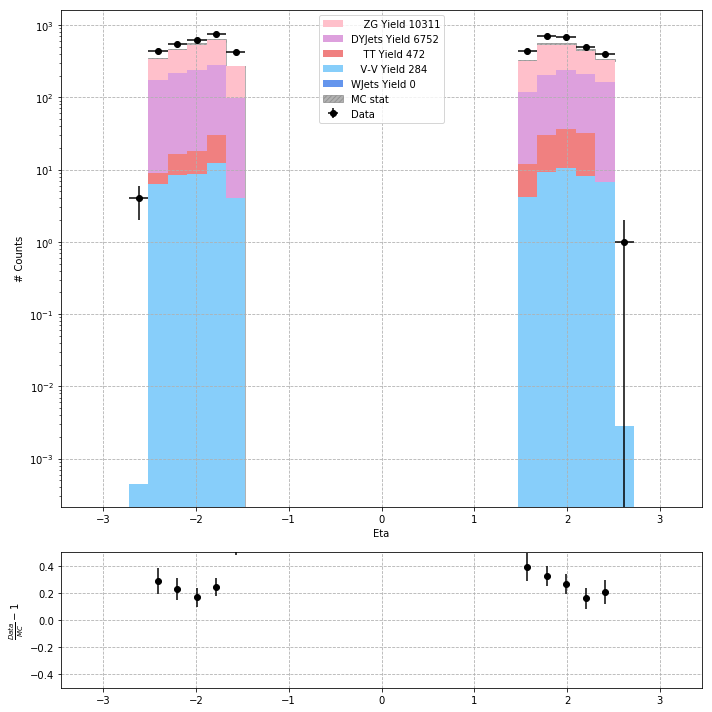

----------------photonOne_EBPt----------------


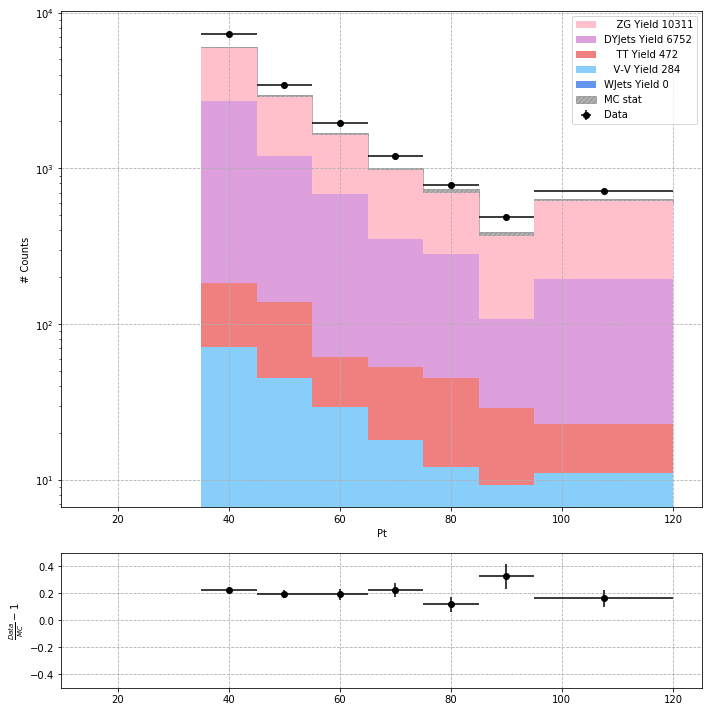

----------------photonOne_EBPhi----------------


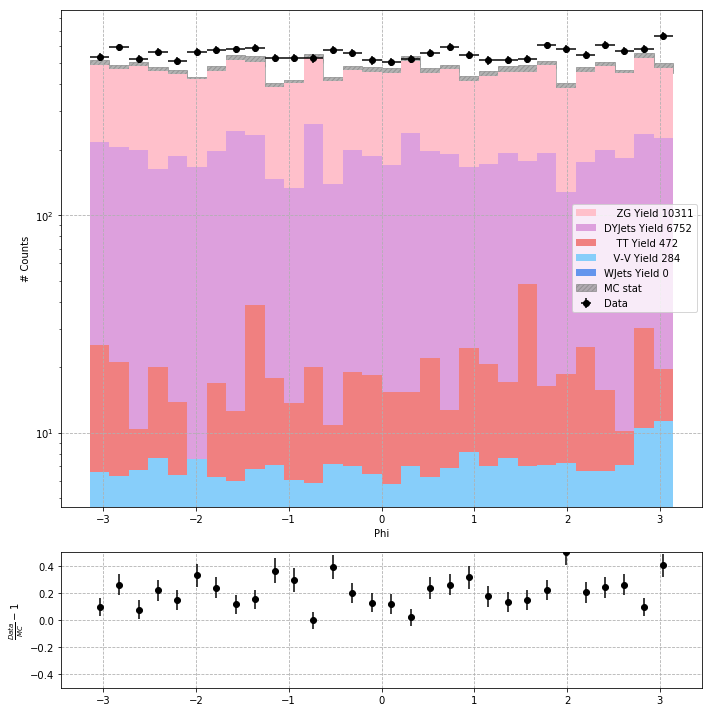

----------------photonOne_EBEta----------------


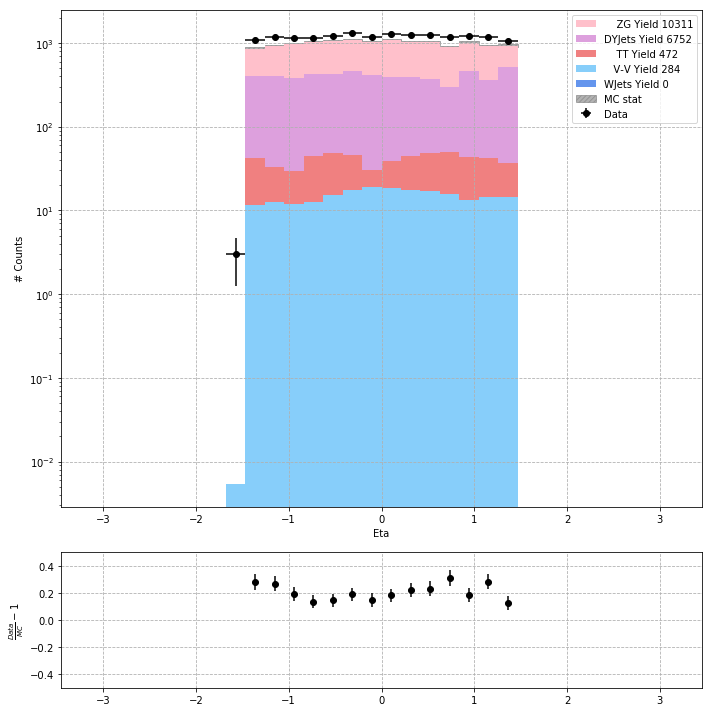

----------------dileptonPt----------------


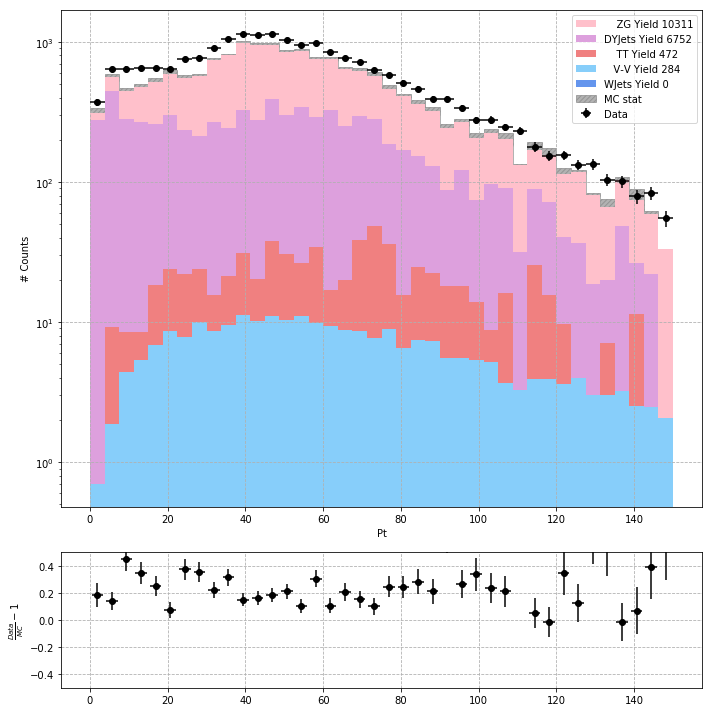

----------------dileptonPhi----------------


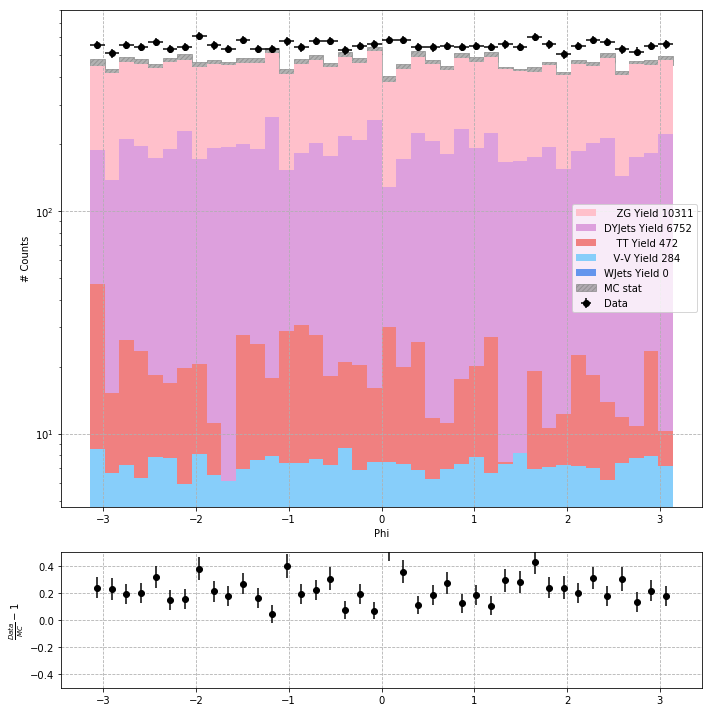

----------------dileptonEta----------------


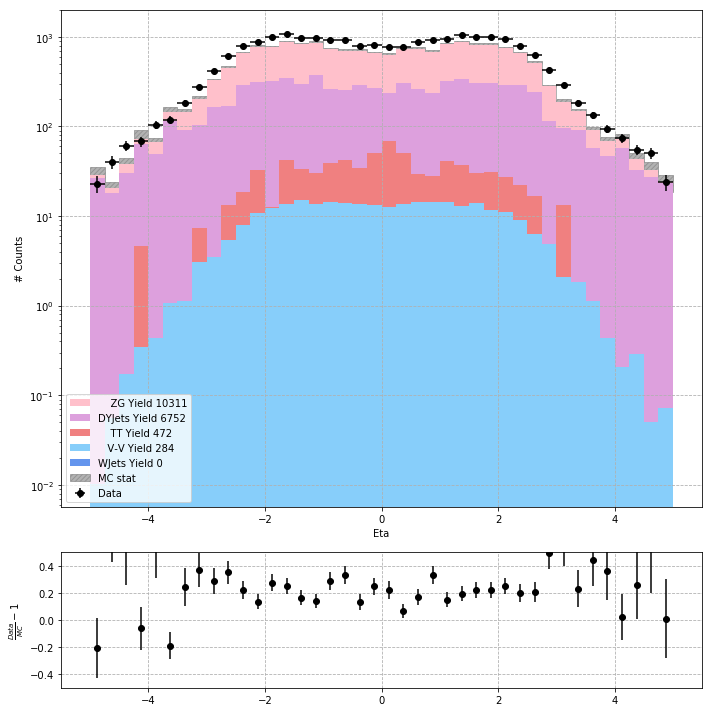

----------------dilepton_EEPt----------------


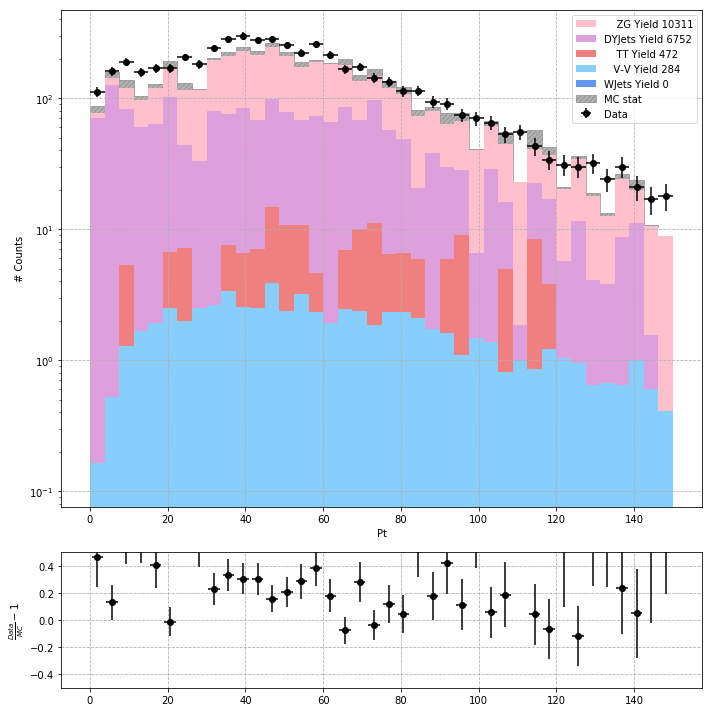

----------------dilepton_EEPhi----------------


UnboundLocalError: local variable 'scale' referenced before assignment

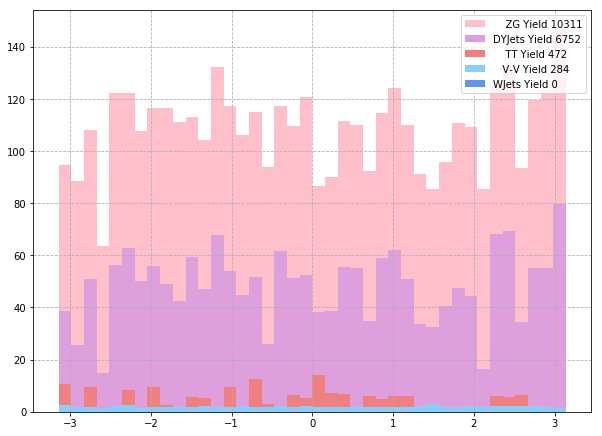

In [137]:
if LOG == 'both':
    for log in [True,False]:
        ###############################    
        if log:
            stackFol = Fol+'/log'
        else:
            stackFol = Fol+'/linear'
        ###############################    
        Single_Ploting(data,stacked,log,weightCorrection,Blind,Plotting,StatInclude)
else:
    Single_Ploting(data,stacked,log,weightCorrection,Blind,Plotting,StatInclude)

# Multi Graphs

----------------Pt----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: Runt

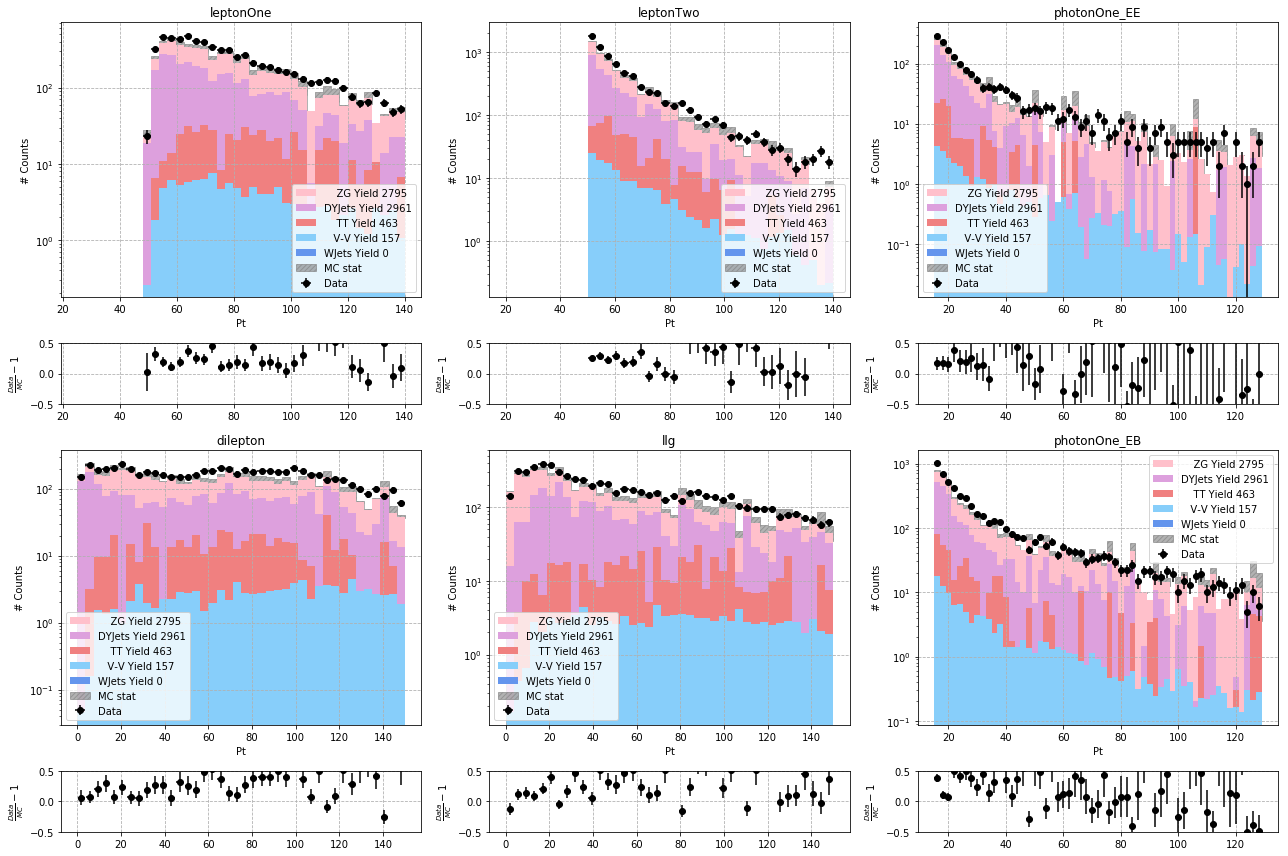

----------------Phi----------------


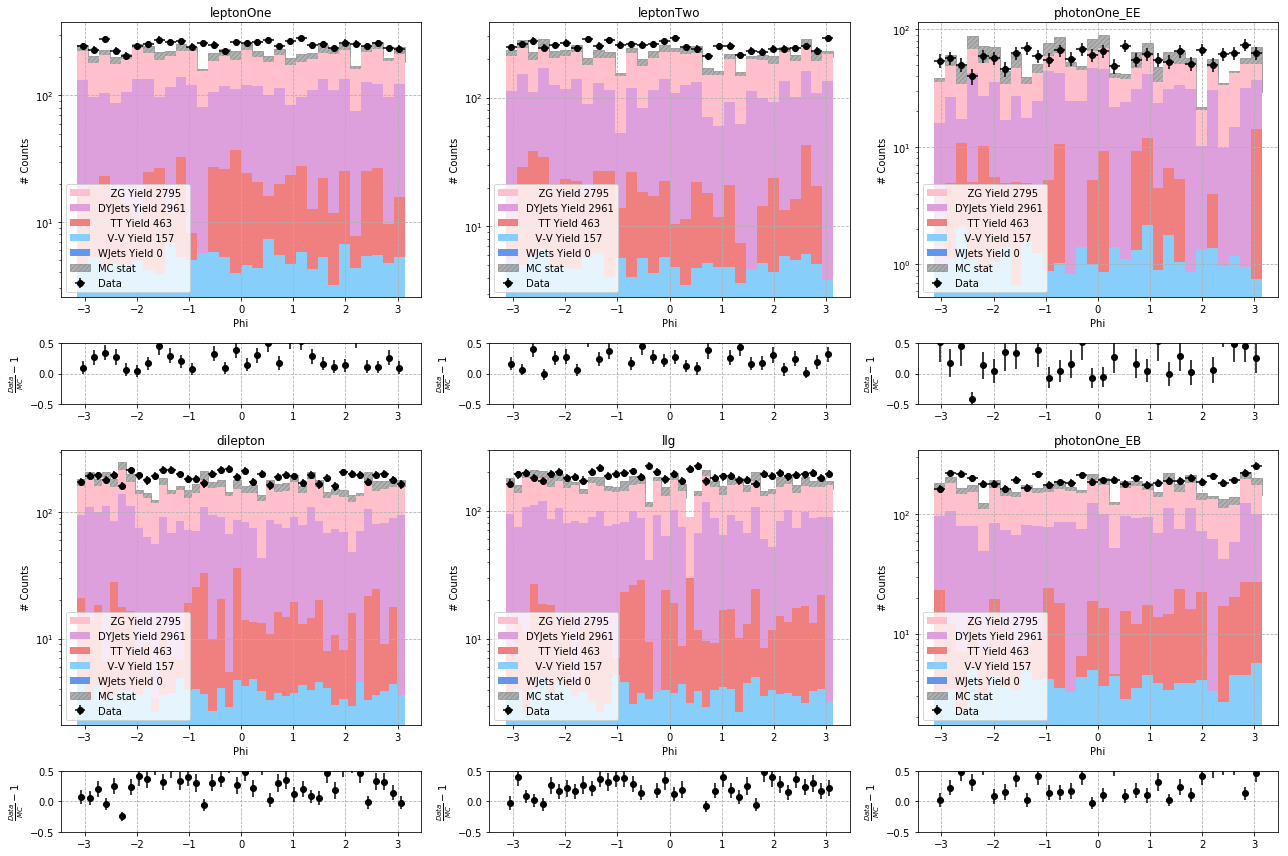

----------------Eta----------------


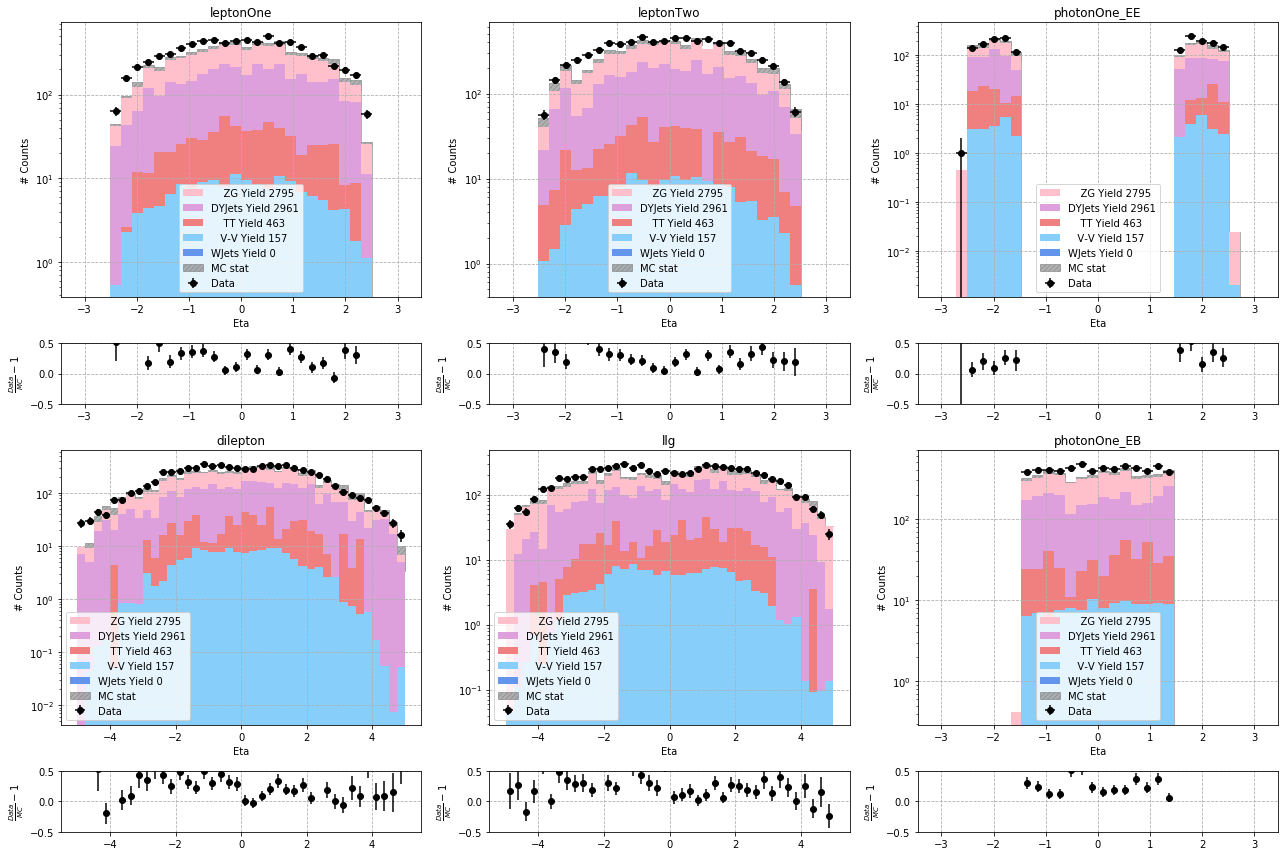

----------------DEta----------------


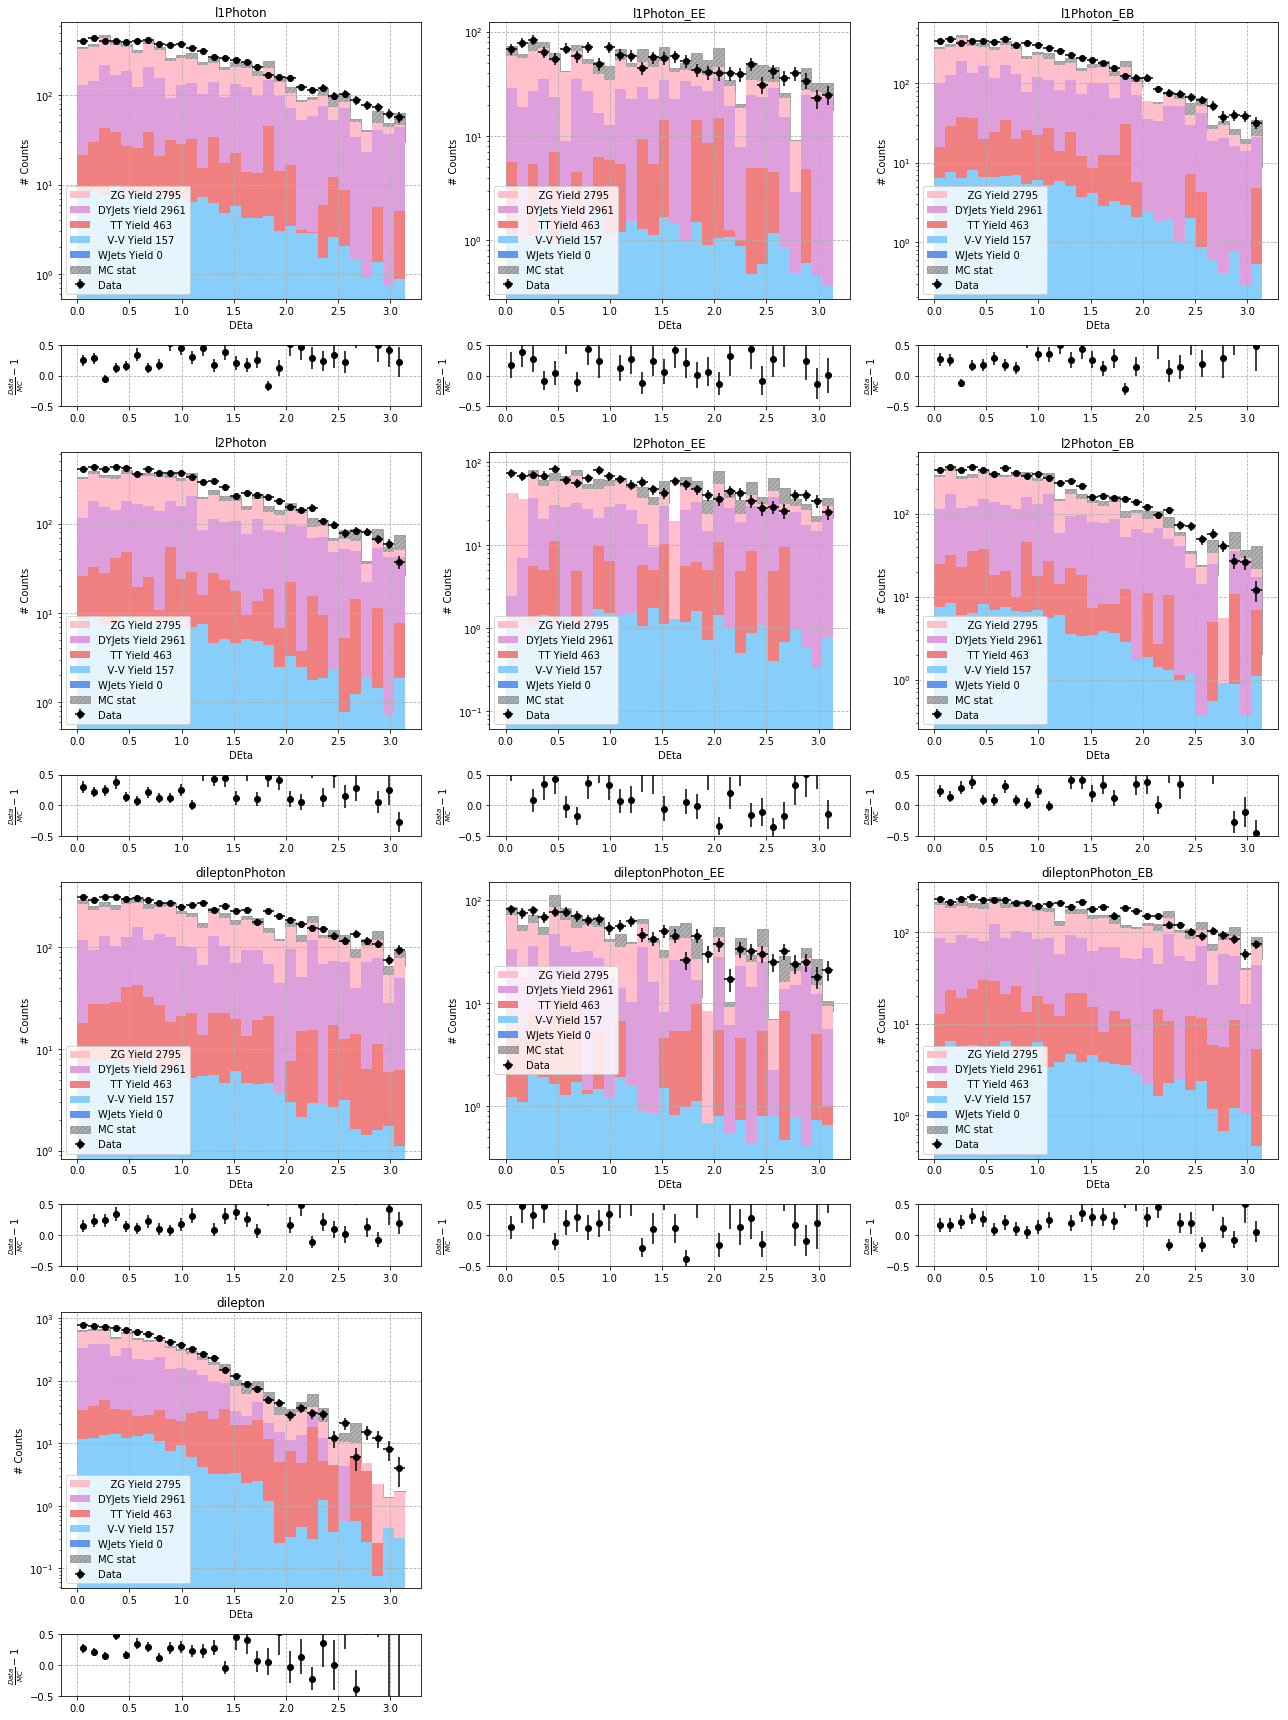

----------------DPhi----------------


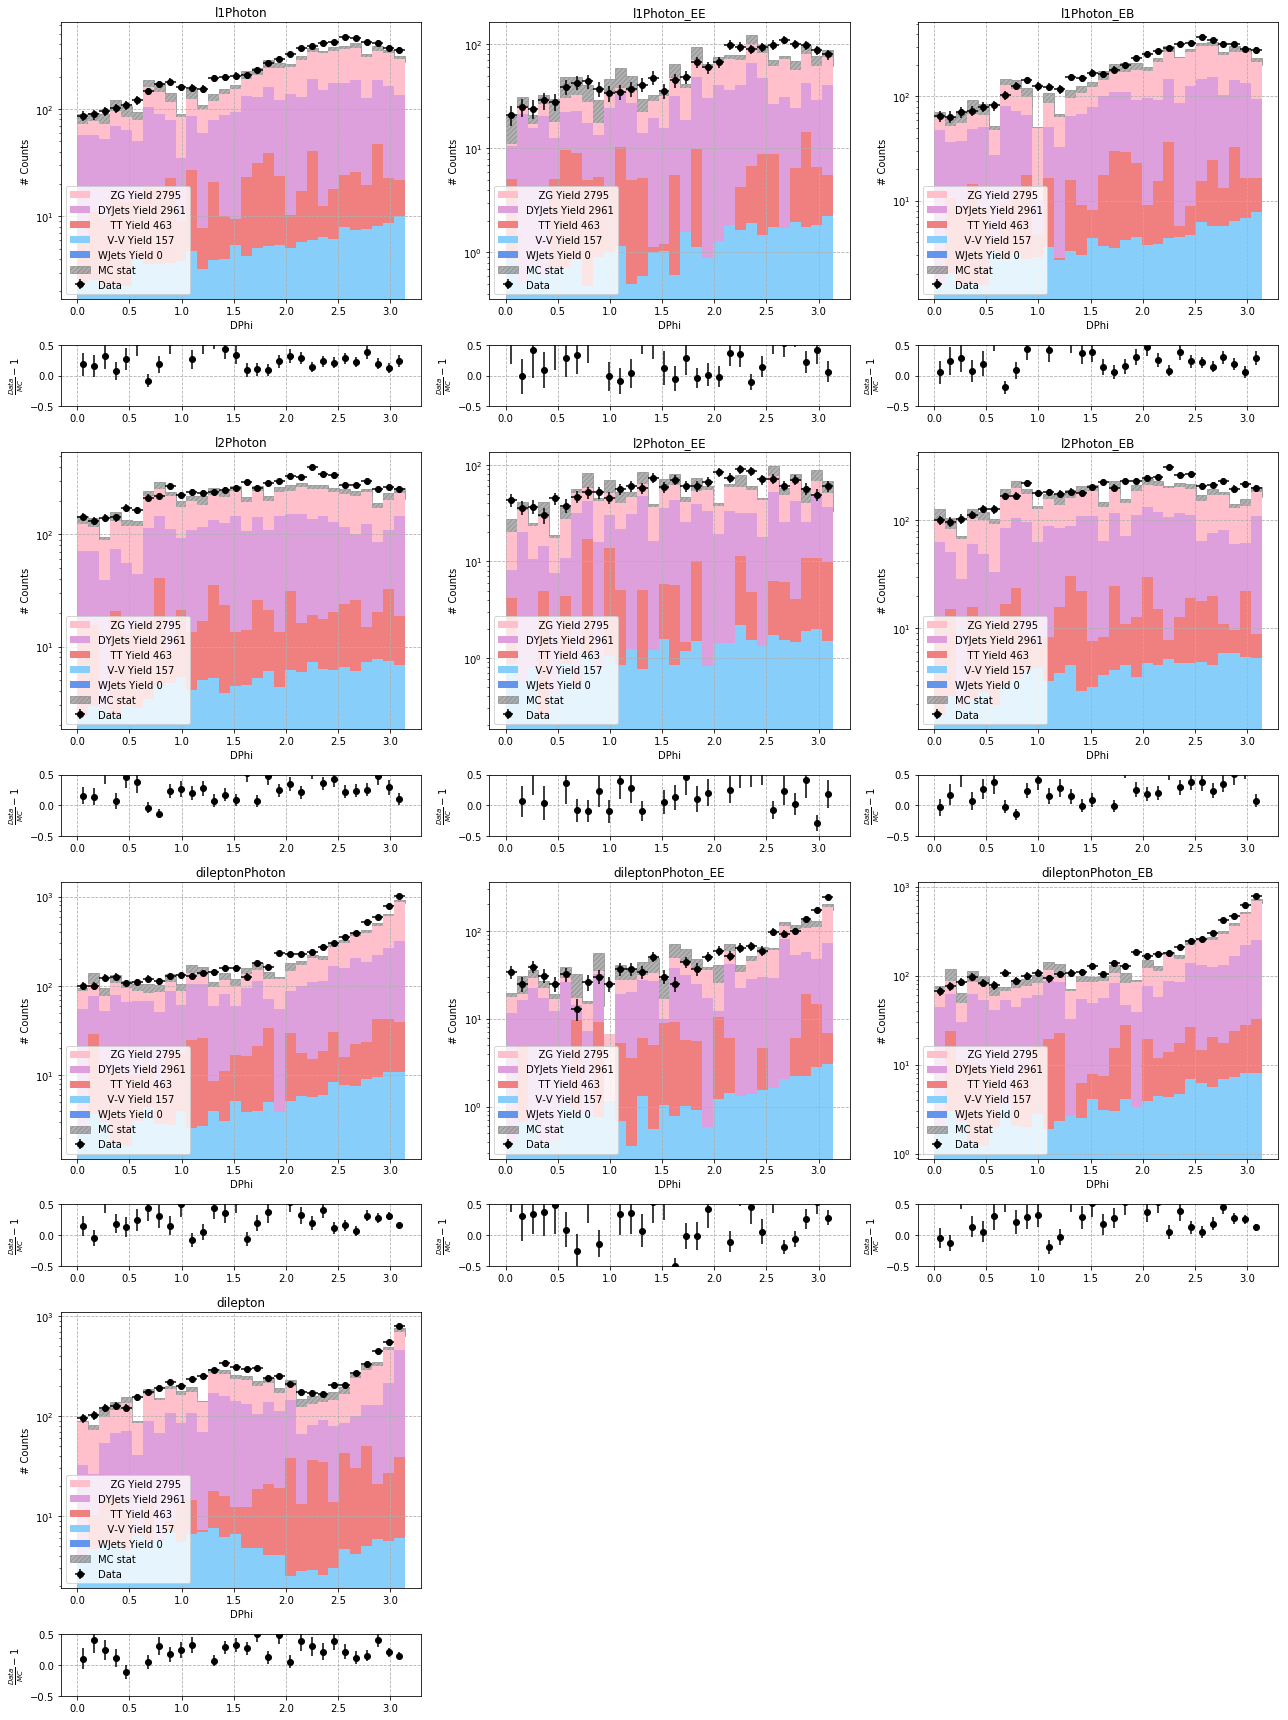

----------------DR----------------


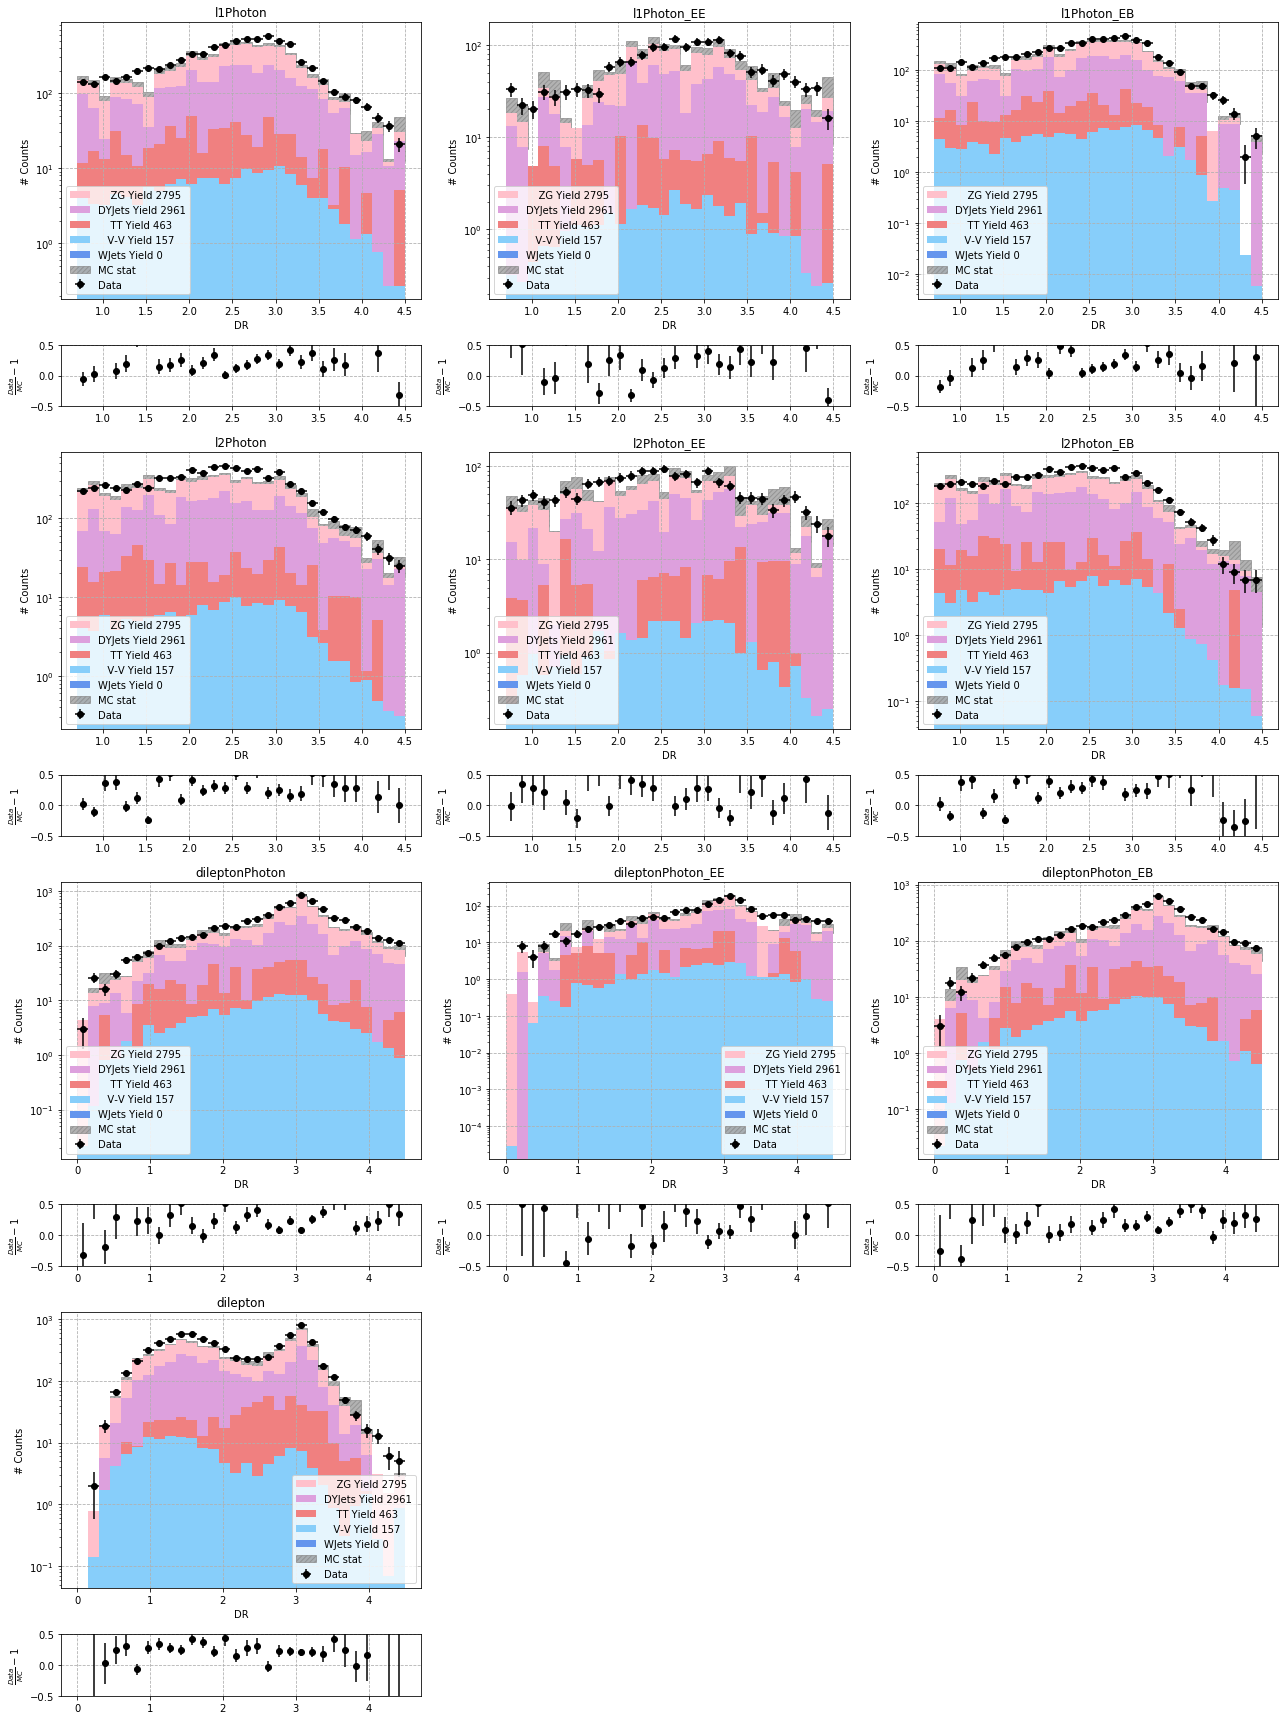

----------------HoverE----------------


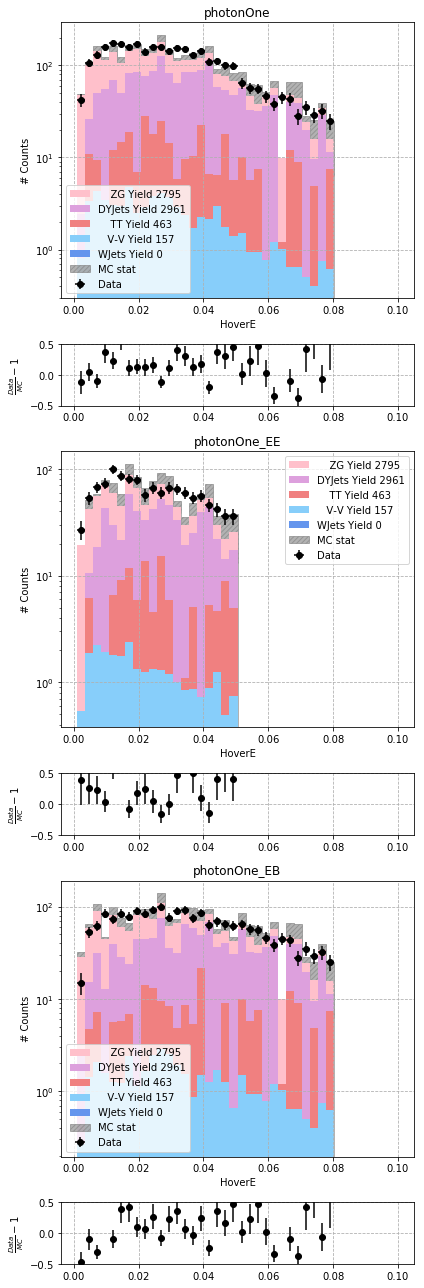

----------------R9----------------


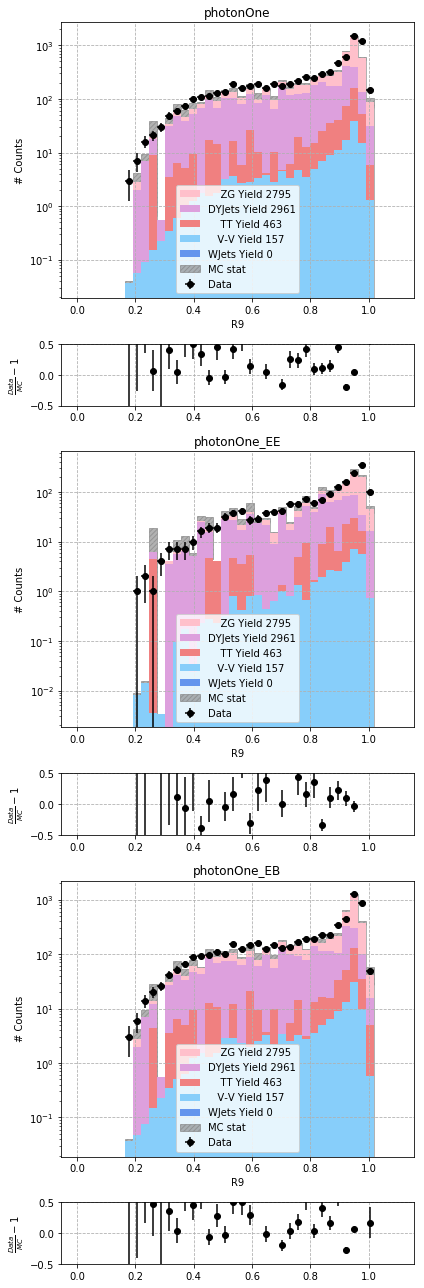

----------------MVA----------------


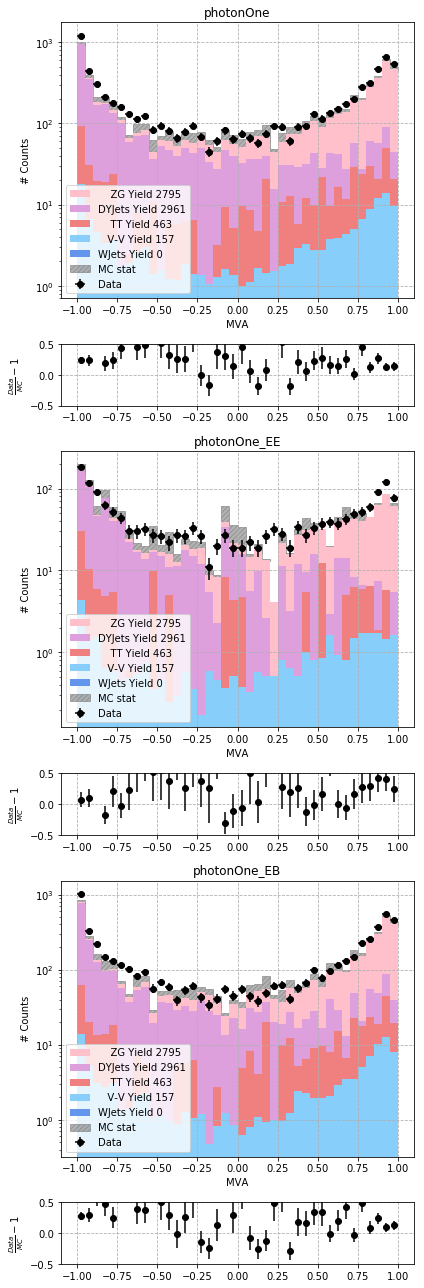

----------------Ich----------------


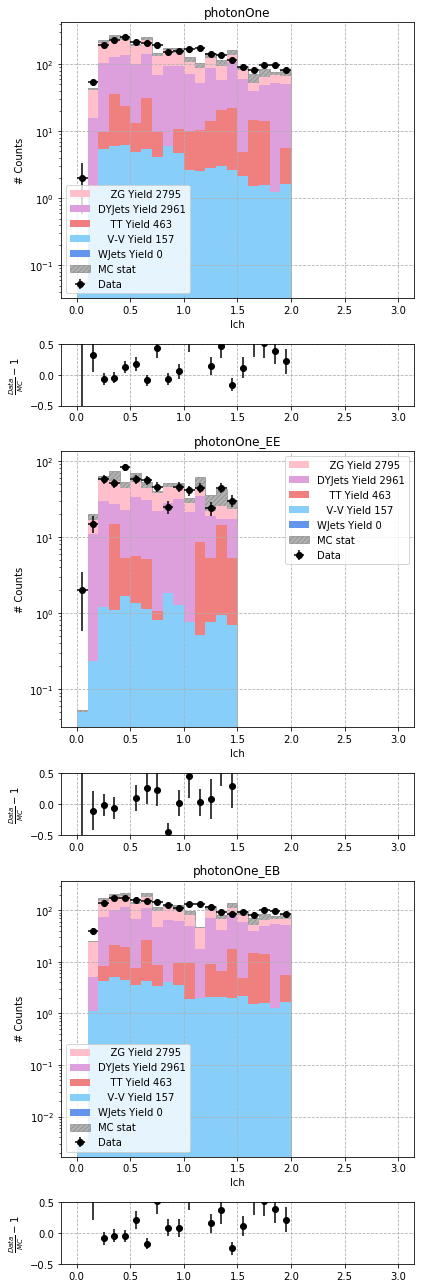

----------------Ineu----------------


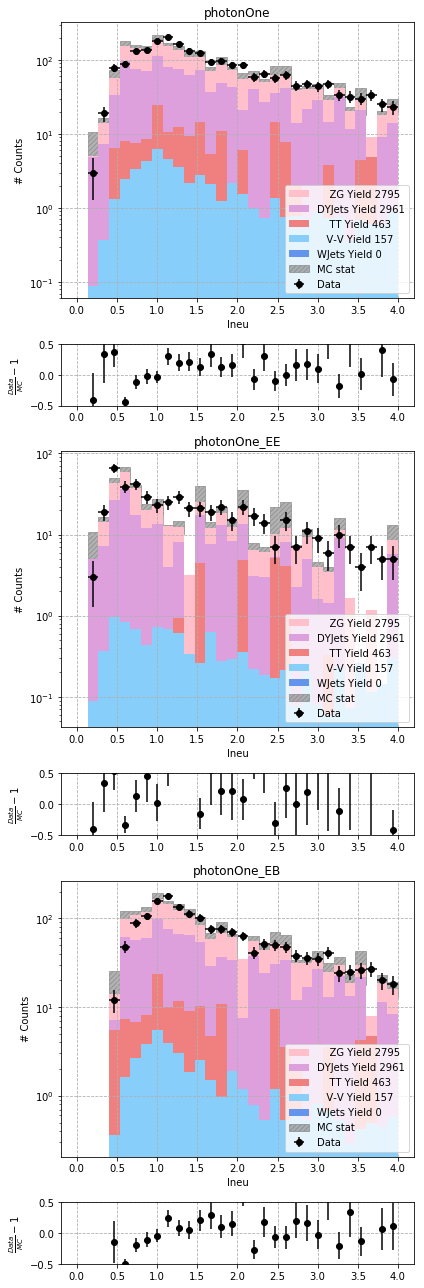

----------------Iph----------------


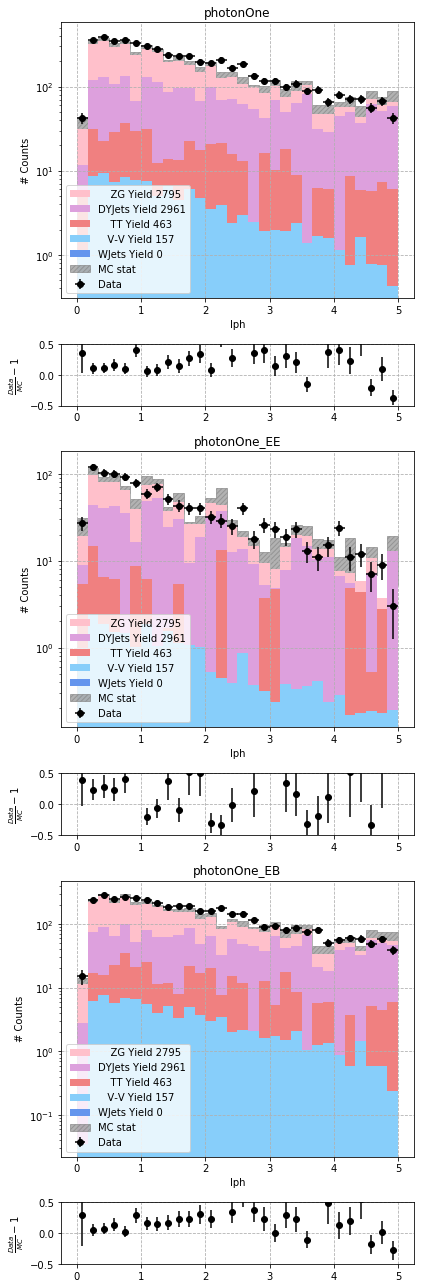

----------------M----------------


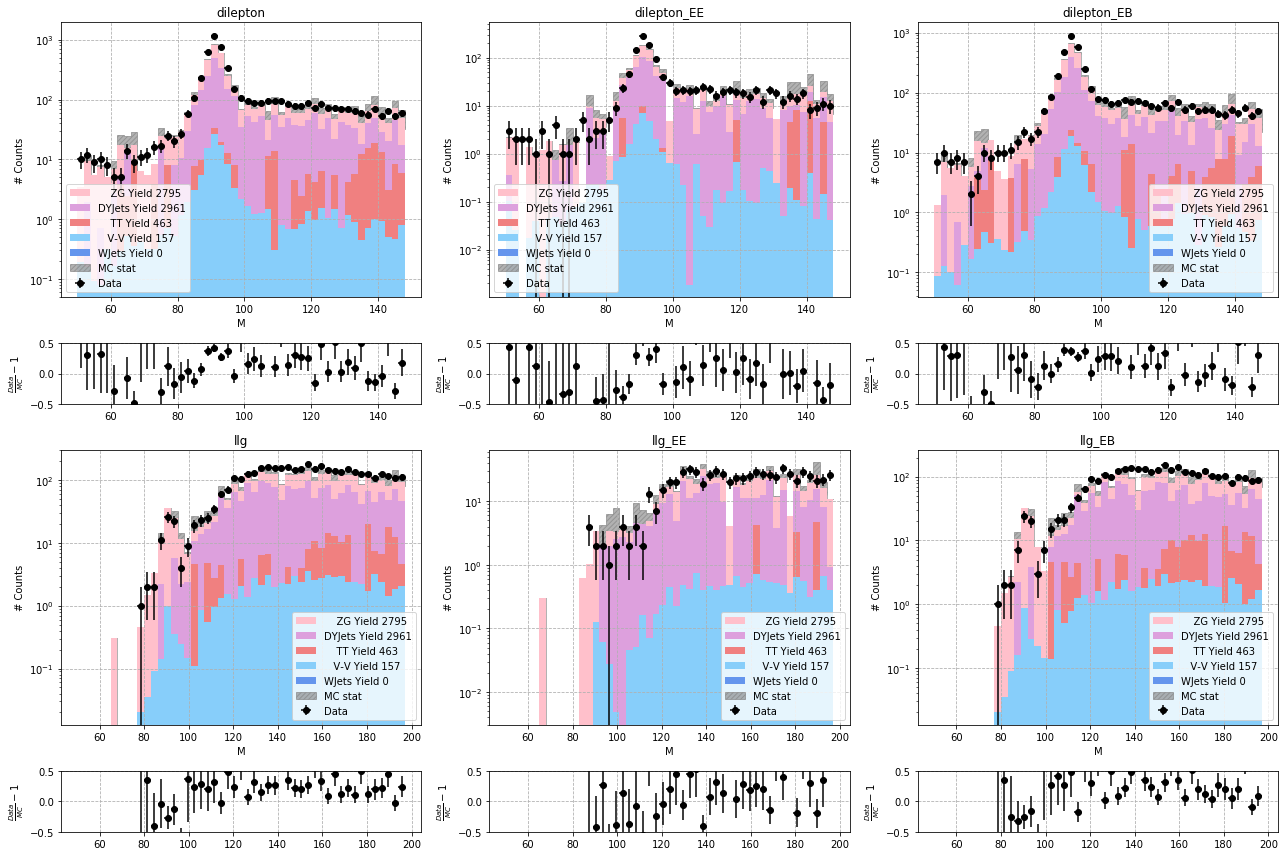

----------------Srr----------------


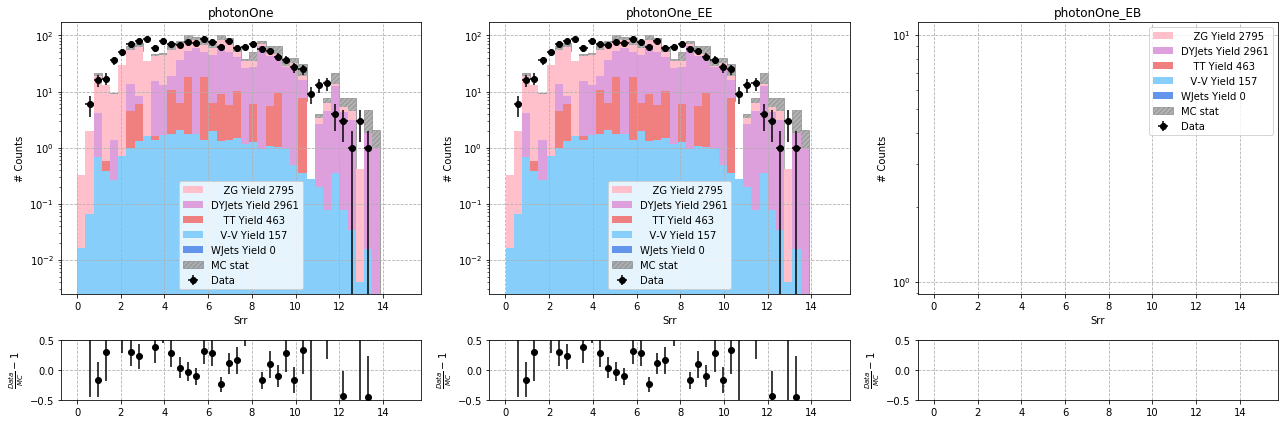

----------------Sipip----------------


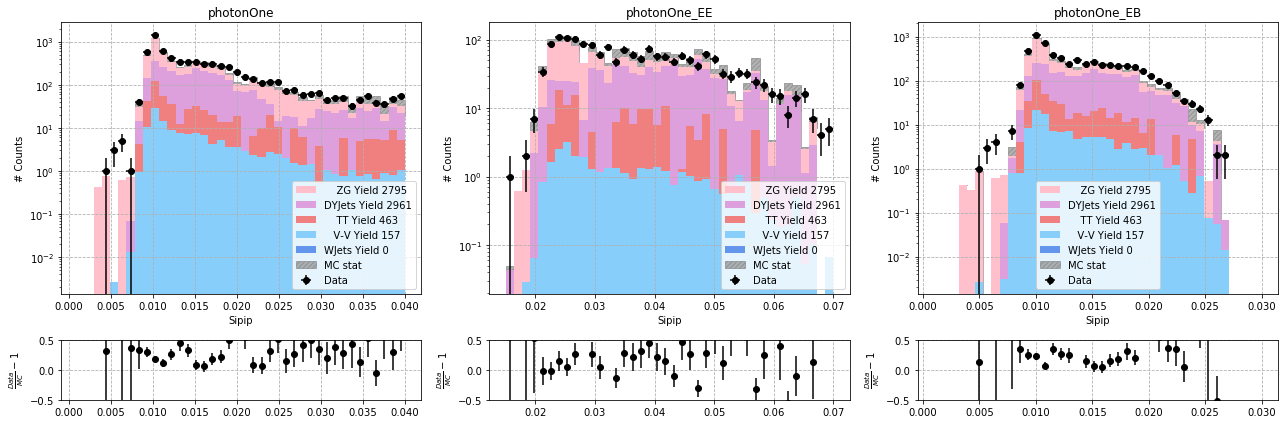

----------------Sieip----------------


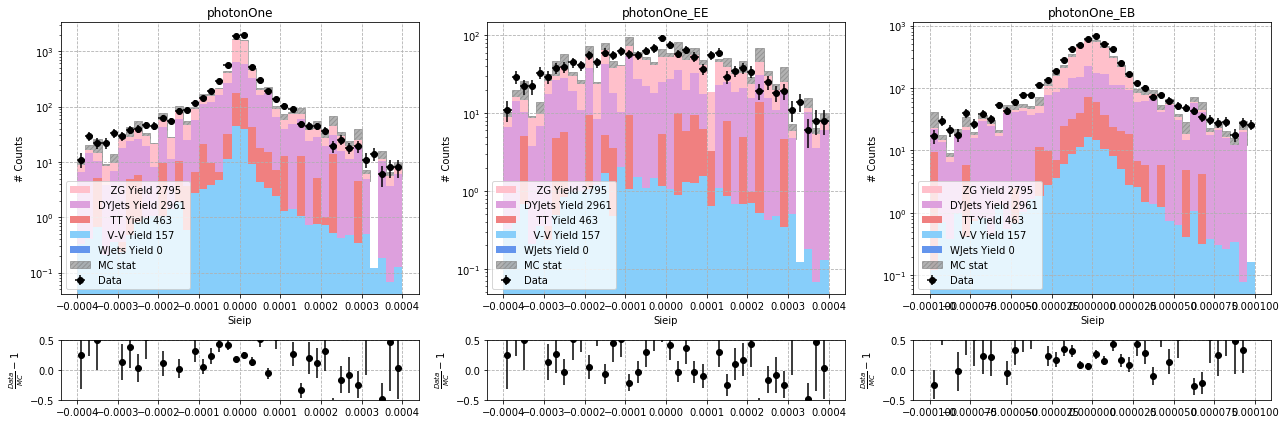

----------------Sieie----------------


/home/jcordero/anaconda3/envs/CMSenv/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


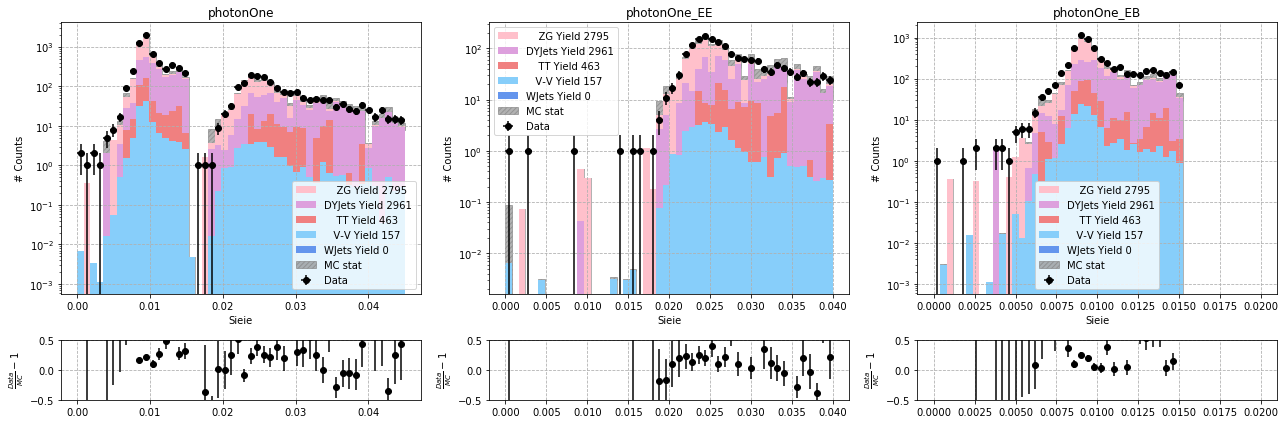

----------------E2x2----------------


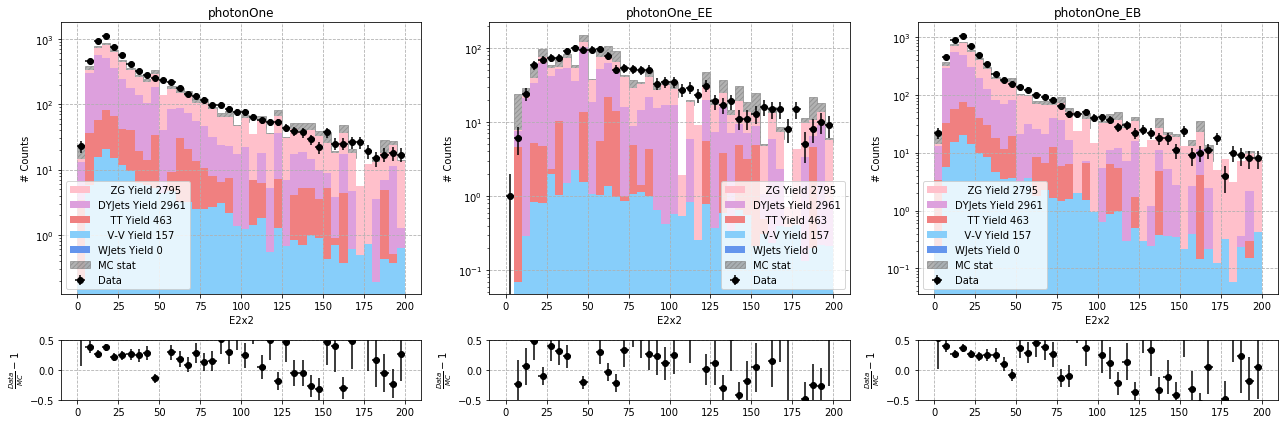

----------------E5x5----------------


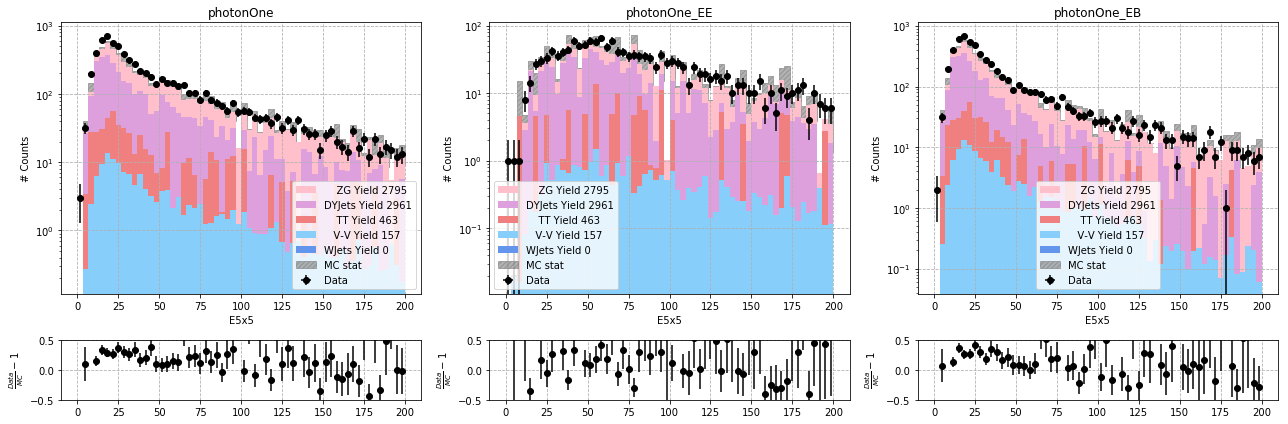

----------------PreShowerE----------------


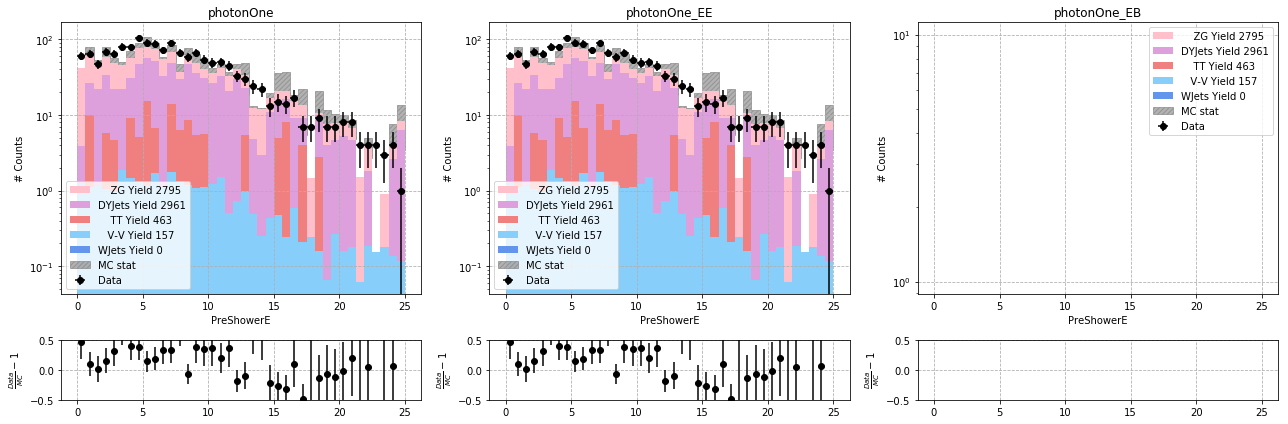

----------------ScEtaWidth----------------


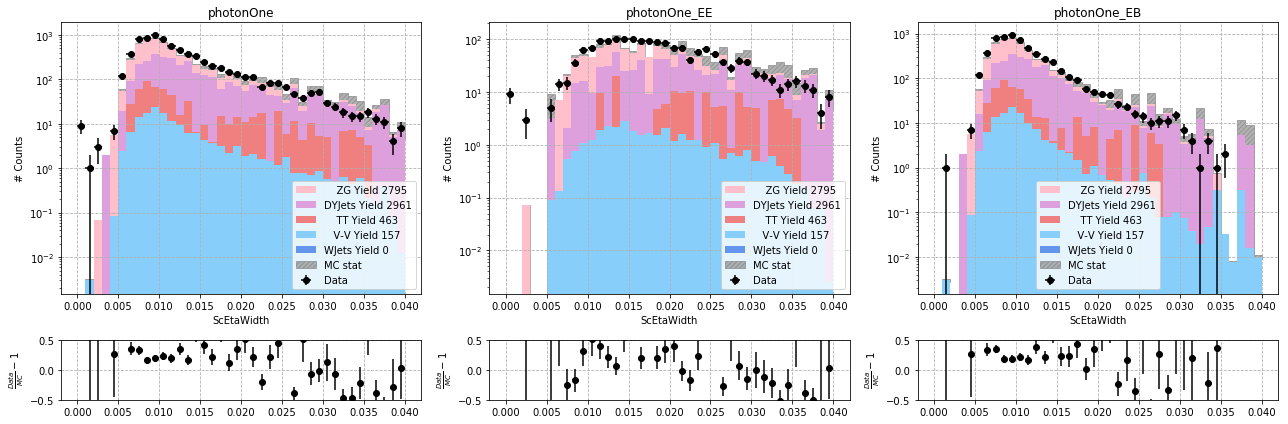

----------------ScPhiWidth----------------


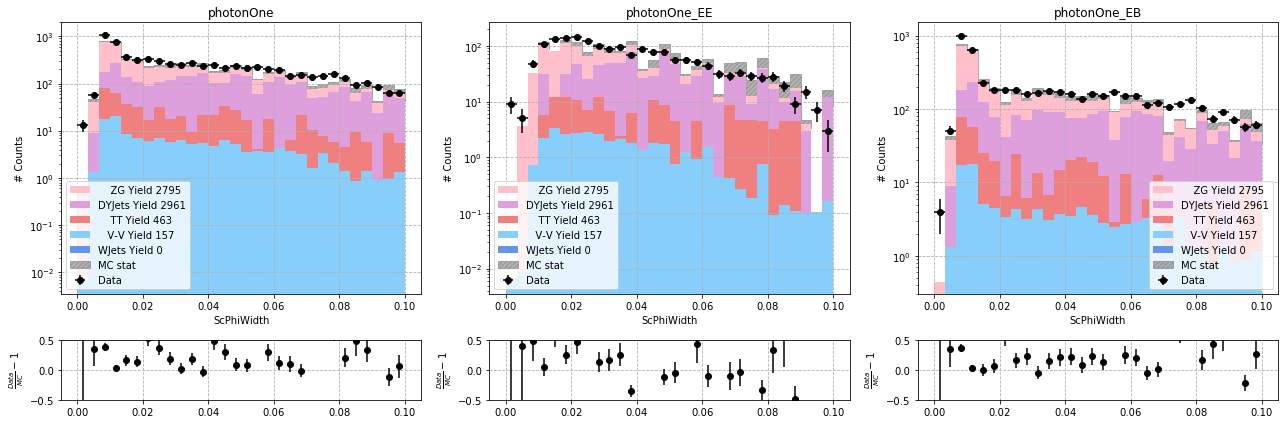

----------------ScRawE----------------


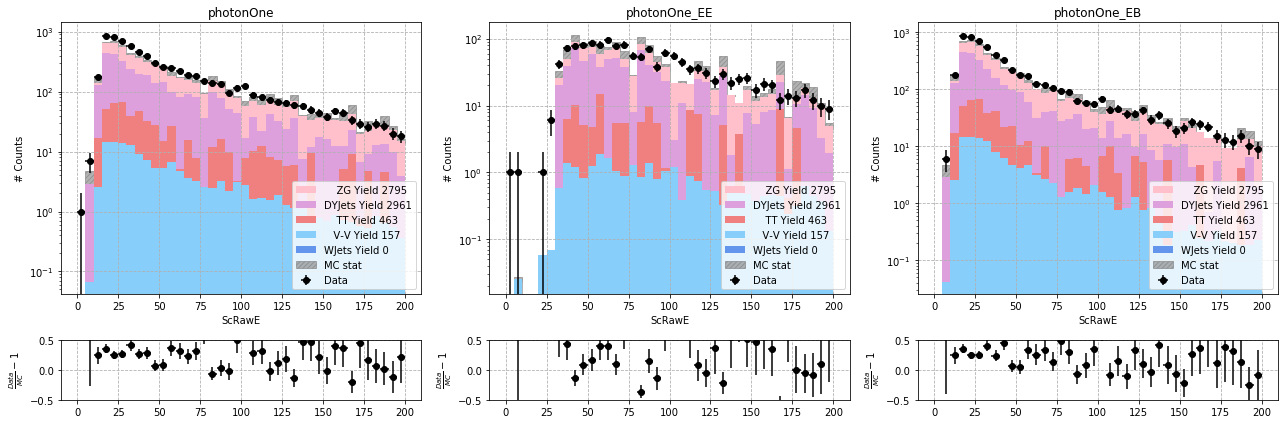

----------------ScBrem----------------


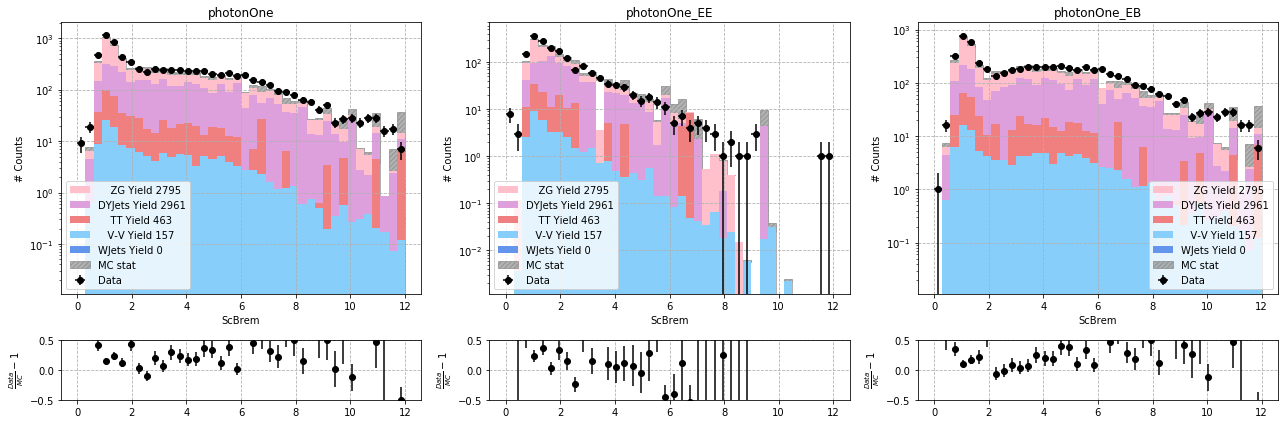

In [175]:
LOG = 'Single'
if LOG == 'both':
    for log in [True,False]:
        ###############################    
        if log:
            stackFol = Fol+'/log'
        else:
            stackFol = Fol+'/linear'
        ###############################    
        Multi_Ploting(data,stacked, log, customRange, weightCorrection, Blind, Plotting, StatInclude)
else:
    ###############################    
    if log:
        stackFol = Fol+'/log'
    else:
        stackFol = Fol+'/linear'
    ###############################    
    Multi_Ploting(data,stacked, log, customRange, weightCorrection, Blind, Plotting, StatInclude)

# NJets Graphs

In [ ]:
#LOG = 'Not both'
#log = True
LOG = 'both'
for i in range(5):
    if stacked:
        Fol  = 'nJets/Stacked_nJets'+str(i)
    else:
        Fol  = 'nJets/Unstacked_nJets'+str(i)
    
    PhaseSpace(
                data,
                phType = phType,
                Charge = Charge,
                Region = Region,
                Print  = Print,
                MVA    = MVA,
                )
    for d in data:
        d.AddCuts(d.df.nJets == i)
            
    
    if LOG == 'both':
        for log in [True,False]:
            ###############################    
            if log:
                stackFol = Fol+'/log'
            else:
                stackFol = Fol+'/linear'
            ###############################    
            Multi_Ploting(data,stacked,log,customRange,weightCorrection,Blind,Plotting,StatInclude)
    else:
        ###############################    
        if log:
            stackFol = Fol+'/log'
        else:
            stackFol = Fol+'/linear'
        ###############################   
        Multi_Ploting(data,stacked,log,customRange,weightCorrection,Blind,Plotting,StatInclude)

# Exploring 2D hists

In [ ]:
def Hist2D(X,Y,W,
          xrange,yrange):
    fig = plt.figure(figsize=(8,10))

    #plt.subplot(2,1,1)
    plt.hist2d(X,Y,
              range=[xrange,yrange],
              bins = 80,
              norm=col.LogNorm(),
              #norm=col.LogNorm,
              weights = W,
              #cmap = 'Blues'#'Reds'#'cool'#'jet'#'RdYlGn'
              )
    plt.title('DYJets',fontsize=20)
    ax = plt.gca()
    ax.set_xlabel(xpart+xvar,fontsize = 20)
    ax.set_ylabel(ypart+yvar,fontsize = 20)
    #plt.colorbar()
    fig.savefig(figpath+ xpart+xvar+'_'+ypart+xvar+'.png')

In [ ]:
xpart, xvar, xrange = 'dilepton'      , 'M' , [50,200]
#xpart, xvar, xrange = 'photonOne', 'Sieie' , [0.,0.031]
#xpart, xvar, xrange = 'photonOne', 'HoverE', [0.005,0.1]
#xpart, xvar, xrange = 'photonOne', 'Ich'   , [0.1,3]
#xpart, xvar, xrange = 'photonOne', 'Ineu'  , [0.1,0.4]
#xpart, xvar, xrange = 'photonOne', 'Iph'   , [0.1,5]
#xpart, xvar, xrange = 'photonOne', 'R9'    , [0.005,0.1]
#xpart, xvar, xrange = 'photonOne', 'MVA'   , [-1,1]

ypart, yvar, yrange = 'llg'      , 'M' , [50,300]
#ypart, yvar, yrange = 'dilepton'      , 'DR' , [0,6]
#ypart, yvar, yrange = 'dileptonPhoton', 'DR' , [0,6]
#ypart, yvar, yrange = 'dilepton'      , 'M'  , [30,150]
#ypart, yvar, yrange = 'leptonTwo'     , 'Pt' , [0,60]
#ypart, yvar, yrange = 'photonOne'     , 'Ich' , [0,60] 

X = [d.GetWithCuts(xpart+xvar) for d in data]
Y = [d.GetWithCuts(ypart+yvar) for d in data]
W = [d.GetWithCuts('weight')   for d in data]

ph = ""

N = 0
#xrange = Help.plotOpsAll[N]['range'][xvar][xpart]
#yrange = Help.plotOpsAll[N]['range'][yvar][ypart]
Hist2D(X[N],Y[N],W[N],xrange,yrange)

N = -2
#xrange = Help.plotOpsAll[N]['range'][xvar][xpart]
#yrange = Help.plotOpsAll[N]['range'][yvar][ypart]
Hist2D(X[N],Y[N],W[N],xrange,yrange)
